In [1]:
# Run all cells in order to train a model to predict number of lanes from satellite image
# the training data is a csv file defined by the variable data_path
# the satellite image folder should be in the path defined by base_satellite_image_path
# the output model with be saved at the path defined by model_path
# uncomment the Dataset Exploration section to look into the dataset

In [2]:
!pip install --upgrade torch torchvision

In [3]:
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
from skimage import io, transform
import random
from PIL import Image
import time
import copy
import math
import shutil
from tqdm import tqdm
from pylab import imshow

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/Road-Network-Inference

/content/drive/.shortcut-targets-by-id/1rag2JSDd-IVo9U0q6DihWrUW5HeFCbjM/Road-Network-Inference


In [6]:
!nvidia-smi

Thu May 19 18:47:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
print(torch.__version__)

1.11.0+cu113


In [8]:
print(torchvision.__version__)

0.12.0+cu113


# Configs and Constants

In [9]:
# seed for torch
torch_seed = 42

# seed for random to split train, val, test
random_seed = 42

# fraction of the data use for validation set
validation_fraction = 0.1

# fraction of the data use for test set
test_fraction = 0.1

# location of csv dataset
data_path = 'data_test.csv'

# path to the folder containing satellite image
base_satellite_image_path = '/content/drive/MyDrive/Road-Network-Inference/'

# path to save the best model
best_model_path = '/content/drive/MyDrive/Road-Network-Inference/bestModel_test.pt' # bestModel2_vgg_sgd_01.pt
# path to save the checkpoint so that training can resume from checkpoint in case of failure
checkpoint_path = '/content/drive/MyDrive/Road-Network-Inference/chkPoint_test.pt' # chkPoint2_vgg_sgd_01.pt

# loss parameters
focalLossGamma = 2

# SGD optimizer parameters
optimizerLr = 0.001
optimizerMomentum = 0.9

# Adam optimizer parameters
# optimizerWeightDecay = 0.01

# uncomment below if you want to use scheduler
# scheduler parameters
# schedulerStepSize = 8
# schedulerGamma = 0.1

# number of epoch to train the model
numEpoch = 24

In [10]:
torch.manual_seed(torch_seed)

In [11]:
df = pd.read_csv(data_path)
classes = np.sort(df.lanes.unique())

# Define Dataset

In [12]:
# dataset for the model
# indices is a list of index to index in to the csv dataset
# augmentSize is how many times to increase the dataset through transform augment
# ex 2 will produce 2 data images from 1 satelite image
# the randomness in the transform flip and rotation will make the 2 data images differ but have same data
# the idea is that the road at the center of the image is the same regardless of rotation and flip
# transform is the transform operation applied to the image
# returns the image, lanes, and extra data such as one hot encoded highway type and oneway
class RoadsDataset(Dataset):
    def __init__(self, 
                 indices,
                 augmentSize = 1, 
                 transform=None):
        self.indices = indices
        self.augmentSize = augmentSize
        self.labelDf = pd.read_csv(data_path)
        self.transform = transform

    def __len__(self):
        return self.augmentSize*len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # convert dataset index to csv dataset index
        idx = self.indices[idx // self.augmentSize]

        imgName = os.path.join(base_satellite_image_path, df.iloc[idx]['sat_name'])

        image = Image.open(imgName).convert('RGB') # was rgba png with 4 dim

        if self.transform:
            image = self.transform(image)

        lanes = self.labelDf.iloc[idx]['lanes'] - 1 # -1 to make label value 1-9 -> 0-8 https://stackoverflow.com/questions/51691563/cuda-runtime-error-59-device-side-assert-triggered
        try:
            numerical_data = self.labelDf.iloc[idx, 3:16].astype(int)
        except:
            print('numerical data exception idx:', idx)
            numerical_data = []
        numerical_data = torch.tensor(numerical_data)
        return image, lanes, numerical_data

# Create Dataset

In [13]:
random.seed(random_seed)
# create train, validate, test indices
totalCount = len(df)
validCount = int(validation_fraction * totalCount)
testCount = int(test_fraction * totalCount)
trainCount = totalCount - validCount - testCount
indices = list(range(totalCount))
random.shuffle(indices)
trainIndices = indices[: trainCount]
validIndices = indices[trainCount: trainCount+validCount]
testIndices = indices[trainCount+validCount:]

In [14]:
# pretrained pytorch models require these imsize and mean, std transform
# use below if you want to use pretrained model with augmentation
# imSize = 224
# transformMean = np.array([0.485, 0.456, 0.406])
# transformStd = np.array([0.229, 0.224, 0.225])
# randomly flip and rotate training to augment the training data
# assuming original image is size 512, center crop to 448 to get rid of the watermark and some rotation artifact
# train_transform = transforms.Compose([ 
#         transforms.RandomHorizontalFlip(0.5), 
#         transforms.RandomRotation(degrees=(0, 360)),
#         transforms.CenterCrop(2*imSize),
#         transforms.Resize(imSize),
#         transforms.ToTensor(),
#         transforms.Normalize(transformMean, transformStd)])
# transform = transforms.Compose([
#         transforms.CenterCrop(2*imSize),
#         transforms.Resize(imSize),
#         transforms.ToTensor(),
#         transforms.Normalize(transformMean, transformStd)])

transformMean = np.array([0.5, 0.5, 0.5])
transformStd = np.array([0.5, 0.5, 0.5])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(transformMean, transformStd)])

In [15]:
trainDataset = RoadsDataset(indices = trainIndices, transform=transform)
validDataset = RoadsDataset(indices = validIndices, transform=transform)
testDataset = RoadsDataset(indices = testIndices, transform=transform)

In [16]:
# get the getWeightedRandomSampler to sample less common lanes more often
def getWeightedRandomSampler(indices, weight, df):
    sample_weight = []
    for i in indices:
        sample_weight.append(weight[df.iloc[i]['lanes']-1])
    return WeightedRandomSampler(torch.DoubleTensor(sample_weight), len(sample_weight))

In [17]:
laneCount = {}
for _, row in df.iterrows():
    numLanes = row['lanes']
    if numLanes in laneCount :
        laneCount[numLanes] = laneCount[numLanes] + 1
    else :
        laneCount[numLanes] = 1
      
class_sample_count = np.array([x[1] for x in sorted(laneCount.items())])
weight = 1. / class_sample_count

sampler_train = getWeightedRandomSampler(trainIndices, weight, df)
sampler_valid = getWeightedRandomSampler(validIndices, weight, df)
sampler_test = getWeightedRandomSampler(testIndices, weight, df)

In [18]:
batchSize = 2
numWorkers = 2 # complains if its greater than 2

In [19]:
dataloaders = {'train': DataLoader(trainDataset, batch_size=batchSize, shuffle=False, num_workers=numWorkers, sampler=sampler_train),
               'val': DataLoader(validDataset, batch_size=batchSize, shuffle=False), # , num_workers=numWorkers, sampler=sampler_valid
               'test': DataLoader(testDataset, batch_size=batchSize, shuffle=False), # , num_workers=numWorkers, sampler=sampler_test
               }

In [20]:
datasetSizes = { 'train': len(trainDataset),
                 'val': len(validDataset),
                 'test': len(testDataset) }

# Dataset Exploration

In [22]:
# classes

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
# print('totalCount', totalCount)
# print('len(trainIndices)', len(trainIndices))
# print('len(validIndices)', len(validIndices))
# print('len(testIndices)', len(testIndices))
# print()
# print('trainIndices[0]', trainIndices[0])
# print('validIndices[0]', validIndices[0])
# print('testIndices[0]', testIndices[0])

totalCount 11000
len(trainIndices) 8800
len(validIndices) 1100
len(testIndices) 1100

trainIndices[0] 2866
validIndices[0] 7444
testIndices[0] 5873


In [24]:
# print('sampler_train', len(sampler_train))
# print('sampler_valid', len(sampler_valid))
# print('sampler_test', len(sampler_test))

sampler_train 8800
sampler_valid 1100
sampler_test 1100


In [25]:
# print('trainDataset', len(trainDataset))
# print('validDataset', len(validDataset))
# print('testDataset', len(testDataset))

trainDataset 8800
validDataset 1100
testDataset 1100


In [26]:
# np.shape(trainDataset[0][0])

torch.Size([3, 512, 512])

In [29]:
# np.shape(validDataset[0][0])

torch.Size([3, 512, 512])

In [27]:
# np.shape(testDataset[0][0])

torch.Size([3, 512, 512])

In [28]:
# randomly check that the indexing is correct
# randomly print train dataloader to check on WeightedRandomSampler lane distribution
# for i in range(5):
#     rand_index = random.randint(0, len(trainIndices))
#     assert df.iloc[trainIndices[rand_index]]['lanes']-1 == trainDataset[rand_index][1]
#     batch = next(iter(dataloaders['train']))
#     print(batch[1])

tensor([1, 8])
tensor([4, 5])
tensor([8, 6])
tensor([4, 4])
tensor([6, 1])


In [30]:
# train_distribution = np.zeros(len(classes))
# for (i, index) in enumerate(trainIndices):
#     dfLanes = df.iloc[index]['lanes']-1
#     train_distribution[dfLanes] += 1
# list(train_distribution)

[116.0, 5978.0, 789.0, 1154.0, 565.0, 120.0, 63.0, 9.0, 6.0]

In [31]:
# valid_distribution = np.zeros(len(classes))
# for i in validIndices:
#     valid_distribution[df.iloc[i]['lanes']-1] += 1
# list(valid_distribution)

[14.0, 742.0, 103.0, 156.0, 68.0, 10.0, 6.0, 1.0, 0.0]

In [32]:
# test_distribution = np.zeros(len(classes))
# for i in testIndices:
#     test_distribution[df.iloc[i]['lanes']-1] += 1
# list(test_distribution)

[22.0, 786.0, 85.0, 110.0, 71.0, 18.0, 6.0, 2.0, 0.0]

In [33]:
# datasetSizes

{'test': 1100, 'train': 8800, 'val': 1100}

In [34]:
# np.shape(trainDataset[0][2]) # should be 13

torch.Size([13])

# Prepare to train

In [21]:
def saveCheckPoint(state, is_best):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)

In [22]:
def loadCheckPoint(model, optimizer):
    if os.path.exists(checkpoint_path) :
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer, checkpoint['epoch'], checkpoint['train_losses'], checkpoint['valid_losses'], checkpoint['train_acc'], checkpoint['valid_acc']
    else:
        print('no checkpoint file')
        return model, optimizer, 0, [], [], [], []

In [23]:
# modified VGG16 to take in extra data from the dataset in addition to the image
NUM_NUMERICAL_FEATURES = 13
class VGG16(nn.Module):
  
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(131072 , 4096)
        self.fc2 = nn.Linear(4096 + NUM_NUMERICAL_FEATURES, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def stackcat(self, x, y):
        return torch.cat((x, y), 1)

    def forward(self, x, num_data):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) # dropout was included to combat overfitting
        x = self.stackcat(x, num_data)  # add dataset values to the linear layer
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [24]:
# Focal loss to help with imbalanced data
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)                         # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))    # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [25]:
def train_model(model, criterion, optimizer, 
                start_epoch=0, num_epochs=25,
                train_losses = [], 
                valid_losses = [], 
                train_acc = [],
                valid_acc = [],
                ):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            i = 0
            # Iterate over data.
            for inputs, labels, num_data in tqdm(dataloaders[phase]):
                num_data = num_data.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs, num_data)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()

                if i % 100 == 99:    # print every 100 mini-batches
                    print('loss', loss.item())
                    print('preds', preds)
                    print('labels', labels)
                    print('#correct', (preds == labels).sum().item())
                    print('%s [%d, %d] loss: %.3f correct: %d' %
                        (phase, epoch + 1, i + 1, running_loss, running_corrects))
                i += 1
            # uncomment below if want to use scheduler and add scheduler as param
            # if phase == 'train':
            #     scheduler.step()
            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects / datasetSizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            if phase == 'val':
                valid_losses.append(epoch_loss)
                valid_acc.append(epoch_acc)

            # save checkpoint after validation step
            if phase == 'val':
                modelStateDict = model.state_dict()
                optimizerStateDict = optimizer.state_dict()
                state = {
                    'epoch': epoch + 1,
                    'state_dict': modelStateDict,
                    'optimizer': optimizerStateDict,
                    'train_losses': train_losses, 
                    'valid_losses': valid_losses, 
                    'train_acc': train_acc, 
                    'valid_acc': valid_acc
                }
                is_best = epoch_acc > best_acc
                saveCheckPoint(state, is_best)
                if is_best:
                    best_model_wts = copy.deepcopy(modelStateDict)
                    best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since

    fig, axs = plt.subplots(1, 2)
    axs[0].plot(list(range(0, len(train_losses))), train_losses, label='train')
    axs[0].plot(list(range(0, len(valid_losses))), valid_losses, label='test')
    axs[0].set_title('losses')
    axs[0].legend()
    axs[1].plot(list(range(0, len(train_acc))), train_acc, label='train')
    axs[1].plot(list(range(0, len(valid_acc))), valid_acc, label='test')
    axs[1].set_title('accuracy')
    axs[1].legend()

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train model

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
device

device(type='cuda', index=0)

In [28]:
model = VGG16()
model_ft = model.to(device)

criterion = FocalLoss(gamma=focalLossGamma)

# All parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=optimizerLr, momentum=optimizerMomentum) # optim.AdamW(model_ft.parameters(), lr=optimizerLr, weight_decay=optimizerWeightDecay) 

# Decay LR by a factor of 0.1 every 8 epochs
# if you want to use scheduler, edit train_model to take in extra scheduler param,
# uncomment the scheduler step and pass the scheduler in
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=schedulerStepSize, gamma=schedulerGamma)

In [29]:
print('model already exist:', os.path.exists(best_model_path))
print('checkpoint already exist:', os.path.exists(checkpoint_path))

model already exist: True
checkpoint already exist: True


In [30]:
# uncomment and run remove checkpoint path if want to train new model
# os.remove(checkpoint_path)
# os.remove(best_model_path)

In [31]:
# load existing checkpoint, to continue training from checkpoint
# ex in case session timeout or crashed
model_ft, optimizer_ft, startEpoch, train_losses, valid_losses, train_acc, valid_acc = loadCheckPoint(model_ft, optimizer_ft)

In [32]:
startEpoch

24

In [33]:
torch.cuda.empty_cache()

Epoch 0/23
----------


  2%|▏         | 101/4400 [00:28<19:09,  3.74it/s]

loss 1.828386664390564
preds tensor([3, 2], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 1
train [1, 100] loss: 370.523 correct: 25


  5%|▍         | 201/4400 [00:50<17:19,  4.04it/s]

loss 1.8599748611450195
preds tensor([8, 5], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 0
train [1, 200] loss: 735.573 correct: 47


  7%|▋         | 301/4400 [01:12<13:56,  4.90it/s]

loss 1.8039419651031494
preds tensor([3, 8], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 0
train [1, 300] loss: 1097.239 correct: 72


  9%|▉         | 400/4400 [01:33<11:16,  5.91it/s]

loss 1.7784159183502197
preds tensor([4, 8], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 0
train [1, 400] loss: 1452.712 correct: 112


 11%|█▏        | 500/4400 [01:54<14:29,  4.48it/s]

loss 1.800170660018921
preds tensor([8, 8], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 0
train [1, 500] loss: 1802.826 correct: 156


 14%|█▎        | 601/4400 [02:14<10:44,  5.89it/s]

loss 1.726568579673767
preds tensor([8, 4], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 0
train [1, 600] loss: 2150.978 correct: 182


 16%|█▌        | 700/4400 [02:34<15:34,  3.96it/s]

loss 1.7403173446655273
preds tensor([8, 4], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 0
train [1, 700] loss: 2489.501 correct: 237


 18%|█▊        | 801/4400 [02:55<11:16,  5.32it/s]

loss 1.6673164367675781
preds tensor([4, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [1, 800] loss: 2826.672 correct: 270


 20%|██        | 901/4400 [03:14<09:51,  5.91it/s]

loss 1.6672581434249878
preds tensor([4, 4], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 0
train [1, 900] loss: 3159.177 correct: 318


 23%|██▎       | 1001/4400 [03:33<10:06,  5.60it/s]

loss 1.722203254699707
preds tensor([4, 4], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [1, 1000] loss: 3484.641 correct: 369


 25%|██▌       | 1101/4400 [03:53<10:16,  5.35it/s]

loss 1.6021580696105957
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [1, 1100] loss: 3804.385 correct: 423


 27%|██▋       | 1201/4400 [04:12<10:16,  5.19it/s]

loss 1.3108397722244263
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [1, 1200] loss: 4123.265 correct: 469


 30%|██▉       | 1301/4400 [04:31<08:46,  5.88it/s]

loss 1.3858633041381836
preds tensor([1, 1], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 0
train [1, 1300] loss: 4431.281 correct: 513


 32%|███▏      | 1401/4400 [04:51<10:02,  4.98it/s]

loss 1.4809514284133911
preds tensor([8, 1], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [1, 1400] loss: 4732.133 correct: 568


 34%|███▍      | 1501/4400 [05:12<16:23,  2.95it/s]

loss 1.2748913764953613
preds tensor([1, 3], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 1
train [1, 1500] loss: 5037.389 correct: 616


 36%|███▋      | 1601/4400 [05:32<07:54,  5.90it/s]

loss 1.5474551916122437
preds tensor([8, 2], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [1, 1600] loss: 5323.800 correct: 668


 39%|███▊      | 1701/4400 [05:50<09:30,  4.73it/s]

loss 1.50883150100708
preds tensor([2, 2], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [1, 1700] loss: 5619.471 correct: 722


 41%|████      | 1801/4400 [06:08<07:18,  5.92it/s]

loss 1.6757466793060303
preds tensor([4, 4], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 0
train [1, 1800] loss: 5907.706 correct: 760


 43%|████▎     | 1901/4400 [06:28<07:10,  5.80it/s]

loss 1.5807973146438599
preds tensor([0, 3], device='cuda:0')
labels tensor([1, 5], device='cuda:0')
#correct 0
train [1, 1900] loss: 6182.315 correct: 816


 45%|████▌     | 2001/4400 [06:48<11:04,  3.61it/s]

loss 1.6166150569915771
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [1, 2000] loss: 6460.682 correct: 873


 48%|████▊     | 2101/4400 [07:07<06:45,  5.67it/s]

loss 1.5782701969146729
preds tensor([8, 4], device='cuda:0')
labels tensor([4, 3], device='cuda:0')
#correct 0
train [1, 2100] loss: 6730.143 correct: 933


 50%|█████     | 2201/4400 [07:24<06:11,  5.91it/s]

loss 1.7396316528320312
preds tensor([6, 3], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [1, 2200] loss: 7011.134 correct: 982


 52%|█████▏    | 2301/4400 [07:42<05:58,  5.86it/s]

loss 0.9967361688613892
preds tensor([2, 3], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 2
train [1, 2300] loss: 7274.512 correct: 1047


 55%|█████▍    | 2401/4400 [07:59<06:12,  5.36it/s]

loss 1.5288512706756592
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [1, 2400] loss: 7525.871 correct: 1107


 57%|█████▋    | 2501/4400 [08:17<06:03,  5.22it/s]

loss 1.7379980087280273
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [1, 2500] loss: 7790.577 correct: 1168


 59%|█████▉    | 2601/4400 [08:34<05:42,  5.25it/s]

loss 1.734024167060852
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 2], device='cuda:0')
#correct 0
train [1, 2600] loss: 8052.458 correct: 1236


 61%|██████▏   | 2701/4400 [08:52<05:47,  4.89it/s]

loss 1.4150021076202393
preds tensor([8, 2], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [1, 2700] loss: 8289.479 correct: 1307


 64%|██████▎   | 2801/4400 [09:11<04:30,  5.92it/s]

loss 1.210282564163208
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [1, 2800] loss: 8550.327 correct: 1363


 66%|██████▌   | 2901/4400 [09:28<04:16,  5.83it/s]

loss 1.6991591453552246
preds tensor([3, 1], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 0
train [1, 2900] loss: 8804.923 correct: 1419


 68%|██████▊   | 3001/4400 [09:46<04:08,  5.62it/s]

loss 0.4624447226524353
preds tensor([0, 0], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 1
train [1, 3000] loss: 9059.548 correct: 1474


 70%|███████   | 3101/4400 [10:04<03:57,  5.47it/s]

loss 1.404283046722412
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 0
train [1, 3100] loss: 9294.450 correct: 1530


 73%|███████▎  | 3200/4400 [10:24<03:20,  6.00it/s]

loss 1.4642045497894287
preds tensor([3, 6], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [1, 3200] loss: 9559.279 correct: 1584


 75%|███████▌  | 3301/4400 [10:42<04:26,  4.12it/s]

loss 1.553026795387268
preds tensor([3, 3], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [1, 3300] loss: 9810.040 correct: 1643


 77%|███████▋  | 3401/4400 [10:59<02:49,  5.89it/s]

loss 1.2362968921661377
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 1
train [1, 3400] loss: 10048.938 correct: 1709


 80%|███████▉  | 3501/4400 [11:17<02:41,  5.58it/s]

loss 0.8598561882972717
preds tensor([7, 2], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 1
train [1, 3500] loss: 10319.537 correct: 1775


 82%|████████▏ | 3601/4400 [11:34<02:15,  5.91it/s]

loss 1.3547108173370361
preds tensor([2, 6], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 0
train [1, 3600] loss: 10564.437 correct: 1832


 84%|████████▍ | 3701/4400 [11:51<01:56,  5.98it/s]

loss 1.4330990314483643
preds tensor([2, 4], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 0
train [1, 3700] loss: 10803.555 correct: 1910


 86%|████████▋ | 3801/4400 [12:09<01:41,  5.91it/s]

loss 0.7969076633453369
preds tensor([6, 2], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 2
train [1, 3800] loss: 11065.028 correct: 1964


 89%|████████▊ | 3901/4400 [12:26<01:24,  5.92it/s]

loss 1.972746729850769
preds tensor([1, 3], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 0
train [1, 3900] loss: 11312.506 correct: 2011


 91%|█████████ | 4001/4400 [12:44<01:07,  5.90it/s]

loss 1.0909368991851807
preds tensor([5, 3], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 1
train [1, 4000] loss: 11555.277 correct: 2071


 93%|█████████▎| 4101/4400 [13:01<00:50,  5.89it/s]

loss 1.6546366214752197
preds tensor([8, 2], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [1, 4100] loss: 11805.888 correct: 2120


 95%|█████████▌| 4201/4400 [13:19<00:34,  5.84it/s]

loss 0.24136623740196228
preds tensor([0, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [1, 4200] loss: 12059.281 correct: 2176


 98%|█████████▊| 4301/4400 [13:36<00:16,  5.94it/s]

loss 0.7433368563652039
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 1
train [1, 4300] loss: 12303.840 correct: 2228


100%|██████████| 4400/4400 [13:54<00:00,  5.27it/s]


loss 0.7155131697654724
preds tensor([6, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [1, 4400] loss: 12531.808 correct: 2294
train Loss: 1.4241 Acc: 0.2607


 18%|█▊        | 100/550 [01:23<05:12,  1.44it/s]

loss 1.544433832168579
preds tensor([6, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [1, 100] loss: 238.318 correct: 34


 36%|███▋      | 200/550 [02:46<04:26,  1.31it/s]

loss 1.0814167261123657
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [1, 200] loss: 472.219 correct: 66


 55%|█████▍    | 300/550 [04:11<03:56,  1.06it/s]

loss 1.1730225086212158
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [1, 300] loss: 709.637 correct: 91


 73%|███████▎  | 400/550 [05:32<01:56,  1.29it/s]

loss 0.6213769316673279
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [1, 400] loss: 953.263 correct: 114


 91%|█████████ | 500/550 [06:54<00:52,  1.05s/it]

loss 0.6801218390464783
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [1, 500] loss: 1171.594 correct: 136


100%|██████████| 550/550 [07:37<00:00,  1.20it/s]


val Loss: 1.1800 Acc: 0.1373

Epoch 1/23
----------


  2%|▏         | 101/4400 [00:20<12:43,  5.63it/s]

loss 1.1655336618423462
preds tensor([5, 0], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [2, 100] loss: 236.913 correct: 69


  5%|▍         | 201/4400 [00:41<12:36,  5.55it/s]

loss 1.2122814655303955
preds tensor([5, 5], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 0
train [2, 200] loss: 490.382 correct: 124


  7%|▋         | 301/4400 [00:59<11:55,  5.73it/s]

loss 1.1195216178894043
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 1
train [2, 300] loss: 722.186 correct: 194


  9%|▉         | 401/4400 [01:17<11:24,  5.84it/s]

loss 0.802754819393158
preds tensor([8, 1], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 0
train [2, 400] loss: 953.651 correct: 256


 11%|█▏        | 501/4400 [01:38<17:56,  3.62it/s]

loss 1.4719980955123901
preds tensor([3, 6], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 1
train [2, 500] loss: 1195.395 correct: 315


 14%|█▎        | 601/4400 [01:56<10:59,  5.76it/s]

loss 0.5049762725830078
preds tensor([1, 7], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 1
train [2, 600] loss: 1425.416 correct: 375


 16%|█▌        | 701/4400 [02:13<10:32,  5.85it/s]

loss 1.961561918258667
preds tensor([7, 4], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [2, 700] loss: 1648.734 correct: 435


 18%|█▊        | 801/4400 [02:30<10:35,  5.66it/s]

loss 1.2236355543136597
preds tensor([6, 7], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [2, 800] loss: 1869.366 correct: 500


 20%|██        | 901/4400 [02:47<09:55,  5.88it/s]

loss 1.33391273021698
preds tensor([0, 3], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 1
train [2, 900] loss: 2102.180 correct: 559


 23%|██▎       | 1001/4400 [03:04<09:37,  5.89it/s]

loss 0.45220860838890076
preds tensor([2, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
train [2, 1000] loss: 2336.874 correct: 620


 25%|██▌       | 1101/4400 [03:22<09:24,  5.84it/s]

loss 1.1618492603302002
preds tensor([4, 6], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [2, 1100] loss: 2569.101 correct: 684


 27%|██▋       | 1201/4400 [03:40<09:06,  5.86it/s]

loss 1.0088332891464233
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 1
train [2, 1200] loss: 2820.001 correct: 735


 30%|██▉       | 1301/4400 [03:58<08:51,  5.83it/s]

loss 0.4546689987182617
preds tensor([0, 7], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 1
train [2, 1300] loss: 3046.083 correct: 793


 32%|███▏      | 1401/4400 [04:15<08:28,  5.90it/s]

loss 0.7834895849227905
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [2, 1400] loss: 3276.883 correct: 859


 34%|███▍      | 1501/4400 [04:32<08:12,  5.88it/s]

loss 1.0445040464401245
preds tensor([4, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
train [2, 1500] loss: 3513.457 correct: 923


 36%|███▋      | 1601/4400 [04:49<08:07,  5.75it/s]

loss 1.502598762512207
preds tensor([0, 4], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 0
train [2, 1600] loss: 3744.670 correct: 986


 39%|███▊      | 1701/4400 [05:06<07:38,  5.89it/s]

loss 1.2105917930603027
preds tensor([4, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [2, 1700] loss: 3986.995 correct: 1049


 41%|████      | 1801/4400 [05:23<08:11,  5.29it/s]

loss 1.1843515634536743
preds tensor([3, 3], device='cuda:0')
labels tensor([4, 3], device='cuda:0')
#correct 1
train [2, 1800] loss: 4240.323 correct: 1109


 43%|████▎     | 1901/4400 [05:40<07:03,  5.90it/s]

loss 1.031331181526184
preds tensor([1, 5], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 0
train [2, 1900] loss: 4476.872 correct: 1153


 45%|████▌     | 2001/4400 [05:58<07:12,  5.55it/s]

loss 0.24178797006607056
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 2
train [2, 2000] loss: 4705.598 correct: 1219


 48%|████▊     | 2101/4400 [06:15<06:30,  5.89it/s]

loss 1.7379587888717651
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [2, 2100] loss: 4930.483 correct: 1293


 50%|█████     | 2200/4400 [06:32<06:30,  5.64it/s]

loss 1.771712303161621
preds tensor([8, 1], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [2, 2200] loss: 5156.003 correct: 1366


 52%|█████▏    | 2301/4400 [06:50<06:31,  5.36it/s]

loss 0.6896878480911255
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [2, 2300] loss: 5395.826 correct: 1429


 55%|█████▍    | 2401/4400 [07:08<05:39,  5.89it/s]

loss 0.9660226702690125
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [2, 2400] loss: 5616.688 correct: 1494


 57%|█████▋    | 2501/4400 [07:26<05:21,  5.90it/s]

loss 0.5197988748550415
preds tensor([7, 4], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 2
train [2, 2500] loss: 5857.300 correct: 1555


 59%|█████▉    | 2601/4400 [07:44<05:21,  5.59it/s]

loss 1.9536014795303345
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 0
train [2, 2600] loss: 6100.241 correct: 1619


 61%|██████▏   | 2701/4400 [08:02<04:47,  5.91it/s]

loss 1.5628736019134521
preds tensor([3, 3], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [2, 2700] loss: 6343.231 correct: 1669


 64%|██████▎   | 2801/4400 [08:19<05:07,  5.20it/s]

loss 1.367635726928711
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [2, 2800] loss: 6586.955 correct: 1720


 66%|██████▌   | 2901/4400 [08:37<04:18,  5.81it/s]

loss 1.8884475231170654
preds tensor([0, 3], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 1
train [2, 2900] loss: 6846.907 correct: 1756


 68%|██████▊   | 3001/4400 [08:54<03:56,  5.93it/s]

loss 0.9358761310577393
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [2, 3000] loss: 7060.319 correct: 1832


 70%|███████   | 3101/4400 [09:11<03:40,  5.89it/s]

loss 1.4774819612503052
preds tensor([7, 4], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [2, 3100] loss: 7302.871 correct: 1883


 73%|███████▎  | 3201/4400 [09:28<03:25,  5.84it/s]

loss 0.7123446464538574
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [2, 3200] loss: 7544.956 correct: 1932


 75%|███████▌  | 3301/4400 [09:45<03:06,  5.91it/s]

loss 1.284842610359192
preds tensor([3, 5], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 0
train [2, 3300] loss: 7799.798 correct: 1985


 77%|███████▋  | 3400/4400 [10:02<02:50,  5.86it/s]

loss 1.1552900075912476
preds tensor([6, 4], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 1
train [2, 3400] loss: 8022.764 correct: 2039


 80%|███████▉  | 3501/4400 [10:19<02:33,  5.86it/s]

loss 0.633832573890686
preds tensor([0, 6], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 1
train [2, 3500] loss: 8245.898 correct: 2097


 82%|████████▏ | 3601/4400 [10:36<02:14,  5.94it/s]

loss 0.6013723611831665
preds tensor([0, 4], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 2
train [2, 3600] loss: 8505.209 correct: 2150


 84%|████████▍ | 3701/4400 [10:53<01:57,  5.93it/s]

loss 1.3429235219955444
preds tensor([2, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [2, 3700] loss: 8739.640 correct: 2215


 86%|████████▋ | 3801/4400 [11:10<01:41,  5.88it/s]

loss 0.647793173789978
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 2
train [2, 3800] loss: 8974.714 correct: 2278


 89%|████████▊ | 3901/4400 [11:28<01:26,  5.80it/s]

loss 0.9782164096832275
preds tensor([4, 6], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 2
train [2, 3900] loss: 9195.841 correct: 2346


 91%|█████████ | 4001/4400 [11:45<01:07,  5.92it/s]

loss 0.4822651743888855
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [2, 4000] loss: 9427.160 correct: 2409


 93%|█████████▎| 4101/4400 [12:03<00:52,  5.70it/s]

loss 1.492379903793335
preds tensor([2, 2], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [2, 4100] loss: 9665.232 correct: 2483


 95%|█████████▌| 4201/4400 [12:20<00:33,  5.88it/s]

loss 1.296010971069336
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [2, 4200] loss: 9889.946 correct: 2550


 98%|█████████▊| 4301/4400 [12:37<00:16,  5.92it/s]

loss 1.6161651611328125
preds tensor([2, 1], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [2, 4300] loss: 10118.527 correct: 2610


100%|██████████| 4400/4400 [12:54<00:00,  5.68it/s]


loss 0.21991533041000366
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 2
train [2, 4400] loss: 10346.844 correct: 2667
train Loss: 1.1758 Acc: 0.3031


 19%|█▊        | 102/550 [00:07<00:32, 13.66it/s]

loss 1.6248903274536133
preds tensor([6, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [2, 100] loss: 224.631 correct: 59


 37%|███▋      | 202/550 [00:14<00:25, 13.72it/s]

loss 0.7836817502975464
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [2, 200] loss: 437.848 correct: 126


 55%|█████▍    | 302/550 [00:22<00:18, 13.61it/s]

loss 0.9916282892227173
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [2, 300] loss: 659.761 correct: 178


 73%|███████▎  | 402/550 [00:29<00:11, 13.24it/s]

loss 0.633967936038971
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [2, 400] loss: 886.313 correct: 231


 91%|█████████▏| 502/550 [00:36<00:03, 13.58it/s]

loss 0.7281210422515869
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [2, 500] loss: 1086.118 correct: 285


100%|██████████| 550/550 [00:40<00:00, 13.64it/s]


val Loss: 1.0952 Acc: 0.2809

Epoch 2/23
----------


  2%|▏         | 100/4400 [00:18<12:31,  5.72it/s]

loss 1.3970911502838135
preds tensor([7, 2], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [3, 100] loss: 221.128 correct: 69


  5%|▍         | 201/4400 [00:36<12:04,  5.80it/s]

loss 1.2895148992538452
preds tensor([7, 1], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 1
train [3, 200] loss: 451.698 correct: 135


  7%|▋         | 301/4400 [00:53<12:15,  5.57it/s]

loss 1.4425556659698486
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [3, 300] loss: 677.587 correct: 200


  9%|▉         | 400/4400 [01:10<11:33,  5.77it/s]

loss 1.028053879737854
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [3, 400] loss: 909.060 correct: 265


 11%|█▏        | 501/4400 [01:28<11:06,  5.85it/s]

loss 2.107640266418457
preds tensor([8, 1], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [3, 500] loss: 1140.593 correct: 320


 14%|█▎        | 601/4400 [01:45<10:42,  5.92it/s]

loss 0.4476015269756317
preds tensor([4, 0], device='cuda:0')
labels tensor([4, 0], device='cuda:0')
#correct 2
train [3, 600] loss: 1377.585 correct: 377


 16%|█▌        | 701/4400 [02:02<10:28,  5.89it/s]

loss 1.411578893661499
preds tensor([4, 4], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [3, 700] loss: 1612.294 correct: 433


 18%|█▊        | 801/4400 [02:19<10:11,  5.88it/s]

loss 0.8561615943908691
preds tensor([1, 6], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [3, 800] loss: 1838.552 correct: 489


 20%|██        | 901/4400 [02:37<09:58,  5.85it/s]

loss 1.241694688796997
preds tensor([1, 5], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 0
train [3, 900] loss: 2089.636 correct: 537


 23%|██▎       | 1001/4400 [02:54<10:07,  5.59it/s]

loss 1.2930485010147095
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [3, 1000] loss: 2338.430 correct: 595


 25%|██▌       | 1101/4400 [03:11<09:20,  5.89it/s]

loss 1.2421448230743408
preds tensor([5, 3], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [3, 1100] loss: 2566.401 correct: 654


 27%|██▋       | 1201/4400 [03:28<09:02,  5.90it/s]

loss 1.2241461277008057
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [3, 1200] loss: 2792.534 correct: 715


 30%|██▉       | 1301/4400 [03:45<08:43,  5.92it/s]

loss 1.8040236234664917
preds tensor([4, 4], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [3, 1300] loss: 3026.101 correct: 767


 32%|███▏      | 1401/4400 [04:03<08:30,  5.88it/s]

loss 0.8298557996749878
preds tensor([3, 7], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 1
train [3, 1400] loss: 3268.886 correct: 819


 34%|███▍      | 1501/4400 [04:20<08:07,  5.94it/s]

loss 0.497624933719635
preds tensor([5, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [3, 1500] loss: 3496.288 correct: 876


 36%|███▋      | 1601/4400 [04:37<07:53,  5.91it/s]

loss 1.9097059965133667
preds tensor([4, 4], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [3, 1600] loss: 3724.500 correct: 936


 39%|███▊      | 1701/4400 [04:54<07:47,  5.78it/s]

loss 0.8960997462272644
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [3, 1700] loss: 3965.229 correct: 1001


 41%|████      | 1801/4400 [05:11<07:34,  5.72it/s]

loss 1.062732458114624
preds tensor([6, 2], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [3, 1800] loss: 4185.424 correct: 1064


 43%|████▎     | 1901/4400 [05:28<07:18,  5.70it/s]

loss 1.4292352199554443
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 0
train [3, 1900] loss: 4425.576 correct: 1120


 45%|████▌     | 2001/4400 [05:45<06:45,  5.92it/s]

loss 0.7565287947654724
preds tensor([8, 1], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 1
train [3, 2000] loss: 4651.889 correct: 1173


 48%|████▊     | 2101/4400 [06:02<06:33,  5.84it/s]

loss 0.9580671787261963
preds tensor([1, 3], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
train [3, 2100] loss: 4872.517 correct: 1241


 50%|█████     | 2201/4400 [06:19<06:13,  5.88it/s]

loss 0.6056115627288818
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 2
train [3, 2200] loss: 5097.584 correct: 1311


 52%|█████▏    | 2301/4400 [06:36<05:55,  5.91it/s]

loss 1.1120651960372925
preds tensor([5, 4], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 1
train [3, 2300] loss: 5314.975 correct: 1375


 55%|█████▍    | 2401/4400 [06:54<05:37,  5.92it/s]

loss 1.3213820457458496
preds tensor([2, 6], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [3, 2400] loss: 5525.616 correct: 1446


 57%|█████▋    | 2501/4400 [07:11<05:21,  5.90it/s]

loss 0.12531116604804993
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 2
train [3, 2500] loss: 5749.867 correct: 1509


 59%|█████▉    | 2601/4400 [07:28<05:04,  5.90it/s]

loss 0.6869109869003296
preds tensor([0, 7], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [3, 2600] loss: 5971.178 correct: 1575


 61%|██████▏   | 2701/4400 [07:45<04:47,  5.91it/s]

loss 1.2376277446746826
preds tensor([8, 1], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [3, 2700] loss: 6204.826 correct: 1633


 64%|██████▎   | 2801/4400 [08:02<04:33,  5.85it/s]

loss 1.3847529888153076
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [3, 2800] loss: 6422.661 correct: 1711


 66%|██████▌   | 2901/4400 [08:19<04:22,  5.70it/s]

loss 1.2398786544799805
preds tensor([7, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [3, 2900] loss: 6668.667 correct: 1761


 68%|██████▊   | 3001/4400 [08:36<03:56,  5.91it/s]

loss 0.7178828716278076
preds tensor([3, 1], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 1
train [3, 3000] loss: 6891.732 correct: 1824


 70%|███████   | 3101/4400 [08:53<03:37,  5.96it/s]

loss 1.371281623840332
preds tensor([7, 4], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [3, 3100] loss: 7142.610 correct: 1869


 73%|███████▎  | 3201/4400 [09:10<03:23,  5.89it/s]

loss 1.2489567995071411
preds tensor([8, 4], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 1
train [3, 3200] loss: 7380.839 correct: 1936


 75%|███████▌  | 3301/4400 [09:28<03:07,  5.85it/s]

loss 0.7350747585296631
preds tensor([4, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [3, 3300] loss: 7611.993 correct: 2006


 77%|███████▋  | 3401/4400 [09:46<02:50,  5.87it/s]

loss 1.0337822437286377
preds tensor([8, 3], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [3, 3400] loss: 7847.587 correct: 2067


 80%|███████▉  | 3501/4400 [10:03<02:31,  5.93it/s]

loss 0.6525750756263733
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [3, 3500] loss: 8065.092 correct: 2129


 82%|████████▏ | 3601/4400 [10:20<02:13,  6.00it/s]

loss 1.4676966667175293
preds tensor([3, 8], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [3, 3600] loss: 8303.961 correct: 2182


 84%|████████▍ | 3701/4400 [10:37<01:57,  5.93it/s]

loss 0.8435765504837036
preds tensor([0, 3], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [3, 3700] loss: 8527.630 correct: 2247


 86%|████████▋ | 3801/4400 [10:53<01:42,  5.87it/s]

loss 0.7473548054695129
preds tensor([5, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [3, 3800] loss: 8753.661 correct: 2313


 89%|████████▊ | 3901/4400 [11:10<01:24,  5.87it/s]

loss 1.2279549837112427
preds tensor([6, 3], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 1
train [3, 3900] loss: 8978.414 correct: 2380


 91%|█████████ | 4001/4400 [11:27<01:07,  5.89it/s]

loss 1.1853556632995605
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 0
train [3, 4000] loss: 9211.153 correct: 2435


 93%|█████████▎| 4101/4400 [11:45<00:50,  5.90it/s]

loss 1.4967565536499023
preds tensor([3, 2], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [3, 4100] loss: 9444.199 correct: 2497


 95%|█████████▌| 4201/4400 [12:02<00:34,  5.83it/s]

loss 2.9378890991210938
preds tensor([4, 5], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [3, 4200] loss: 9687.917 correct: 2560


 98%|█████████▊| 4301/4400 [12:19<00:17,  5.82it/s]

loss 1.5022528171539307
preds tensor([4, 4], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 0
train [3, 4300] loss: 9931.455 correct: 2615


100%|██████████| 4400/4400 [12:36<00:00,  5.81it/s]


loss 1.3760385513305664
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [3, 4400] loss: 10162.193 correct: 2667
train Loss: 1.1548 Acc: 0.3031


 19%|█▊        | 102/550 [00:07<00:32, 13.79it/s]

loss 1.6917591094970703
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [3, 100] loss: 235.969 correct: 33


 37%|███▋      | 202/550 [00:14<00:25, 13.76it/s]

loss 0.9905368685722351
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [3, 200] loss: 465.926 correct: 65


 55%|█████▍    | 302/550 [00:22<00:18, 13.65it/s]

loss 1.2219163179397583
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [3, 300] loss: 703.370 correct: 90


 73%|███████▎  | 402/550 [00:29<00:10, 13.58it/s]

loss 0.6137791275978088
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [3, 400] loss: 950.378 correct: 113


 91%|█████████▏| 502/550 [00:36<00:03, 13.56it/s]

loss 0.6742398738861084
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [3, 500] loss: 1165.297 correct: 136


100%|██████████| 550/550 [00:40<00:00, 13.60it/s]


val Loss: 1.1742 Acc: 0.1327

Epoch 3/23
----------


  2%|▏         | 101/4400 [00:18<12:22,  5.79it/s]

loss 0.750460684299469
preds tensor([4, 0], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [4, 100] loss: 207.605 correct: 69


  5%|▍         | 201/4400 [00:37<12:32,  5.58it/s]

loss 0.4627169072628021
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 2
train [4, 200] loss: 434.465 correct: 122


  7%|▋         | 301/4400 [00:54<11:59,  5.70it/s]

loss 0.9016039371490479
preds tensor([5, 2], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 1
train [4, 300] loss: 663.541 correct: 183


  9%|▉         | 401/4400 [01:12<11:22,  5.86it/s]

loss 1.9440233707427979
preds tensor([7, 8], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [4, 400] loss: 904.382 correct: 248


 11%|█▏        | 501/4400 [01:29<11:10,  5.82it/s]

loss 0.6264969706535339
preds tensor([8, 1], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [4, 500] loss: 1143.799 correct: 311


 14%|█▎        | 601/4400 [01:46<10:38,  5.95it/s]

loss 1.0738401412963867
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 1
train [4, 600] loss: 1374.507 correct: 367


 16%|█▌        | 701/4400 [02:03<10:36,  5.81it/s]

loss 1.1988770961761475
preds tensor([6, 3], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 1
train [4, 700] loss: 1587.504 correct: 432


 18%|█▊        | 801/4400 [02:20<10:10,  5.90it/s]

loss 1.3740922212600708
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [4, 800] loss: 1813.619 correct: 485


 20%|██        | 901/4400 [02:37<11:05,  5.26it/s]

loss 2.402766704559326
preds tensor([1, 6], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
train [4, 900] loss: 2040.551 correct: 551


 23%|██▎       | 1001/4400 [02:54<09:35,  5.91it/s]

loss 0.8167569041252136
preds tensor([0, 4], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 1
train [4, 1000] loss: 2253.629 correct: 619


 25%|██▌       | 1101/4400 [03:12<09:20,  5.88it/s]

loss 2.112605094909668
preds tensor([4, 4], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 0
train [4, 1100] loss: 2485.332 correct: 681


 27%|██▋       | 1201/4400 [03:29<09:07,  5.85it/s]

loss 1.26187264919281
preds tensor([5, 4], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 1
train [4, 1200] loss: 2714.206 correct: 744


 30%|██▉       | 1301/4400 [03:46<08:45,  5.89it/s]

loss 0.7449989318847656
preds tensor([7, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [4, 1300] loss: 2955.520 correct: 811


 32%|███▏      | 1401/4400 [04:03<08:28,  5.89it/s]

loss 1.0786186456680298
preds tensor([5, 4], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 1
train [4, 1400] loss: 3174.723 correct: 885


 34%|███▍      | 1501/4400 [04:20<08:14,  5.86it/s]

loss 1.3208773136138916
preds tensor([7, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [4, 1500] loss: 3404.344 correct: 945


 36%|███▋      | 1601/4400 [04:37<07:51,  5.93it/s]

loss 1.3752983808517456
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [4, 1600] loss: 3645.360 correct: 1002


 39%|███▊      | 1701/4400 [04:54<07:38,  5.89it/s]

loss 1.3140537738800049
preds tensor([8, 7], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [4, 1700] loss: 3872.203 correct: 1053


 41%|████      | 1801/4400 [05:11<07:22,  5.87it/s]

loss 0.20449386537075043
preds tensor([0, 7], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 1
train [4, 1800] loss: 4093.178 correct: 1114


 43%|████▎     | 1901/4400 [05:28<07:06,  5.86it/s]

loss 1.97578763961792
preds tensor([1, 8], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 0
train [4, 1900] loss: 4329.279 correct: 1182


 45%|████▌     | 2001/4400 [05:45<06:48,  5.87it/s]

loss 1.7784912586212158
preds tensor([2, 8], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 0
train [4, 2000] loss: 4562.586 correct: 1238


 48%|████▊     | 2101/4400 [06:02<06:34,  5.83it/s]

loss 1.0580031871795654
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [4, 2100] loss: 4798.259 correct: 1294


 50%|█████     | 2201/4400 [06:19<06:14,  5.88it/s]

loss 1.3336639404296875
preds tensor([6, 4], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [4, 2200] loss: 5022.849 correct: 1348


 52%|█████▏    | 2301/4400 [06:36<05:56,  5.88it/s]

loss 1.1955363750457764
preds tensor([2, 8], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 0
train [4, 2300] loss: 5243.241 correct: 1409


 55%|█████▍    | 2401/4400 [06:52<05:39,  5.88it/s]

loss 1.0692325830459595
preds tensor([6, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [4, 2400] loss: 5483.705 correct: 1467


 57%|█████▋    | 2501/4400 [07:09<05:20,  5.93it/s]

loss 1.5834269523620605
preds tensor([5, 2], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [4, 2500] loss: 5708.035 correct: 1529


 59%|█████▉    | 2601/4400 [07:26<05:00,  5.99it/s]

loss 1.3494319915771484
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [4, 2600] loss: 5931.461 correct: 1585


 61%|██████▏   | 2701/4400 [07:43<04:45,  5.94it/s]

loss 1.7183678150177002
preds tensor([1, 8], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [4, 2700] loss: 6150.450 correct: 1635


 64%|██████▎   | 2801/4400 [08:00<04:32,  5.87it/s]

loss 0.8608261942863464
preds tensor([8, 1], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [4, 2800] loss: 6364.558 correct: 1695


 66%|██████▌   | 2901/4400 [08:17<04:10,  5.98it/s]

loss 1.0888428688049316
preds tensor([1, 8], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 0
train [4, 2900] loss: 6585.423 correct: 1763


 68%|██████▊   | 3001/4400 [08:34<03:55,  5.93it/s]

loss 3.1362695693969727
preds tensor([8, 5], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [4, 3000] loss: 6826.164 correct: 1824


 70%|███████   | 3101/4400 [08:51<03:39,  5.91it/s]

loss 0.306121826171875
preds tensor([1, 0], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 0
train [4, 3100] loss: 7066.405 correct: 1883


 73%|███████▎  | 3201/4400 [09:08<03:21,  5.95it/s]

loss 1.719855546951294
preds tensor([5, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [4, 3200] loss: 7308.454 correct: 1938


 75%|███████▌  | 3301/4400 [09:26<03:05,  5.94it/s]

loss 2.9754042625427246
preds tensor([5, 7], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 0
train [4, 3300] loss: 7552.653 correct: 1984


 77%|███████▋  | 3401/4400 [09:43<02:48,  5.92it/s]

loss 1.0883983373641968
preds tensor([2, 6], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [4, 3400] loss: 7780.984 correct: 2053


 80%|███████▉  | 3501/4400 [10:00<02:36,  5.76it/s]

loss 1.2211940288543701
preds tensor([1, 6], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 0
train [4, 3500] loss: 8016.023 correct: 2114


 82%|████████▏ | 3601/4400 [10:17<02:14,  5.96it/s]

loss 0.8454258441925049
preds tensor([8, 1], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 0
train [4, 3600] loss: 8243.282 correct: 2169


 84%|████████▍ | 3701/4400 [10:33<01:58,  5.91it/s]

loss 0.9862198233604431
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 1
train [4, 3700] loss: 8473.475 correct: 2249


 86%|████████▋ | 3801/4400 [10:50<01:41,  5.89it/s]

loss 1.6115057468414307
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [4, 3800] loss: 8711.560 correct: 2305


 89%|████████▊ | 3901/4400 [11:07<01:24,  5.88it/s]

loss 0.7278456687927246
preds tensor([7, 4], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 1
train [4, 3900] loss: 8935.012 correct: 2360


 91%|█████████ | 4001/4400 [11:24<01:07,  5.90it/s]

loss 0.8331340551376343
preds tensor([6, 8], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 2
train [4, 4000] loss: 9149.705 correct: 2421


 93%|█████████▎| 4101/4400 [11:41<00:51,  5.76it/s]

loss 0.7387210726737976
preds tensor([8, 1], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 0
train [4, 4100] loss: 9393.486 correct: 2480


 95%|█████████▌| 4201/4400 [11:58<00:34,  5.81it/s]

loss 1.1406103372573853
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [4, 4200] loss: 9612.135 correct: 2556


 98%|█████████▊| 4301/4400 [12:15<00:17,  5.81it/s]

loss 0.7214334607124329
preds tensor([5, 7], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [4, 4300] loss: 9853.530 correct: 2611


100%|██████████| 4400/4400 [12:32<00:00,  5.85it/s]


loss 0.8374713063240051
preds tensor([6, 1], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [4, 4400] loss: 10074.189 correct: 2676
train Loss: 1.1448 Acc: 0.3041


 19%|█▊        | 102/550 [00:07<00:32, 13.60it/s]

loss 1.5689334869384766
preds tensor([6, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [4, 100] loss: 206.522 correct: 66


 37%|███▋      | 202/550 [00:14<00:25, 13.73it/s]

loss 0.6817222237586975
preds tensor([2, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 2
val [4, 200] loss: 403.010 correct: 160


 55%|█████▍    | 302/550 [00:22<00:18, 13.62it/s]

loss 1.0659921169281006
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [4, 300] loss: 610.602 correct: 232


 73%|███████▎  | 402/550 [00:29<00:10, 13.74it/s]

loss 0.5074290633201599
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [4, 400] loss: 822.836 correct: 299


 91%|█████████▏| 502/550 [00:36<00:03, 13.66it/s]

loss 0.6684704422950745
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [4, 500] loss: 1005.662 correct: 386


100%|██████████| 550/550 [00:40<00:00, 13.66it/s]


val Loss: 1.0175 Acc: 0.3736

Epoch 4/23
----------


  2%|▏         | 101/4400 [00:17<12:17,  5.83it/s]

loss 1.2439156770706177
preds tensor([1, 8], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 0
train [5, 100] loss: 228.838 correct: 50


  5%|▍         | 201/4400 [00:35<12:10,  5.75it/s]

loss 1.2437872886657715
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [5, 200] loss: 459.404 correct: 110


  7%|▋         | 301/4400 [00:52<11:52,  5.76it/s]

loss 1.1214721202850342
preds tensor([7, 7], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [5, 300] loss: 695.600 correct: 167


  9%|▉         | 401/4400 [01:10<11:45,  5.67it/s]

loss 1.312227725982666
preds tensor([8, 5], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [5, 400] loss: 915.833 correct: 235


 11%|█▏        | 501/4400 [01:27<11:15,  5.77it/s]

loss 1.4339234828948975
preds tensor([4, 8], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 0
train [5, 500] loss: 1155.385 correct: 297


 14%|█▎        | 601/4400 [01:44<10:44,  5.90it/s]

loss 1.4410415887832642
preds tensor([6, 7], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 1
train [5, 600] loss: 1380.617 correct: 361


 16%|█▌        | 701/4400 [02:01<10:30,  5.87it/s]

loss 2.0126264095306396
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [5, 700] loss: 1618.073 correct: 411


 18%|█▊        | 801/4400 [02:19<10:12,  5.87it/s]

loss 1.4948406219482422
preds tensor([2, 4], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 0
train [5, 800] loss: 1840.143 correct: 473


 20%|██        | 901/4400 [02:36<09:56,  5.87it/s]

loss 1.0380562543869019
preds tensor([3, 1], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 0
train [5, 900] loss: 2062.954 correct: 534


 23%|██▎       | 1001/4400 [02:53<09:41,  5.85it/s]

loss 2.426906108856201
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 1
train [5, 1000] loss: 2303.738 correct: 586


 25%|██▌       | 1101/4400 [03:10<09:18,  5.91it/s]

loss 0.12342675775289536
preds tensor([1, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 2
train [5, 1100] loss: 2517.116 correct: 655


 27%|██▋       | 1201/4400 [03:27<09:15,  5.76it/s]

loss 1.3363722562789917
preds tensor([8, 2], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [5, 1200] loss: 2739.960 correct: 727


 30%|██▉       | 1301/4400 [03:44<09:41,  5.33it/s]

loss 1.7195122241973877
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [5, 1300] loss: 2951.863 correct: 793


 32%|███▏      | 1401/4400 [04:01<08:26,  5.93it/s]

loss 0.627983570098877
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [5, 1400] loss: 3176.060 correct: 852


 34%|███▍      | 1501/4400 [04:18<08:18,  5.81it/s]

loss 1.6650837659835815
preds tensor([3, 5], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [5, 1500] loss: 3421.934 correct: 905


 36%|███▋      | 1601/4400 [04:36<07:54,  5.89it/s]

loss 0.6143804788589478
preds tensor([0, 8], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 1
train [5, 1600] loss: 3646.054 correct: 962


 39%|███▊      | 1701/4400 [04:53<07:39,  5.87it/s]

loss 1.0769727230072021
preds tensor([8, 2], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 0
train [5, 1700] loss: 3885.903 correct: 1021


 41%|████      | 1801/4400 [05:11<07:31,  5.75it/s]

loss 0.7894529700279236
preds tensor([4, 2], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 1
train [5, 1800] loss: 4106.919 correct: 1090


 43%|████▎     | 1901/4400 [05:28<07:02,  5.91it/s]

loss 1.4433104991912842
preds tensor([8, 3], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [5, 1900] loss: 4341.971 correct: 1143


 45%|████▌     | 2001/4400 [05:44<06:40,  5.99it/s]

loss 0.43883514404296875
preds tensor([2, 7], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 1
train [5, 2000] loss: 4563.009 correct: 1216


 48%|████▊     | 2101/4400 [06:02<06:28,  5.92it/s]

loss 1.0117331743240356
preds tensor([3, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [5, 2100] loss: 4785.640 correct: 1283


 50%|█████     | 2201/4400 [06:19<06:15,  5.86it/s]

loss 0.8699121475219727
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [5, 2200] loss: 5015.892 correct: 1348


 52%|█████▏    | 2301/4400 [06:36<05:57,  5.86it/s]

loss 1.6810345649719238
preds tensor([4, 8], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 0
train [5, 2300] loss: 5246.739 correct: 1408


 55%|█████▍    | 2401/4400 [06:53<05:45,  5.78it/s]

loss 1.6519484519958496
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [5, 2400] loss: 5476.664 correct: 1472


 57%|█████▋    | 2501/4400 [07:10<05:24,  5.86it/s]

loss 1.8281993865966797
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [5, 2500] loss: 5715.729 correct: 1540


 59%|█████▉    | 2601/4400 [07:27<05:03,  5.93it/s]

loss 1.5687252283096313
preds tensor([2, 7], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [5, 2600] loss: 5952.197 correct: 1602


 61%|██████▏   | 2701/4400 [07:45<04:49,  5.86it/s]

loss 0.8626866936683655
preds tensor([3, 0], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 0
train [5, 2700] loss: 6176.726 correct: 1657


 64%|██████▎   | 2801/4400 [08:02<04:37,  5.77it/s]

loss 1.101419448852539
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 0
train [5, 2800] loss: 6385.883 correct: 1718


 66%|██████▌   | 2901/4400 [08:19<04:21,  5.74it/s]

loss 0.5778272747993469
preds tensor([5, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 2
train [5, 2900] loss: 6615.225 correct: 1771


 68%|██████▊   | 3001/4400 [08:36<03:59,  5.85it/s]

loss 1.0818926095962524
preds tensor([5, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 1
train [5, 3000] loss: 6827.262 correct: 1838


 70%|███████   | 3101/4400 [08:53<03:43,  5.82it/s]

loss 1.005869746208191
preds tensor([4, 5], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 1
train [5, 3100] loss: 7080.716 correct: 1885


 73%|███████▎  | 3201/4400 [09:10<03:24,  5.85it/s]

loss 1.6918433904647827
preds tensor([6, 5], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [5, 3200] loss: 7313.566 correct: 1944


 75%|███████▌  | 3301/4400 [09:27<03:05,  5.93it/s]

loss 0.7524417638778687
preds tensor([1, 2], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 0
train [5, 3300] loss: 7545.654 correct: 2004


 77%|███████▋  | 3401/4400 [09:44<02:51,  5.83it/s]

loss 0.7234044075012207
preds tensor([6, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [5, 3400] loss: 7768.757 correct: 2063


 80%|███████▉  | 3501/4400 [10:01<02:34,  5.82it/s]

loss 0.9642727971076965
preds tensor([2, 5], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 1
train [5, 3500] loss: 7986.389 correct: 2127


 82%|████████▏ | 3601/4400 [10:18<02:15,  5.90it/s]

loss 1.706359624862671
preds tensor([3, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 1
train [5, 3600] loss: 8217.378 correct: 2204


 84%|████████▍ | 3701/4400 [10:35<01:57,  5.94it/s]

loss 1.5077235698699951
preds tensor([2, 2], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 0
train [5, 3700] loss: 8442.935 correct: 2267


 86%|████████▋ | 3801/4400 [10:52<01:42,  5.82it/s]

loss 0.9197296500205994
preds tensor([3, 6], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 2
train [5, 3800] loss: 8696.058 correct: 2316


 89%|████████▊ | 3901/4400 [11:09<01:24,  5.93it/s]

loss 0.2285643070936203
preds tensor([1, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 2
train [5, 3900] loss: 8939.214 correct: 2362


 91%|█████████ | 4001/4400 [11:26<01:08,  5.85it/s]

loss 0.6365238428115845
preds tensor([1, 4], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 2
train [5, 4000] loss: 9158.356 correct: 2426


 93%|█████████▎| 4101/4400 [11:43<00:51,  5.79it/s]

loss 1.0847690105438232
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [5, 4100] loss: 9378.014 correct: 2496


 95%|█████████▌| 4201/4400 [12:00<00:34,  5.78it/s]

loss 1.4915931224822998
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [5, 4200] loss: 9602.839 correct: 2554


 98%|█████████▊| 4301/4400 [12:17<00:16,  5.87it/s]

loss 1.1645389795303345
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [5, 4300] loss: 9838.729 correct: 2616


100%|██████████| 4400/4400 [12:34<00:00,  5.83it/s]


loss 2.2887825965881348
preds tensor([3, 8], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 0
train [5, 4400] loss: 10075.388 correct: 2692
train Loss: 1.1449 Acc: 0.3059


 19%|█▊        | 102/550 [00:07<00:32, 13.61it/s]

loss 1.580232858657837
preds tensor([8, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [5, 100] loss: 212.046 correct: 77


 37%|███▋      | 202/550 [00:15<00:26, 13.03it/s]

loss 0.7911704182624817
preds tensor([3, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [5, 200] loss: 412.499 correct: 172


 55%|█████▍    | 302/550 [00:22<00:18, 13.34it/s]

loss 1.091428518295288
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [5, 300] loss: 623.893 correct: 245


 73%|███████▎  | 402/550 [00:29<00:10, 13.55it/s]

loss 0.6049362421035767
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [5, 400] loss: 837.298 correct: 321


 91%|█████████▏| 502/550 [00:37<00:03, 13.38it/s]

loss 0.7470613121986389
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [5, 500] loss: 1025.345 correct: 412


100%|██████████| 550/550 [00:40<00:00, 13.46it/s]


val Loss: 1.0345 Acc: 0.4064

Epoch 5/23
----------


  2%|▏         | 101/4400 [00:19<12:23,  5.78it/s]

loss 1.2271602153778076
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [6, 100] loss: 239.580 correct: 57


  5%|▍         | 201/4400 [00:37<13:07,  5.33it/s]

loss 0.737736701965332
preds tensor([0, 7], device='cuda:0')
labels tensor([1, 5], device='cuda:0')
#correct 0
train [6, 200] loss: 483.840 correct: 102


  7%|▋         | 301/4400 [00:56<12:39,  5.40it/s]

loss 1.2494316101074219
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 1
train [6, 300] loss: 717.690 correct: 159


  9%|▉         | 401/4400 [01:14<11:19,  5.88it/s]

loss 1.5778963565826416
preds tensor([2, 2], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [6, 400] loss: 949.788 correct: 213


 11%|█▏        | 501/4400 [01:31<11:00,  5.91it/s]

loss 0.2971590757369995
preds tensor([1, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 1
train [6, 500] loss: 1172.997 correct: 279


 14%|█▎        | 601/4400 [01:48<10:47,  5.87it/s]

loss 1.2243289947509766
preds tensor([3, 6], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [6, 600] loss: 1385.532 correct: 350


 16%|█▌        | 701/4400 [02:06<10:28,  5.89it/s]

loss 1.0983209609985352
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [6, 700] loss: 1611.008 correct: 413


 18%|█▊        | 801/4400 [02:23<10:13,  5.87it/s]

loss 0.8793627023696899
preds tensor([6, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [6, 800] loss: 1841.809 correct: 477


 20%|██        | 901/4400 [02:40<09:47,  5.95it/s]

loss 0.9655013084411621
preds tensor([6, 3], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 2
train [6, 900] loss: 2068.569 correct: 536


 23%|██▎       | 1001/4400 [02:57<09:39,  5.86it/s]

loss 1.4857735633850098
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 1
train [6, 1000] loss: 2302.927 correct: 600


 25%|██▌       | 1101/4400 [03:14<09:22,  5.87it/s]

loss 0.824673056602478
preds tensor([8, 2], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 1
train [6, 1100] loss: 2519.590 correct: 664


 27%|██▋       | 1201/4400 [03:31<09:07,  5.84it/s]

loss 1.75015389919281
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [6, 1200] loss: 2742.320 correct: 731


 30%|██▉       | 1301/4400 [03:48<08:45,  5.89it/s]

loss 1.190305233001709
preds tensor([5, 5], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 0
train [6, 1300] loss: 2983.972 correct: 788


 32%|███▏      | 1401/4400 [04:05<09:53,  5.05it/s]

loss 0.2521336078643799
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [6, 1400] loss: 3212.621 correct: 849


 34%|███▍      | 1501/4400 [04:23<08:11,  5.90it/s]

loss 1.2630765438079834
preds tensor([8, 4], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [6, 1500] loss: 3468.370 correct: 903


 36%|███▋      | 1601/4400 [04:40<07:58,  5.85it/s]

loss 2.1592936515808105
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [6, 1600] loss: 3696.476 correct: 963


 39%|███▊      | 1701/4400 [04:57<07:35,  5.93it/s]

loss 0.5588979721069336
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [6, 1700] loss: 3918.158 correct: 1028


 41%|████      | 1801/4400 [05:14<07:23,  5.87it/s]

loss 1.1916913986206055
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 1
train [6, 1800] loss: 4151.763 correct: 1088


 43%|████▎     | 1901/4400 [05:31<07:10,  5.81it/s]

loss 0.9535894393920898
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 1
train [6, 1900] loss: 4382.589 correct: 1149


 45%|████▌     | 2001/4400 [05:48<06:50,  5.85it/s]

loss 1.079014778137207
preds tensor([5, 7], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [6, 2000] loss: 4629.009 correct: 1187


 48%|████▊     | 2101/4400 [06:05<06:33,  5.84it/s]

loss 1.4461637735366821
preds tensor([8, 3], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [6, 2100] loss: 4849.138 correct: 1259


 50%|█████     | 2201/4400 [06:22<06:15,  5.86it/s]

loss 0.6063230633735657
preds tensor([0, 2], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 0
train [6, 2200] loss: 5089.362 correct: 1311


 52%|█████▏    | 2301/4400 [06:39<05:53,  5.93it/s]

loss 0.6913315653800964
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [6, 2300] loss: 5311.673 correct: 1385


 55%|█████▍    | 2401/4400 [06:56<05:39,  5.89it/s]

loss 0.9423497915267944
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 0
train [6, 2400] loss: 5555.934 correct: 1449


 57%|█████▋    | 2501/4400 [07:13<05:23,  5.86it/s]

loss 0.8924721479415894
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 1
train [6, 2500] loss: 5777.887 correct: 1507


 59%|█████▉    | 2601/4400 [07:31<05:17,  5.67it/s]

loss 1.3043347597122192
preds tensor([2, 3], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [6, 2600] loss: 6033.157 correct: 1562


 61%|██████▏   | 2701/4400 [07:47<04:48,  5.89it/s]

loss 1.5809836387634277
preds tensor([2, 1], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 0
train [6, 2700] loss: 6266.459 correct: 1627


 64%|██████▎   | 2801/4400 [08:05<04:33,  5.84it/s]

loss 0.7849546670913696
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 2
train [6, 2800] loss: 6492.036 correct: 1692


 66%|██████▌   | 2901/4400 [08:22<04:09,  6.00it/s]

loss 1.533907175064087
preds tensor([1, 8], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [6, 2900] loss: 6714.618 correct: 1759


 68%|██████▊   | 3001/4400 [08:39<03:56,  5.91it/s]

loss 1.6425408124923706
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [6, 3000] loss: 6941.336 correct: 1828


 70%|███████   | 3101/4400 [08:56<03:42,  5.83it/s]

loss 1.184058427810669
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 0
train [6, 3100] loss: 7158.364 correct: 1892


 73%|███████▎  | 3201/4400 [09:13<03:24,  5.87it/s]

loss 0.18378233909606934
preds tensor([0, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 2
train [6, 3200] loss: 7371.852 correct: 1959


 75%|███████▌  | 3301/4400 [09:30<03:08,  5.83it/s]

loss 1.3283618688583374
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [6, 3300] loss: 7598.352 correct: 2028


 77%|███████▋  | 3401/4400 [09:47<02:51,  5.83it/s]

loss 0.37010806798934937
preds tensor([6, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 2
train [6, 3400] loss: 7826.081 correct: 2091


 80%|███████▉  | 3501/4400 [10:04<02:35,  5.79it/s]

loss 0.5719546675682068
preds tensor([8, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 2
train [6, 3500] loss: 8056.290 correct: 2148


 82%|████████▏ | 3601/4400 [10:21<02:15,  5.91it/s]

loss 1.625781536102295
preds tensor([6, 6], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [6, 3600] loss: 8279.775 correct: 2204


 84%|████████▍ | 3701/4400 [10:38<01:58,  5.90it/s]

loss 0.8210335373878479
preds tensor([7, 1], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 1
train [6, 3700] loss: 8529.043 correct: 2248


 86%|████████▋ | 3801/4400 [10:55<01:42,  5.84it/s]

loss 0.6373753547668457
preds tensor([0, 6], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 1
train [6, 3800] loss: 8745.866 correct: 2310


 89%|████████▊ | 3901/4400 [11:13<01:45,  4.75it/s]

loss 0.6343254446983337
preds tensor([8, 0], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [6, 3900] loss: 8965.244 correct: 2384


 91%|█████████ | 4001/4400 [11:30<01:08,  5.80it/s]

loss 1.3986235857009888
preds tensor([3, 2], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [6, 4000] loss: 9196.408 correct: 2451


 93%|█████████▎| 4101/4400 [11:47<00:56,  5.34it/s]

loss 1.9430186748504639
preds tensor([8, 3], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 0
train [6, 4100] loss: 9432.526 correct: 2508


 95%|█████████▌| 4201/4400 [12:04<00:34,  5.84it/s]

loss 1.189469575881958
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [6, 4200] loss: 9661.801 correct: 2560


 98%|█████████▊| 4301/4400 [12:21<00:17,  5.74it/s]

loss 1.104071855545044
preds tensor([3, 6], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 1
train [6, 4300] loss: 9883.501 correct: 2626


100%|██████████| 4400/4400 [12:38<00:00,  5.80it/s]


loss 0.5115828514099121
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 2
train [6, 4400] loss: 10107.706 correct: 2688
train Loss: 1.1486 Acc: 0.3055


 19%|█▊        | 102/550 [00:07<00:32, 13.60it/s]

loss 1.4620493650436401
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [6, 100] loss: 197.838 correct: 100


 37%|███▋      | 202/550 [00:14<00:25, 13.59it/s]

loss 0.8986000418663025
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [6, 200] loss: 386.937 correct: 217


 55%|█████▍    | 302/550 [00:22<00:18, 13.45it/s]

loss 1.105614423751831
preds tensor([4, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [6, 300] loss: 585.692 correct: 324


 73%|███████▎  | 402/550 [00:29<00:10, 13.65it/s]

loss 0.5288466811180115
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 2
val [6, 400] loss: 786.665 correct: 431


 91%|█████████▏| 502/550 [00:36<00:03, 13.76it/s]

loss 0.497697651386261
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 2
val [6, 500] loss: 961.798 correct: 550


100%|██████████| 550/550 [00:40<00:00, 13.65it/s]


val Loss: 0.9705 Acc: 0.5436

Epoch 6/23
----------


  2%|▏         | 101/4400 [00:18<12:33,  5.71it/s]

loss 1.3947076797485352
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [7, 100] loss: 229.495 correct: 66


  5%|▍         | 201/4400 [00:35<12:16,  5.70it/s]

loss 0.7192282676696777
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 1
train [7, 200] loss: 433.288 correct: 140


  7%|▋         | 301/4400 [00:52<12:00,  5.69it/s]

loss 1.5406911373138428
preds tensor([8, 7], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [7, 300] loss: 657.269 correct: 208


  9%|▉         | 401/4400 [01:10<12:02,  5.54it/s]

loss 0.3689952492713928
preds tensor([2, 1], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [7, 400] loss: 889.379 correct: 267


 11%|█▏        | 501/4400 [01:27<10:59,  5.91it/s]

loss 0.5951249599456787
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 5], device='cuda:0')
#correct 1
train [7, 500] loss: 1110.346 correct: 328


 14%|█▎        | 601/4400 [01:44<10:42,  5.91it/s]

loss 1.5159473419189453
preds tensor([4, 0], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [7, 600] loss: 1353.846 correct: 376


 16%|█▌        | 701/4400 [02:01<10:35,  5.82it/s]

loss 0.7327500581741333
preds tensor([1, 4], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [7, 700] loss: 1578.031 correct: 436


 18%|█▊        | 801/4400 [02:18<10:17,  5.83it/s]

loss 0.2690381109714508
preds tensor([0, 0], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
train [7, 800] loss: 1817.506 correct: 489


 20%|██        | 901/4400 [02:36<10:01,  5.82it/s]

loss 1.2417187690734863
preds tensor([7, 4], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [7, 900] loss: 2060.386 correct: 536


 23%|██▎       | 1001/4400 [02:53<09:33,  5.93it/s]

loss 1.0674234628677368
preds tensor([4, 6], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 1
train [7, 1000] loss: 2290.589 correct: 592


 25%|██▌       | 1101/4400 [03:10<09:23,  5.85it/s]

loss 0.8473566770553589
preds tensor([8, 1], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 1
train [7, 1100] loss: 2525.451 correct: 651


 27%|██▋       | 1201/4400 [03:27<08:59,  5.93it/s]

loss 1.720663070678711
preds tensor([0, 3], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
train [7, 1200] loss: 2739.069 correct: 715


 30%|██▉       | 1301/4400 [03:44<09:01,  5.72it/s]

loss 1.1104564666748047
preds tensor([6, 2], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 1
train [7, 1300] loss: 2968.293 correct: 773


 32%|███▏      | 1401/4400 [04:01<08:32,  5.86it/s]

loss 0.14245598018169403
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 2
train [7, 1400] loss: 3193.293 correct: 835


 34%|███▍      | 1501/4400 [04:18<08:17,  5.82it/s]

loss 1.463731050491333
preds tensor([7, 4], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [7, 1500] loss: 3419.241 correct: 889


 36%|███▋      | 1601/4400 [04:35<08:02,  5.80it/s]

loss 0.8079438805580139
preds tensor([3, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [7, 1600] loss: 3635.131 correct: 952


 39%|███▊      | 1701/4400 [04:53<07:54,  5.69it/s]

loss 1.0187171697616577
preds tensor([8, 6], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [7, 1700] loss: 3860.365 correct: 1008


 41%|████      | 1801/4400 [05:10<07:24,  5.84it/s]

loss 0.895763099193573
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [7, 1800] loss: 4097.036 correct: 1063


 43%|████▎     | 1901/4400 [05:27<07:07,  5.84it/s]

loss 1.1864659786224365
preds tensor([6, 7], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 0
train [7, 1900] loss: 4340.697 correct: 1116


 45%|████▌     | 2001/4400 [05:44<06:53,  5.80it/s]

loss 1.0824768543243408
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 1
train [7, 2000] loss: 4559.817 correct: 1179


 48%|████▊     | 2101/4400 [06:01<06:31,  5.88it/s]

loss 1.5171568393707275
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 1
train [7, 2100] loss: 4783.172 correct: 1240


 50%|█████     | 2201/4400 [06:19<06:18,  5.81it/s]

loss 0.4994005560874939
preds tensor([7, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 2
train [7, 2200] loss: 5001.754 correct: 1300


 52%|█████▏    | 2301/4400 [06:36<06:04,  5.77it/s]

loss 0.6055259108543396
preds tensor([5, 0], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 1
train [7, 2300] loss: 5216.629 correct: 1363


 55%|█████▍    | 2401/4400 [06:53<05:37,  5.92it/s]

loss 1.2919729948043823
preds tensor([3, 6], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 0
train [7, 2400] loss: 5422.830 correct: 1423


 57%|█████▋    | 2501/4400 [07:10<05:38,  5.60it/s]

loss 1.9999656677246094
preds tensor([8, 3], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [7, 2500] loss: 5648.994 correct: 1476


 59%|█████▉    | 2601/4400 [07:27<05:10,  5.79it/s]

loss 1.906420350074768
preds tensor([1, 8], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 0
train [7, 2600] loss: 5879.883 correct: 1539


 61%|██████▏   | 2701/4400 [07:44<04:51,  5.84it/s]

loss 1.1609175205230713
preds tensor([2, 6], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 0
train [7, 2700] loss: 6112.350 correct: 1594


 64%|██████▎   | 2801/4400 [08:02<04:34,  5.83it/s]

loss 1.7973484992980957
preds tensor([8, 8], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 1
train [7, 2800] loss: 6360.379 correct: 1652


 66%|██████▌   | 2901/4400 [08:19<04:13,  5.91it/s]

loss 1.6250362396240234
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [7, 2900] loss: 6571.929 correct: 1719


 68%|██████▊   | 3001/4400 [08:36<04:02,  5.76it/s]

loss 1.1626224517822266
preds tensor([5, 5], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [7, 3000] loss: 6785.862 correct: 1785


 70%|███████   | 3101/4400 [08:54<03:45,  5.76it/s]

loss 1.4431133270263672
preds tensor([7, 7], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 0
train [7, 3100] loss: 6993.250 correct: 1860


 73%|███████▎  | 3201/4400 [09:11<03:23,  5.88it/s]

loss 2.643932580947876
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
train [7, 3200] loss: 7236.625 correct: 1907


 75%|███████▌  | 3301/4400 [09:28<03:07,  5.86it/s]

loss 1.3607640266418457
preds tensor([1, 5], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 0
train [7, 3300] loss: 7450.914 correct: 1975


 77%|███████▋  | 3401/4400 [09:45<02:51,  5.81it/s]

loss 0.8286820650100708
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [7, 3400] loss: 7675.282 correct: 2040


 80%|███████▉  | 3501/4400 [10:02<02:39,  5.65it/s]

loss 1.3682844638824463
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [7, 3500] loss: 7901.306 correct: 2107


 82%|████████▏ | 3601/4400 [10:20<02:21,  5.65it/s]

loss 1.1321882009506226
preds tensor([5, 5], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 0
train [7, 3600] loss: 8126.234 correct: 2161


 84%|████████▍ | 3701/4400 [10:37<02:18,  5.06it/s]

loss 1.5720634460449219
preds tensor([3, 2], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 1
train [7, 3700] loss: 8367.695 correct: 2222


 86%|████████▋ | 3801/4400 [10:55<01:44,  5.72it/s]

loss 1.5866796970367432
preds tensor([6, 6], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [7, 3800] loss: 8583.968 correct: 2287


 89%|████████▊ | 3901/4400 [11:12<01:26,  5.77it/s]

loss 1.1468279361724854
preds tensor([8, 2], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [7, 3900] loss: 8796.054 correct: 2352


 91%|█████████ | 4001/4400 [11:29<01:09,  5.77it/s]

loss 1.0021461248397827
preds tensor([8, 2], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [7, 4000] loss: 9029.807 correct: 2422


 93%|█████████▎| 4101/4400 [11:46<00:51,  5.80it/s]

loss 1.5721092224121094
preds tensor([8, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [7, 4100] loss: 9268.330 correct: 2479


 95%|█████████▌| 4201/4400 [12:04<00:34,  5.78it/s]

loss 1.0653985738754272
preds tensor([3, 8], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [7, 4200] loss: 9507.951 correct: 2543


 98%|█████████▊| 4301/4400 [12:21<00:17,  5.73it/s]

loss 1.4525887966156006
preds tensor([3, 6], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [7, 4300] loss: 9721.996 correct: 2598


100%|██████████| 4400/4400 [12:38<00:00,  5.80it/s]


loss 0.678640604019165
preds tensor([1, 8], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [7, 4400] loss: 9956.269 correct: 2654
train Loss: 1.1314 Acc: 0.3016


 19%|█▊        | 102/550 [00:08<00:37, 11.96it/s]

loss 1.432431936264038
preds tensor([8, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [7, 100] loss: 204.976 correct: 74


 37%|███▋      | 202/550 [00:16<00:28, 12.20it/s]

loss 0.905656635761261
preds tensor([3, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [7, 200] loss: 404.214 correct: 148


 55%|█████▍    | 302/550 [00:24<00:20, 12.20it/s]

loss 1.0516067743301392
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [7, 300] loss: 608.381 correct: 228


 73%|███████▎  | 402/550 [00:32<00:12, 12.24it/s]

loss 0.6352583169937134
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [7, 400] loss: 818.257 correct: 295


 91%|█████████▏| 502/550 [00:40<00:03, 12.25it/s]

loss 0.6283801794052124
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
val [7, 500] loss: 1001.709 correct: 363


100%|██████████| 550/550 [00:44<00:00, 12.27it/s]


val Loss: 1.0087 Acc: 0.3636

Epoch 7/23
----------


  2%|▏         | 101/4400 [00:18<12:52,  5.56it/s]

loss 0.8464145660400391
preds tensor([8, 3], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 2
train [8, 100] loss: 233.692 correct: 71


  5%|▍         | 201/4400 [00:37<12:12,  5.73it/s]

loss 1.5109992027282715
preds tensor([1, 3], device='cuda:0')
labels tensor([4, 2], device='cuda:0')
#correct 0
train [8, 200] loss: 455.590 correct: 126


  7%|▋         | 301/4400 [00:55<12:09,  5.62it/s]

loss 0.9015403985977173
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 2
train [8, 300] loss: 691.910 correct: 192


  9%|▉         | 401/4400 [01:12<11:30,  5.79it/s]

loss 1.103520393371582
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [8, 400] loss: 904.095 correct: 268


 11%|█▏        | 501/4400 [01:29<11:11,  5.81it/s]

loss 0.9841316938400269
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 1
train [8, 500] loss: 1140.291 correct: 322


 14%|█▎        | 601/4400 [01:46<11:00,  5.75it/s]

loss 1.1283574104309082
preds tensor([8, 3], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 1
train [8, 600] loss: 1368.064 correct: 392


 16%|█▌        | 701/4400 [02:04<10:40,  5.78it/s]

loss 0.7961311936378479
preds tensor([8, 2], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [8, 700] loss: 1590.436 correct: 453


 18%|█▊        | 801/4400 [02:21<10:29,  5.72it/s]

loss 1.0604296922683716
preds tensor([3, 6], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 1
train [8, 800] loss: 1803.891 correct: 515


 20%|██        | 901/4400 [02:38<10:09,  5.75it/s]

loss 0.8624382019042969
preds tensor([4, 0], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [8, 900] loss: 2019.249 correct: 580


 23%|██▎       | 1001/4400 [02:56<09:51,  5.74it/s]

loss 1.1386322975158691
preds tensor([8, 8], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [8, 1000] loss: 2249.646 correct: 643


 25%|██▌       | 1101/4400 [03:13<10:18,  5.33it/s]

loss 1.835844874382019
preds tensor([6, 3], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 0
train [8, 1100] loss: 2466.636 correct: 705


 27%|██▋       | 1200/4400 [03:30<09:07,  5.84it/s]

loss 0.6393076777458191
preds tensor([8, 7], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 2
train [8, 1200] loss: 2684.330 correct: 771


 30%|██▉       | 1301/4400 [03:49<08:55,  5.78it/s]

loss 1.188069462776184
preds tensor([7, 2], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 0
train [8, 1300] loss: 2919.207 correct: 826


 32%|███▏      | 1401/4400 [04:06<08:41,  5.75it/s]

loss 1.1910840272903442
preds tensor([1, 6], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 0
train [8, 1400] loss: 3154.842 correct: 887


 34%|███▍      | 1501/4400 [04:23<08:22,  5.77it/s]

loss 1.2410435676574707
preds tensor([6, 6], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [8, 1500] loss: 3379.481 correct: 950


 36%|███▋      | 1601/4400 [04:41<08:06,  5.75it/s]

loss 1.7430410385131836
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [8, 1600] loss: 3606.732 correct: 1011


 39%|███▊      | 1701/4400 [04:58<07:47,  5.77it/s]

loss 2.320647954940796
preds tensor([2, 2], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [8, 1700] loss: 3841.555 correct: 1070


 41%|████      | 1801/4400 [05:15<07:37,  5.69it/s]

loss 0.6395644545555115
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [8, 1800] loss: 4054.824 correct: 1134


 43%|████▎     | 1901/4400 [05:32<07:11,  5.79it/s]

loss 3.020491600036621
preds tensor([2, 7], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [8, 1900] loss: 4272.789 correct: 1207


 45%|████▌     | 2001/4400 [05:50<06:51,  5.83it/s]

loss 1.482959270477295
preds tensor([6, 6], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [8, 2000] loss: 4498.778 correct: 1264


 48%|████▊     | 2101/4400 [06:07<06:39,  5.76it/s]

loss 0.9944417476654053
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 1
train [8, 2100] loss: 4723.146 correct: 1326


 50%|█████     | 2201/4400 [06:24<06:22,  5.74it/s]

loss 0.42289096117019653
preds tensor([6, 1], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 2
train [8, 2200] loss: 4939.880 correct: 1401


 52%|█████▏    | 2301/4400 [06:42<06:10,  5.66it/s]

loss 0.9841621518135071
preds tensor([3, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [8, 2300] loss: 5164.971 correct: 1473


 55%|█████▍    | 2401/4400 [06:59<05:54,  5.63it/s]

loss 0.5022983551025391
preds tensor([3, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 2
train [8, 2400] loss: 5381.364 correct: 1541


 57%|█████▋    | 2501/4400 [07:16<05:33,  5.70it/s]

loss 0.661173939704895
preds tensor([3, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [8, 2500] loss: 5602.178 correct: 1603


 59%|█████▉    | 2600/4400 [07:34<05:14,  5.72it/s]

loss 1.3311280012130737
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [8, 2600] loss: 5848.816 correct: 1664


 61%|██████▏   | 2701/4400 [07:51<04:59,  5.67it/s]

loss 1.5086848735809326
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 1
train [8, 2700] loss: 6077.697 correct: 1719


 64%|██████▎   | 2801/4400 [08:08<04:32,  5.86it/s]

loss 1.2661776542663574
preds tensor([8, 6], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 0
train [8, 2800] loss: 6308.313 correct: 1786


 66%|██████▌   | 2901/4400 [08:25<04:22,  5.71it/s]

loss 1.6169676780700684
preds tensor([4, 8], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 0
train [8, 2900] loss: 6545.699 correct: 1836


 68%|██████▊   | 3001/4400 [08:43<04:04,  5.73it/s]

loss 0.6016874313354492
preds tensor([7, 1], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [8, 3000] loss: 6767.522 correct: 1894


 70%|███████   | 3101/4400 [09:00<03:46,  5.74it/s]

loss 1.0218393802642822
preds tensor([0, 3], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 1
train [8, 3100] loss: 6990.247 correct: 1954


 73%|███████▎  | 3201/4400 [09:18<05:35,  3.57it/s]

loss 0.46290382742881775
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 2
train [8, 3200] loss: 7201.208 correct: 2023


 75%|███████▌  | 3301/4400 [09:36<03:10,  5.78it/s]

loss 1.8461294174194336
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [8, 3300] loss: 7406.520 correct: 2095


 77%|███████▋  | 3401/4400 [09:53<02:53,  5.76it/s]

loss 1.8884265422821045
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [8, 3400] loss: 7631.599 correct: 2158


 80%|███████▉  | 3501/4400 [10:10<02:36,  5.73it/s]

loss 1.283968448638916
preds tensor([6, 8], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [8, 3500] loss: 7862.339 correct: 2213


 82%|████████▏ | 3601/4400 [10:28<02:21,  5.65it/s]

loss 0.6903268098831177
preds tensor([2, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [8, 3600] loss: 8085.261 correct: 2273


 84%|████████▍ | 3701/4400 [10:45<02:01,  5.75it/s]

loss 0.5780990719795227
preds tensor([8, 7], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [8, 3700] loss: 8310.537 correct: 2323


 86%|████████▋ | 3801/4400 [11:02<01:43,  5.80it/s]

loss 0.8690853714942932
preds tensor([2, 1], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 1
train [8, 3800] loss: 8540.380 correct: 2381


 89%|████████▊ | 3901/4400 [11:20<01:28,  5.61it/s]

loss 1.003841757774353
preds tensor([1, 7], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 1
train [8, 3900] loss: 8758.875 correct: 2436


 91%|█████████ | 4001/4400 [11:37<01:09,  5.70it/s]

loss 1.0869117975234985
preds tensor([6, 8], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 1
train [8, 4000] loss: 8973.959 correct: 2511


 93%|█████████▎| 4101/4400 [11:54<00:52,  5.73it/s]

loss 1.3421012163162231
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 0
train [8, 4100] loss: 9197.052 correct: 2579


 95%|█████████▌| 4201/4400 [12:12<00:34,  5.80it/s]

loss 0.42973050475120544
preds tensor([2, 7], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 1
train [8, 4200] loss: 9433.542 correct: 2644


 98%|█████████▊| 4301/4400 [12:29<00:17,  5.65it/s]

loss 1.1428889036178589
preds tensor([6, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [8, 4300] loss: 9661.759 correct: 2704


100%|██████████| 4400/4400 [12:47<00:00,  5.73it/s]


loss 1.6871435642242432
preds tensor([7, 7], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [8, 4400] loss: 9894.440 correct: 2762
train Loss: 1.1244 Acc: 0.3139


 19%|█▊        | 102/550 [00:08<00:36, 12.33it/s]

loss 1.4673240184783936
preds tensor([7, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [8, 100] loss: 211.770 correct: 65


 37%|███▋      | 202/550 [00:16<00:28, 12.29it/s]

loss 0.7365655899047852
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [8, 200] loss: 418.737 correct: 145


 55%|█████▍    | 302/550 [00:24<00:20, 12.30it/s]

loss 1.2256627082824707
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [8, 300] loss: 630.524 correct: 212


 73%|███████▎  | 402/550 [00:32<00:12, 12.11it/s]

loss 0.5606011152267456
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [8, 400] loss: 846.308 correct: 284


 91%|█████████▏| 502/550 [00:40<00:03, 12.31it/s]

loss 0.7164134979248047
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [8, 500] loss: 1036.852 correct: 357


100%|██████████| 550/550 [00:44<00:00, 12.36it/s]


val Loss: 1.0472 Acc: 0.3482

Epoch 8/23
----------


  2%|▏         | 101/4400 [00:18<12:48,  5.59it/s]

loss 0.7710381150245667
preds tensor([0, 4], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 1
train [9, 100] loss: 235.054 correct: 54


  5%|▍         | 201/4400 [00:35<12:09,  5.76it/s]

loss 1.3190877437591553
preds tensor([7, 7], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 0
train [9, 200] loss: 461.068 correct: 119


  7%|▋         | 301/4400 [00:53<11:51,  5.76it/s]

loss 2.0904369354248047
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [9, 300] loss: 683.964 correct: 188


  9%|▉         | 401/4400 [01:10<11:25,  5.83it/s]

loss 0.7186241149902344
preds tensor([7, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [9, 400] loss: 919.256 correct: 241


 11%|█▏        | 501/4400 [01:27<11:09,  5.82it/s]

loss 1.2490233182907104
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [9, 500] loss: 1154.004 correct: 295


 14%|█▎        | 601/4400 [01:44<10:50,  5.84it/s]

loss 0.1526394784450531
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 1
train [9, 600] loss: 1384.831 correct: 355


 16%|█▌        | 701/4400 [02:01<10:37,  5.80it/s]

loss 1.7632694244384766
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 0
train [9, 700] loss: 1626.730 correct: 411


 18%|█▊        | 801/4400 [02:19<10:12,  5.87it/s]

loss 0.6641374826431274
preds tensor([6, 1], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 0
train [9, 800] loss: 1876.471 correct: 456


 20%|██        | 901/4400 [02:36<09:58,  5.85it/s]

loss 0.6276651620864868
preds tensor([7, 7], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 1
train [9, 900] loss: 2109.147 correct: 516


 23%|██▎       | 1001/4400 [02:53<09:47,  5.79it/s]

loss 1.350081205368042
preds tensor([7, 4], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [9, 1000] loss: 2349.914 correct: 573


 25%|██▌       | 1101/4400 [03:10<09:29,  5.79it/s]

loss 1.2996119260787964
preds tensor([8, 5], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [9, 1100] loss: 2593.542 correct: 628


 27%|██▋       | 1201/4400 [03:27<09:03,  5.88it/s]

loss 1.2956249713897705
preds tensor([7, 7], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 1
train [9, 1200] loss: 2833.375 correct: 687


 30%|██▉       | 1301/4400 [03:44<08:54,  5.80it/s]

loss 0.6707100868225098
preds tensor([3, 0], device='cuda:0')
labels tensor([4, 0], device='cuda:0')
#correct 1
train [9, 1300] loss: 3068.530 correct: 742


 32%|███▏      | 1401/4400 [04:01<08:32,  5.85it/s]

loss 1.1637694835662842
preds tensor([6, 7], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [9, 1400] loss: 3278.622 correct: 815


 34%|███▍      | 1501/4400 [04:18<08:18,  5.82it/s]

loss 1.27315354347229
preds tensor([3, 6], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 0
train [9, 1500] loss: 3502.245 correct: 874


 36%|███▋      | 1601/4400 [04:35<07:54,  5.90it/s]

loss 1.353353500366211
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 0
train [9, 1600] loss: 3723.288 correct: 934


 39%|███▊      | 1701/4400 [04:52<07:48,  5.76it/s]

loss 0.8540335297584534
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 5], device='cuda:0')
#correct 1
train [9, 1700] loss: 3968.800 correct: 995


 41%|████      | 1801/4400 [05:09<07:16,  5.95it/s]

loss 1.3208556175231934
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [9, 1800] loss: 4204.444 correct: 1055


 43%|████▎     | 1901/4400 [05:27<07:05,  5.87it/s]

loss 1.6833562850952148
preds tensor([6, 8], device='cuda:0')
labels tensor([4, 3], device='cuda:0')
#correct 0
train [9, 1900] loss: 4430.142 correct: 1115


 45%|████▌     | 2001/4400 [05:44<06:56,  5.76it/s]

loss 0.9703271985054016
preds tensor([6, 2], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [9, 2000] loss: 4650.146 correct: 1181


 48%|████▊     | 2101/4400 [06:01<06:34,  5.83it/s]

loss 1.349434733390808
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [9, 2100] loss: 4878.828 correct: 1239


 50%|█████     | 2201/4400 [06:18<06:18,  5.81it/s]

loss 0.6728507280349731
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [9, 2200] loss: 5101.484 correct: 1303


 52%|█████▏    | 2301/4400 [06:36<06:30,  5.37it/s]

loss 1.597586750984192
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [9, 2300] loss: 5337.593 correct: 1362


 55%|█████▍    | 2401/4400 [06:53<05:38,  5.91it/s]

loss 0.6107785105705261
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 1
train [9, 2400] loss: 5574.014 correct: 1417


 57%|█████▋    | 2501/4400 [07:10<05:29,  5.76it/s]

loss 0.9455201625823975
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 2
train [9, 2500] loss: 5809.896 correct: 1481


 59%|█████▉    | 2601/4400 [07:27<05:04,  5.91it/s]

loss 1.1037027835845947
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [9, 2600] loss: 6020.322 correct: 1550


 61%|██████▏   | 2701/4400 [07:44<04:54,  5.77it/s]

loss 0.6360018849372864
preds tensor([8, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [9, 2700] loss: 6240.910 correct: 1627


 64%|██████▎   | 2801/4400 [08:01<04:37,  5.77it/s]

loss 1.3386504650115967
preds tensor([8, 5], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [9, 2800] loss: 6473.268 correct: 1678


 66%|██████▌   | 2901/4400 [08:18<04:13,  5.91it/s]

loss 1.9369940757751465
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 0
train [9, 2900] loss: 6684.258 correct: 1741


 68%|██████▊   | 3001/4400 [08:35<04:01,  5.79it/s]

loss 1.5491156578063965
preds tensor([8, 5], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [9, 3000] loss: 6920.408 correct: 1799


 70%|███████   | 3101/4400 [08:52<03:40,  5.89it/s]

loss 1.082531213760376
preds tensor([6, 5], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 0
train [9, 3100] loss: 7134.701 correct: 1856


 73%|███████▎  | 3201/4400 [09:09<03:23,  5.88it/s]

loss 0.6770578026771545
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [9, 3200] loss: 7355.523 correct: 1931


 75%|███████▌  | 3301/4400 [09:26<03:09,  5.79it/s]

loss 0.9953893423080444
preds tensor([5, 8], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 1
train [9, 3300] loss: 7568.260 correct: 2007


 77%|███████▋  | 3401/4400 [09:44<02:52,  5.80it/s]

loss 0.8863874673843384
preds tensor([2, 3], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 1
train [9, 3400] loss: 7797.106 correct: 2070


 80%|███████▉  | 3501/4400 [10:01<02:36,  5.74it/s]

loss 1.9741692543029785
preds tensor([2, 6], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 0
train [9, 3500] loss: 8018.213 correct: 2136


 82%|████████▏ | 3601/4400 [10:18<02:17,  5.80it/s]

loss 0.9014168381690979
preds tensor([4, 1], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 0
train [9, 3600] loss: 8241.647 correct: 2193


 84%|████████▍ | 3701/4400 [10:35<02:00,  5.82it/s]

loss 0.9937126636505127
preds tensor([3, 5], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 1
train [9, 3700] loss: 8479.889 correct: 2252


 86%|████████▋ | 3801/4400 [10:52<01:40,  5.93it/s]

loss 1.570142388343811
preds tensor([3, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
train [9, 3800] loss: 8707.784 correct: 2305


 89%|████████▊ | 3901/4400 [11:09<01:25,  5.85it/s]

loss 1.2074909210205078
preds tensor([3, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [9, 3900] loss: 8948.380 correct: 2363


 91%|█████████ | 4001/4400 [11:29<01:09,  5.76it/s]

loss 1.555442214012146
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [9, 4000] loss: 9172.513 correct: 2412


 93%|█████████▎| 4101/4400 [11:47<00:50,  5.88it/s]

loss 0.8774073123931885
preds tensor([1, 5], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [9, 4100] loss: 9394.371 correct: 2482


 95%|█████████▌| 4201/4400 [12:04<00:34,  5.79it/s]

loss 1.5492527484893799
preds tensor([3, 6], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 1
train [9, 4200] loss: 9625.729 correct: 2545


 98%|█████████▊| 4301/4400 [12:21<00:17,  5.77it/s]

loss 1.9164721965789795
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 1
train [9, 4300] loss: 9849.948 correct: 2599


100%|██████████| 4400/4400 [12:38<00:00,  5.80it/s]


loss 1.81748366355896
preds tensor([2, 6], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 0
train [9, 4400] loss: 10079.635 correct: 2653
train Loss: 1.1454 Acc: 0.3015


 19%|█▊        | 102/550 [00:07<00:35, 12.53it/s]

loss 1.3570104837417603
preds tensor([8, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
val [9, 100] loss: 208.759 correct: 85


 37%|███▋      | 202/550 [00:15<00:27, 12.69it/s]

loss 0.9679288268089294
preds tensor([4, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [9, 200] loss: 411.675 correct: 180


 55%|█████▍    | 302/550 [00:23<00:19, 12.60it/s]

loss 1.1406714916229248
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [9, 300] loss: 623.761 correct: 268


 73%|███████▎  | 402/550 [00:31<00:11, 12.78it/s]

loss 0.4913421869277954
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 2
val [9, 400] loss: 842.596 correct: 354


 91%|█████████▏| 502/550 [00:38<00:03, 12.89it/s]

loss 0.5936343669891357
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [9, 500] loss: 1030.502 correct: 443


100%|██████████| 550/550 [00:42<00:00, 12.93it/s]


val Loss: 1.0378 Acc: 0.4327

Epoch 9/23
----------


  2%|▏         | 101/4400 [00:17<12:43,  5.63it/s]

loss 1.0126316547393799
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [10, 100] loss: 212.825 correct: 73


  5%|▍         | 201/4400 [00:35<12:16,  5.70it/s]

loss 0.7997661232948303
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 1
train [10, 200] loss: 439.292 correct: 127


  7%|▋         | 301/4400 [00:53<11:57,  5.71it/s]

loss 1.613318681716919
preds tensor([3, 6], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [10, 300] loss: 684.422 correct: 190


  9%|▉         | 401/4400 [01:10<11:38,  5.73it/s]

loss 1.0561972856521606
preds tensor([4, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [10, 400] loss: 904.261 correct: 256


 11%|█▏        | 501/4400 [01:27<11:18,  5.75it/s]

loss 0.9840465784072876
preds tensor([6, 5], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 1
train [10, 500] loss: 1131.219 correct: 319


 14%|█▎        | 601/4400 [01:44<10:49,  5.84it/s]

loss 0.49298807978630066
preds tensor([0, 6], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 2
train [10, 600] loss: 1361.043 correct: 395


 16%|█▌        | 701/4400 [02:01<10:25,  5.92it/s]

loss 0.6137264370918274
preds tensor([6, 1], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [10, 700] loss: 1590.223 correct: 459


 18%|█▊        | 801/4400 [02:19<10:04,  5.95it/s]

loss 1.0503044128417969
preds tensor([3, 6], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [10, 800] loss: 1827.829 correct: 510


 20%|██        | 901/4400 [02:36<10:02,  5.81it/s]

loss 1.1277716159820557
preds tensor([5, 5], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [10, 900] loss: 2071.008 correct: 563


 23%|██▎       | 1001/4400 [02:53<10:06,  5.61it/s]

loss 2.333102226257324
preds tensor([8, 3], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [10, 1000] loss: 2303.485 correct: 629


 25%|██▌       | 1101/4400 [03:10<09:27,  5.82it/s]

loss 0.8165671825408936
preds tensor([1, 3], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
train [10, 1100] loss: 2524.269 correct: 695


 27%|██▋       | 1201/4400 [03:27<09:11,  5.80it/s]

loss 1.3925751447677612
preds tensor([8, 3], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [10, 1200] loss: 2767.653 correct: 744


 30%|██▉       | 1301/4400 [03:45<08:48,  5.86it/s]

loss 1.8335514068603516
preds tensor([1, 5], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
train [10, 1300] loss: 2980.076 correct: 811


 32%|███▏      | 1401/4400 [04:02<08:40,  5.76it/s]

loss 1.7538220882415771
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 0
train [10, 1400] loss: 3206.453 correct: 862


 34%|███▍      | 1501/4400 [04:19<08:19,  5.81it/s]

loss 1.7592171430587769
preds tensor([7, 7], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [10, 1500] loss: 3440.310 correct: 919


 36%|███▋      | 1601/4400 [04:36<07:59,  5.84it/s]

loss 1.2792081832885742
preds tensor([6, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [10, 1600] loss: 3651.627 correct: 981


 39%|███▊      | 1701/4400 [04:53<07:43,  5.82it/s]

loss 0.5322881937026978
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [10, 1700] loss: 3862.775 correct: 1051


 41%|████      | 1801/4400 [05:11<07:23,  5.86it/s]

loss 0.7457524538040161
preds tensor([2, 6], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [10, 1800] loss: 4091.642 correct: 1105


 43%|████▎     | 1901/4400 [05:28<07:11,  5.78it/s]

loss 1.2991039752960205
preds tensor([5, 4], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [10, 1900] loss: 4332.107 correct: 1169


 45%|████▌     | 2001/4400 [05:45<06:50,  5.85it/s]

loss 1.7391034364700317
preds tensor([1, 6], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
train [10, 2000] loss: 4552.495 correct: 1234


 48%|████▊     | 2101/4400 [06:02<06:55,  5.53it/s]

loss 1.25709867477417
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [10, 2100] loss: 4776.825 correct: 1293


 50%|█████     | 2201/4400 [06:19<06:19,  5.79it/s]

loss 0.17180028557777405
preds tensor([1, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 2
train [10, 2200] loss: 5010.705 correct: 1353


 52%|█████▏    | 2301/4400 [06:37<05:58,  5.86it/s]

loss 0.9875816106796265
preds tensor([6, 6], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 1
train [10, 2300] loss: 5234.760 correct: 1426


 55%|█████▍    | 2401/4400 [06:54<05:38,  5.90it/s]

loss 0.9322304725646973
preds tensor([2, 1], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 0
train [10, 2400] loss: 5451.200 correct: 1497


 57%|█████▋    | 2501/4400 [07:11<05:27,  5.79it/s]

loss 1.0136374235153198
preds tensor([0, 3], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 0
train [10, 2500] loss: 5678.731 correct: 1560


 59%|█████▉    | 2601/4400 [07:28<05:06,  5.87it/s]

loss 1.8996634483337402
preds tensor([8, 8], device='cuda:0')
labels tensor([1, 5], device='cuda:0')
#correct 0
train [10, 2600] loss: 5917.206 correct: 1622


 61%|██████▏   | 2701/4400 [07:46<06:00,  4.72it/s]

loss 0.5251600742340088
preds tensor([0, 1], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [10, 2700] loss: 6132.304 correct: 1680


 64%|██████▎   | 2801/4400 [08:03<04:35,  5.80it/s]

loss 0.9064173698425293
preds tensor([3, 1], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 0
train [10, 2800] loss: 6369.846 correct: 1731


 66%|██████▌   | 2901/4400 [08:20<04:14,  5.90it/s]

loss 1.1963427066802979
preds tensor([6, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [10, 2900] loss: 6595.385 correct: 1793


 68%|██████▊   | 3001/4400 [08:37<04:07,  5.65it/s]

loss 1.311448335647583
preds tensor([8, 6], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [10, 3000] loss: 6834.598 correct: 1852


 70%|███████   | 3101/4400 [08:54<03:45,  5.77it/s]

loss 1.5092604160308838
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [10, 3100] loss: 7056.535 correct: 1912


 73%|███████▎  | 3201/4400 [09:12<03:24,  5.87it/s]

loss 0.7988181114196777
preds tensor([8, 1], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [10, 3200] loss: 7278.874 correct: 1978


 75%|███████▌  | 3301/4400 [09:29<03:08,  5.84it/s]

loss 1.4466767311096191
preds tensor([8, 5], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [10, 3300] loss: 7525.346 correct: 2027


 77%|███████▋  | 3401/4400 [09:46<02:58,  5.58it/s]

loss 1.1151158809661865
preds tensor([6, 4], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 1
train [10, 3400] loss: 7742.556 correct: 2087


 80%|███████▉  | 3501/4400 [10:03<02:32,  5.88it/s]

loss 0.819959282875061
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [10, 3500] loss: 7955.061 correct: 2161


 82%|████████▏ | 3601/4400 [10:20<02:40,  4.97it/s]

loss 1.1553000211715698
preds tensor([1, 6], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [10, 3600] loss: 8180.773 correct: 2218


 84%|████████▍ | 3701/4400 [10:37<02:00,  5.81it/s]

loss 1.234154462814331
preds tensor([3, 8], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [10, 3700] loss: 8400.168 correct: 2272


 86%|████████▋ | 3801/4400 [10:54<01:42,  5.87it/s]

loss 1.1056709289550781
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 2
train [10, 3800] loss: 8630.050 correct: 2335


 89%|████████▊ | 3901/4400 [11:11<01:25,  5.86it/s]

loss 0.6884404420852661
preds tensor([6, 1], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [10, 3900] loss: 8845.165 correct: 2398


 91%|█████████ | 4001/4400 [11:28<01:08,  5.82it/s]

loss 1.1745033264160156
preds tensor([6, 3], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 1
train [10, 4000] loss: 9074.967 correct: 2462


 93%|█████████▎| 4101/4400 [11:45<00:51,  5.82it/s]

loss 1.059467077255249
preds tensor([2, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [10, 4100] loss: 9311.850 correct: 2521


 95%|█████████▌| 4201/4400 [12:02<00:33,  5.93it/s]

loss 0.7665486931800842
preds tensor([7, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 1
train [10, 4200] loss: 9543.181 correct: 2589


 98%|█████████▊| 4301/4400 [12:20<00:16,  5.83it/s]

loss 0.5741323232650757
preds tensor([2, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
train [10, 4300] loss: 9764.845 correct: 2661


100%|██████████| 4400/4400 [12:36<00:00,  5.81it/s]


loss 0.9753196239471436
preds tensor([2, 3], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [10, 4400] loss: 9992.213 correct: 2722
train Loss: 1.1355 Acc: 0.3093


 19%|█▊        | 102/550 [00:07<00:33, 13.33it/s]

loss 1.5324300527572632
preds tensor([5, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [10, 100] loss: 211.659 correct: 64


 37%|███▋      | 202/550 [00:15<00:26, 13.28it/s]

loss 0.9832457900047302
preds tensor([3, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [10, 200] loss: 413.470 correct: 138


 55%|█████▍    | 302/550 [00:22<00:18, 13.25it/s]

loss 1.08851957321167
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [10, 300] loss: 624.733 correct: 196


 73%|███████▎  | 402/550 [00:30<00:11, 13.43it/s]

loss 0.5776011943817139
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [10, 400] loss: 837.973 correct: 258


 91%|█████████▏| 502/550 [00:37<00:03, 12.92it/s]

loss 0.5698102116584778
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [10, 500] loss: 1024.496 correct: 330


100%|██████████| 550/550 [00:41<00:00, 13.35it/s]


val Loss: 1.0327 Acc: 0.3255

Epoch 10/23
----------


  2%|▏         | 101/4400 [00:17<12:33,  5.71it/s]

loss 0.41652801632881165
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 1
train [11, 100] loss: 227.661 correct: 61


  5%|▍         | 201/4400 [00:35<13:42,  5.11it/s]

loss 1.4090619087219238
preds tensor([5, 2], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [11, 200] loss: 457.190 correct: 120


  7%|▋         | 301/4400 [00:53<11:51,  5.76it/s]

loss 0.6593807935714722
preds tensor([4, 7], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 2
train [11, 300] loss: 686.925 correct: 181


  9%|▉         | 401/4400 [01:10<11:29,  5.80it/s]

loss 2.2862679958343506
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [11, 400] loss: 915.915 correct: 243


 11%|█▏        | 501/4400 [01:28<11:13,  5.79it/s]

loss 1.0979595184326172
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [11, 500] loss: 1143.200 correct: 303


 14%|█▎        | 601/4400 [01:45<11:00,  5.75it/s]

loss 1.7201035022735596
preds tensor([6, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [11, 600] loss: 1362.395 correct: 373


 16%|█▌        | 701/4400 [02:02<10:34,  5.83it/s]

loss 0.6291817426681519
preds tensor([8, 1], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 0
train [11, 700] loss: 1593.156 correct: 441


 18%|█▊        | 801/4400 [02:20<10:19,  5.81it/s]

loss 0.04673326760530472
preds tensor([0, 7], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 2
train [11, 800] loss: 1827.198 correct: 504


 20%|██        | 901/4400 [02:37<10:00,  5.82it/s]

loss 0.9754968881607056
preds tensor([8, 0], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 0
train [11, 900] loss: 2039.752 correct: 568


 23%|██▎       | 1001/4400 [02:54<09:40,  5.86it/s]

loss 0.1644510179758072
preds tensor([2, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 2
train [11, 1000] loss: 2268.799 correct: 627


 25%|██▌       | 1101/4400 [03:11<09:18,  5.91it/s]

loss 2.086354970932007
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 0
train [11, 1100] loss: 2514.246 correct: 680


 27%|██▋       | 1201/4400 [03:28<09:07,  5.84it/s]

loss 1.6186542510986328
preds tensor([4, 4], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [11, 1200] loss: 2749.044 correct: 741


 30%|██▉       | 1301/4400 [03:45<08:47,  5.87it/s]

loss 0.23541049659252167
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [11, 1300] loss: 2966.933 correct: 806


 32%|███▏      | 1401/4400 [04:02<08:32,  5.85it/s]

loss 0.3746449053287506
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 2
train [11, 1400] loss: 3201.046 correct: 860


 34%|███▍      | 1501/4400 [04:19<08:27,  5.71it/s]

loss 1.8762223720550537
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 1
train [11, 1500] loss: 3413.222 correct: 928


 36%|███▋      | 1601/4400 [04:36<08:02,  5.80it/s]

loss 1.0017515420913696
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [11, 1600] loss: 3642.943 correct: 984


 39%|███▊      | 1701/4400 [04:53<07:41,  5.84it/s]

loss 2.2941734790802
preds tensor([3, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [11, 1700] loss: 3871.354 correct: 1043


 41%|████      | 1801/4400 [05:10<07:23,  5.86it/s]

loss 1.4411392211914062
preds tensor([2, 0], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 1
train [11, 1800] loss: 4097.399 correct: 1118


 43%|████▎     | 1901/4400 [05:28<07:04,  5.88it/s]

loss 0.39149004220962524
preds tensor([1, 1], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 0
train [11, 1900] loss: 4324.554 correct: 1184


 45%|████▌     | 2001/4400 [05:45<07:00,  5.70it/s]

loss 1.5394244194030762
preds tensor([4, 5], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 0
train [11, 2000] loss: 4569.983 correct: 1238


 48%|████▊     | 2101/4400 [06:02<06:43,  5.70it/s]

loss 1.2464309930801392
preds tensor([2, 5], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 1
train [11, 2100] loss: 4804.386 correct: 1299


 50%|█████     | 2201/4400 [06:19<06:09,  5.95it/s]

loss 1.874025583267212
preds tensor([5, 3], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [11, 2200] loss: 5029.513 correct: 1351


 52%|█████▏    | 2301/4400 [06:36<06:01,  5.80it/s]

loss 0.49433162808418274
preds tensor([6, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 2
train [11, 2300] loss: 5266.621 correct: 1416


 55%|█████▍    | 2401/4400 [06:53<05:45,  5.79it/s]

loss 1.132320761680603
preds tensor([2, 7], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [11, 2400] loss: 5495.317 correct: 1479


 57%|█████▋    | 2501/4400 [07:10<05:30,  5.75it/s]

loss 1.672524333000183
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 1
train [11, 2500] loss: 5717.720 correct: 1555


 59%|█████▉    | 2601/4400 [07:28<05:07,  5.84it/s]

loss 1.257269263267517
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [11, 2600] loss: 5933.989 correct: 1625


 61%|██████▏   | 2701/4400 [07:45<04:52,  5.81it/s]

loss 1.4625998735427856
preds tensor([8, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
train [11, 2700] loss: 6163.264 correct: 1690


 64%|██████▎   | 2801/4400 [08:02<04:35,  5.80it/s]

loss 1.6325589418411255
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [11, 2800] loss: 6391.692 correct: 1753


 66%|██████▌   | 2901/4400 [08:19<04:19,  5.78it/s]

loss 0.7148686051368713
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [11, 2900] loss: 6622.286 correct: 1816


 68%|██████▊   | 3001/4400 [08:36<03:59,  5.83it/s]

loss 0.6370692849159241
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [11, 3000] loss: 6860.526 correct: 1873


 70%|███████   | 3101/4400 [08:53<03:49,  5.65it/s]

loss 0.12020041793584824
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 2
train [11, 3100] loss: 7089.857 correct: 1934


 73%|███████▎  | 3201/4400 [09:10<03:28,  5.75it/s]

loss 0.7605328559875488
preds tensor([8, 1], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 0
train [11, 3200] loss: 7314.438 correct: 2004


 75%|███████▌  | 3301/4400 [09:28<03:08,  5.82it/s]

loss 1.0389404296875
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 1
train [11, 3300] loss: 7546.186 correct: 2065


 77%|███████▋  | 3401/4400 [09:45<02:50,  5.85it/s]

loss 2.1301560401916504
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 0
train [11, 3400] loss: 7761.660 correct: 2140


 80%|███████▉  | 3501/4400 [10:02<02:34,  5.81it/s]

loss 1.581618070602417
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [11, 3500] loss: 7969.813 correct: 2218


 82%|████████▏ | 3601/4400 [10:19<02:16,  5.83it/s]

loss 0.453163206577301
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [11, 3600] loss: 8202.826 correct: 2285


 84%|████████▍ | 3701/4400 [10:36<01:59,  5.87it/s]

loss 0.8127706050872803
preds tensor([2, 6], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 0
train [11, 3700] loss: 8421.130 correct: 2344


 86%|████████▋ | 3801/4400 [10:53<01:44,  5.75it/s]

loss 0.3697732388973236
preds tensor([2, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [11, 3800] loss: 8630.842 correct: 2418


 89%|████████▊ | 3901/4400 [11:10<01:26,  5.79it/s]

loss 1.482026219367981
preds tensor([7, 8], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 0
train [11, 3900] loss: 8863.599 correct: 2483


 91%|█████████ | 4001/4400 [11:28<01:09,  5.75it/s]

loss 0.9638388156890869
preds tensor([8, 2], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [11, 4000] loss: 9091.056 correct: 2556


 93%|█████████▎| 4101/4400 [11:45<00:51,  5.83it/s]

loss 0.8814762830734253
preds tensor([0, 6], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [11, 4100] loss: 9319.155 correct: 2622


 95%|█████████▌| 4201/4400 [12:02<00:33,  5.91it/s]

loss 1.0138123035430908
preds tensor([2, 7], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 2
train [11, 4200] loss: 9538.412 correct: 2671


 98%|█████████▊| 4301/4400 [12:19<00:16,  5.87it/s]

loss 1.628769874572754
preds tensor([5, 5], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [11, 4300] loss: 9751.586 correct: 2728


100%|██████████| 4400/4400 [12:36<00:00,  5.82it/s]


loss 0.6527307033538818
preds tensor([8, 7], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 1
train [11, 4400] loss: 9974.083 correct: 2784
train Loss: 1.1334 Acc: 0.3164


 19%|█▊        | 102/550 [00:07<00:33, 13.26it/s]

loss 1.64194655418396
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [11, 100] loss: 207.520 correct: 79


 37%|███▋      | 202/550 [00:15<00:25, 13.39it/s]

loss 0.8951085805892944
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [11, 200] loss: 411.640 correct: 141


 55%|█████▍    | 302/550 [00:22<00:19, 13.04it/s]

loss 0.8910712599754333
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [11, 300] loss: 622.338 correct: 208


 73%|███████▎  | 402/550 [00:30<00:11, 13.11it/s]

loss 0.544776976108551
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [11, 400] loss: 836.760 correct: 273


 91%|█████████▏| 502/550 [00:37<00:03, 13.28it/s]

loss 0.41346368193626404
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 2
val [11, 500] loss: 1023.543 correct: 332


100%|██████████| 550/550 [00:41<00:00, 13.28it/s]


val Loss: 1.0315 Acc: 0.3309

Epoch 11/23
----------


  2%|▏         | 101/4400 [00:18<12:40,  5.65it/s]

loss 1.1333478689193726
preds tensor([8, 6], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 0
train [12, 100] loss: 211.251 correct: 76


  5%|▍         | 201/4400 [00:35<12:19,  5.68it/s]

loss 1.5085227489471436
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [12, 200] loss: 445.188 correct: 133


  7%|▋         | 301/4400 [00:53<12:11,  5.60it/s]

loss 1.1749696731567383
preds tensor([8, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [12, 300] loss: 678.547 correct: 187


  9%|▉         | 401/4400 [01:10<11:28,  5.81it/s]

loss 0.8925515413284302
preds tensor([8, 7], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 1
train [12, 400] loss: 914.114 correct: 240


 11%|█▏        | 501/4400 [01:27<11:17,  5.76it/s]

loss 1.351462483406067
preds tensor([8, 4], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 1
train [12, 500] loss: 1134.863 correct: 305


 14%|█▎        | 601/4400 [01:45<11:13,  5.64it/s]

loss 1.2309443950653076
preds tensor([8, 5], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [12, 600] loss: 1356.956 correct: 366


 16%|█▌        | 701/4400 [02:02<10:34,  5.83it/s]

loss 0.701248824596405
preds tensor([3, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [12, 700] loss: 1576.386 correct: 436


 18%|█▊        | 801/4400 [02:19<10:13,  5.86it/s]

loss 0.6427586078643799
preds tensor([6, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [12, 800] loss: 1792.156 correct: 517


 20%|██        | 901/4400 [02:36<10:02,  5.81it/s]

loss 0.6209101676940918
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [12, 900] loss: 2020.187 correct: 579


 23%|██▎       | 1001/4400 [02:53<09:44,  5.81it/s]

loss 1.0388489961624146
preds tensor([1, 4], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 0
train [12, 1000] loss: 2256.603 correct: 632


 25%|██▌       | 1101/4400 [03:10<09:22,  5.87it/s]

loss 0.9136261940002441
preds tensor([2, 1], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 1
train [12, 1100] loss: 2468.941 correct: 693


 27%|██▋       | 1201/4400 [03:27<09:07,  5.84it/s]

loss 1.404163122177124
preds tensor([2, 6], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [12, 1200] loss: 2690.930 correct: 756


 30%|██▉       | 1301/4400 [03:44<08:54,  5.80it/s]

loss 0.7524892091751099
preds tensor([2, 1], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 1
train [12, 1300] loss: 2910.120 correct: 816


 32%|███▏      | 1401/4400 [04:01<08:43,  5.73it/s]

loss 1.3882834911346436
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [12, 1400] loss: 3146.831 correct: 873


 34%|███▍      | 1501/4400 [04:19<08:24,  5.75it/s]

loss 1.1598917245864868
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 0
train [12, 1500] loss: 3367.046 correct: 932


 36%|███▋      | 1601/4400 [04:36<07:58,  5.85it/s]

loss 1.645341157913208
preds tensor([4, 6], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [12, 1600] loss: 3597.026 correct: 994


 39%|███▊      | 1701/4400 [04:53<07:40,  5.86it/s]

loss 1.1280354261398315
preds tensor([8, 6], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 0
train [12, 1700] loss: 3834.867 correct: 1050


 41%|████      | 1801/4400 [05:10<07:32,  5.74it/s]

loss 0.2996806204319
preds tensor([2, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 2
train [12, 1800] loss: 4063.427 correct: 1115


 43%|████▎     | 1901/4400 [05:27<07:10,  5.81it/s]

loss 1.0145952701568604
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 1
train [12, 1900] loss: 4302.682 correct: 1168


 45%|████▌     | 2001/4400 [05:44<06:46,  5.90it/s]

loss 2.066737651824951
preds tensor([6, 2], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [12, 2000] loss: 4531.493 correct: 1236


 48%|████▊     | 2101/4400 [06:01<06:31,  5.87it/s]

loss 0.8605057001113892
preds tensor([8, 1], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 0
train [12, 2100] loss: 4739.802 correct: 1309


 50%|█████     | 2201/4400 [06:19<06:10,  5.93it/s]

loss 1.4691765308380127
preds tensor([3, 6], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [12, 2200] loss: 4985.817 correct: 1361


 52%|█████▏    | 2301/4400 [06:36<06:07,  5.72it/s]

loss 1.5458765029907227
preds tensor([3, 5], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [12, 2300] loss: 5223.718 correct: 1417


 55%|█████▍    | 2401/4400 [06:53<05:48,  5.74it/s]

loss 1.1270482540130615
preds tensor([3, 2], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [12, 2400] loss: 5453.580 correct: 1484


 57%|█████▋    | 2501/4400 [07:10<05:24,  5.86it/s]

loss 1.479322910308838
preds tensor([6, 5], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [12, 2500] loss: 5678.087 correct: 1546


 59%|█████▉    | 2601/4400 [07:27<05:16,  5.68it/s]

loss 0.93326735496521
preds tensor([5, 2], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [12, 2600] loss: 5895.654 correct: 1609


 61%|██████▏   | 2701/4400 [07:45<04:54,  5.77it/s]

loss 1.1891372203826904
preds tensor([2, 3], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 0
train [12, 2700] loss: 6113.193 correct: 1676


 64%|██████▎   | 2801/4400 [08:02<04:31,  5.89it/s]

loss 2.4035181999206543
preds tensor([6, 6], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 0
train [12, 2800] loss: 6348.992 correct: 1742


 66%|██████▌   | 2901/4400 [08:19<04:14,  5.89it/s]

loss 0.657439112663269
preds tensor([6, 7], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [12, 2900] loss: 6576.615 correct: 1805


 68%|██████▊   | 3001/4400 [08:36<04:03,  5.76it/s]

loss 0.6025469899177551
preds tensor([0, 7], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 2
train [12, 3000] loss: 6811.298 correct: 1862


 70%|███████   | 3101/4400 [08:53<03:44,  5.79it/s]

loss 1.3873556852340698
preds tensor([3, 3], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 0
train [12, 3100] loss: 7042.144 correct: 1918


 73%|███████▎  | 3201/4400 [09:10<03:25,  5.85it/s]

loss 1.1512212753295898
preds tensor([7, 6], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [12, 3200] loss: 7268.908 correct: 1978


 75%|███████▌  | 3301/4400 [09:27<03:08,  5.83it/s]

loss 1.155137538909912
preds tensor([4, 4], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [12, 3300] loss: 7495.631 correct: 2036


 77%|███████▋  | 3401/4400 [09:44<02:49,  5.89it/s]

loss 1.1526449918746948
preds tensor([5, 5], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 1
train [12, 3400] loss: 7733.004 correct: 2082


 80%|███████▉  | 3501/4400 [10:01<02:37,  5.72it/s]

loss 0.9560427665710449
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [12, 3500] loss: 7973.484 correct: 2141


 82%|████████▏ | 3601/4400 [10:18<02:18,  5.78it/s]

loss 1.411671757698059
preds tensor([5, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 0
train [12, 3600] loss: 8196.333 correct: 2203


 84%|████████▍ | 3701/4400 [10:36<02:02,  5.72it/s]

loss 0.7909942865371704
preds tensor([8, 2], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [12, 3700] loss: 8414.457 correct: 2274


 86%|████████▋ | 3801/4400 [10:53<01:44,  5.75it/s]

loss 0.5965521335601807
preds tensor([6, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [12, 3800] loss: 8644.156 correct: 2343


 89%|████████▊ | 3901/4400 [11:10<01:26,  5.75it/s]

loss 0.3842932879924774
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 2
train [12, 3900] loss: 8858.243 correct: 2408


 91%|█████████ | 4001/4400 [11:27<01:09,  5.76it/s]

loss 0.7212520837783813
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [12, 4000] loss: 9095.211 correct: 2467


 93%|█████████▎| 4101/4400 [11:44<00:51,  5.80it/s]

loss 1.4460039138793945
preds tensor([3, 3], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 1
train [12, 4100] loss: 9338.692 correct: 2525


 95%|█████████▌| 4201/4400 [12:02<00:33,  5.87it/s]

loss 0.7932754158973694
preds tensor([6, 1], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 0
train [12, 4200] loss: 9591.262 correct: 2576


 98%|█████████▊| 4301/4400 [12:19<00:16,  5.84it/s]

loss 0.8870521783828735
preds tensor([2, 4], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 1
train [12, 4300] loss: 9820.901 correct: 2639


100%|██████████| 4400/4400 [12:36<00:00,  5.82it/s]


loss 2.084907054901123
preds tensor([8, 3], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [12, 4400] loss: 10057.488 correct: 2706
train Loss: 1.1429 Acc: 0.3075


 19%|█▊        | 102/550 [00:07<00:34, 12.91it/s]

loss 1.5063596963882446
preds tensor([8, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [12, 100] loss: 207.035 correct: 76


 37%|███▋      | 202/550 [00:15<00:27, 12.78it/s]

loss 0.8113043308258057
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [12, 200] loss: 403.236 correct: 170


 55%|█████▍    | 302/550 [00:23<00:19, 12.71it/s]

loss 1.1124026775360107
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [12, 300] loss: 613.056 correct: 247


 73%|███████▎  | 402/550 [00:31<00:11, 12.79it/s]

loss 0.688226580619812
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [12, 400] loss: 822.615 correct: 328


 91%|█████████▏| 502/550 [00:38<00:03, 12.89it/s]

loss 0.6140167713165283
preds tensor([2, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
val [12, 500] loss: 1004.965 correct: 418


100%|██████████| 550/550 [00:42<00:00, 12.91it/s]


val Loss: 1.0129 Acc: 0.4109

Epoch 12/23
----------


  2%|▏         | 101/4400 [00:18<13:15,  5.40it/s]

loss 0.9781261086463928
preds tensor([4, 2], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 1
train [13, 100] loss: 227.118 correct: 59


  5%|▍         | 201/4400 [00:36<12:18,  5.69it/s]

loss 0.4417792558670044
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 2
train [13, 200] loss: 452.005 correct: 123


  7%|▋         | 301/4400 [00:54<11:53,  5.75it/s]

loss 0.6076381802558899
preds tensor([6, 1], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [13, 300] loss: 688.739 correct: 181


  9%|▉         | 401/4400 [01:11<11:30,  5.79it/s]

loss 1.0412323474884033
preds tensor([6, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [13, 400] loss: 912.873 correct: 251


 11%|█▏        | 501/4400 [01:29<11:07,  5.84it/s]

loss 1.0792818069458008
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [13, 500] loss: 1139.931 correct: 305


 14%|█▎        | 601/4400 [01:46<10:59,  5.76it/s]

loss 0.603446364402771
preds tensor([8, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [13, 600] loss: 1356.857 correct: 376


 16%|█▌        | 701/4400 [02:03<10:34,  5.83it/s]

loss 0.9585900902748108
preds tensor([6, 4], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [13, 700] loss: 1588.741 correct: 432


 18%|█▊        | 801/4400 [02:20<10:20,  5.80it/s]

loss 1.45534348487854
preds tensor([8, 2], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [13, 800] loss: 1808.077 correct: 504


 20%|██        | 901/4400 [02:37<10:09,  5.74it/s]

loss 1.8188095092773438
preds tensor([8, 4], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [13, 900] loss: 2040.971 correct: 567


 23%|██▎       | 1001/4400 [02:54<09:39,  5.86it/s]

loss 0.6922190189361572
preds tensor([6, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [13, 1000] loss: 2263.182 correct: 631


 25%|██▌       | 1101/4400 [03:12<09:34,  5.74it/s]

loss 1.6254401206970215
preds tensor([8, 0], device='cuda:0')
labels tensor([4, 2], device='cuda:0')
#correct 0
train [13, 1100] loss: 2485.425 correct: 699


 27%|██▋       | 1201/4400 [03:29<09:10,  5.81it/s]

loss 1.316104769706726
preds tensor([3, 8], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 0
train [13, 1200] loss: 2711.713 correct: 762


 30%|██▉       | 1301/4400 [03:46<08:54,  5.80it/s]

loss 1.9815516471862793
preds tensor([6, 4], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [13, 1300] loss: 2914.560 correct: 842


 32%|███▏      | 1401/4400 [04:03<08:47,  5.69it/s]

loss 0.8391403555870056
preds tensor([6, 2], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 0
train [13, 1400] loss: 3131.536 correct: 901


 34%|███▍      | 1501/4400 [04:20<08:16,  5.84it/s]

loss 1.4051485061645508
preds tensor([4, 5], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 0
train [13, 1500] loss: 3370.333 correct: 950


 36%|███▋      | 1601/4400 [04:38<08:01,  5.81it/s]

loss 1.0104864835739136
preds tensor([3, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [13, 1600] loss: 3579.791 correct: 1019


 39%|███▊      | 1701/4400 [04:55<07:49,  5.75it/s]

loss 1.0415244102478027
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 0
train [13, 1700] loss: 3808.798 correct: 1076


 41%|████      | 1801/4400 [05:12<07:34,  5.72it/s]

loss 1.034327507019043
preds tensor([0, 7], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 1
train [13, 1800] loss: 4033.416 correct: 1149


 43%|████▎     | 1901/4400 [05:29<07:13,  5.76it/s]

loss 1.5308845043182373
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [13, 1900] loss: 4260.545 correct: 1214


 45%|████▌     | 2001/4400 [05:46<06:48,  5.87it/s]

loss 0.909298300743103
preds tensor([8, 2], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 1
train [13, 2000] loss: 4481.127 correct: 1281


 48%|████▊     | 2101/4400 [06:03<06:33,  5.85it/s]

loss 1.2827908992767334
preds tensor([3, 6], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 0
train [13, 2100] loss: 4719.823 correct: 1342


 50%|█████     | 2201/4400 [06:21<06:25,  5.70it/s]

loss 1.2532892227172852
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [13, 2200] loss: 4940.778 correct: 1402


 52%|█████▏    | 2301/4400 [06:38<05:57,  5.87it/s]

loss 1.4012012481689453
preds tensor([8, 5], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [13, 2300] loss: 5168.723 correct: 1465


 55%|█████▍    | 2401/4400 [06:55<05:43,  5.81it/s]

loss 1.0123733282089233
preds tensor([3, 2], device='cuda:0')
labels tensor([4, 2], device='cuda:0')
#correct 1
train [13, 2400] loss: 5401.045 correct: 1523


 57%|█████▋    | 2501/4400 [07:12<05:28,  5.78it/s]

loss 0.5613080263137817
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 2
train [13, 2500] loss: 5626.681 correct: 1575


 59%|█████▉    | 2601/4400 [07:29<05:07,  5.85it/s]

loss 1.8210699558258057
preds tensor([5, 5], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [13, 2600] loss: 5854.331 correct: 1634


 61%|██████▏   | 2701/4400 [07:46<04:54,  5.76it/s]

loss 1.3851964473724365
preds tensor([3, 3], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 0
train [13, 2700] loss: 6065.801 correct: 1697


 64%|██████▎   | 2801/4400 [08:03<04:34,  5.83it/s]

loss 1.4584858417510986
preds tensor([5, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [13, 2800] loss: 6282.232 correct: 1759


 66%|██████▌   | 2901/4400 [08:21<04:15,  5.86it/s]

loss 2.2064900398254395
preds tensor([5, 2], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 0
train [13, 2900] loss: 6510.625 correct: 1823


 68%|██████▊   | 3001/4400 [08:38<03:56,  5.92it/s]

loss 0.030724069103598595
preds tensor([0, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 2
train [13, 3000] loss: 6710.722 correct: 1895


 70%|███████   | 3101/4400 [08:55<03:44,  5.80it/s]

loss 0.9008962512016296
preds tensor([2, 3], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [13, 3100] loss: 6939.673 correct: 1952


 73%|███████▎  | 3201/4400 [09:12<03:28,  5.74it/s]

loss 1.1595475673675537
preds tensor([2, 6], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 0
train [13, 3200] loss: 7172.106 correct: 2009


 75%|███████▌  | 3301/4400 [09:29<03:05,  5.91it/s]

loss 1.4024395942687988
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 0
train [13, 3300] loss: 7401.292 correct: 2066


 77%|███████▋  | 3401/4400 [09:47<02:55,  5.69it/s]

loss 1.641885757446289
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 0
train [13, 3400] loss: 7620.094 correct: 2129


 80%|███████▉  | 3501/4400 [10:04<02:33,  5.87it/s]

loss 1.3605287075042725
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [13, 3500] loss: 7834.616 correct: 2198


 82%|████████▏ | 3601/4400 [10:21<02:19,  5.71it/s]

loss 1.527721643447876
preds tensor([5, 5], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [13, 3600] loss: 8063.715 correct: 2253


 84%|████████▍ | 3701/4400 [10:38<02:00,  5.82it/s]

loss 0.5404506325721741
preds tensor([0, 5], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [13, 3700] loss: 8290.102 correct: 2302


 86%|████████▋ | 3801/4400 [10:56<01:40,  5.96it/s]

loss 0.6020474433898926
preds tensor([1, 6], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 0
train [13, 3800] loss: 8502.858 correct: 2366


 89%|████████▊ | 3901/4400 [11:13<01:25,  5.81it/s]

loss 1.8216711282730103
preds tensor([2, 1], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 0
train [13, 3900] loss: 8730.655 correct: 2424


 91%|█████████ | 4001/4400 [11:30<01:09,  5.75it/s]

loss 0.8673152923583984
preds tensor([8, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 2
train [13, 4000] loss: 8942.666 correct: 2483


 93%|█████████▎| 4101/4400 [11:47<00:52,  5.74it/s]

loss 1.1353554725646973
preds tensor([2, 7], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 0
train [13, 4100] loss: 9166.251 correct: 2541


 95%|█████████▌| 4201/4400 [12:04<00:34,  5.77it/s]

loss 1.5127992630004883
preds tensor([6, 4], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 0
train [13, 4200] loss: 9389.347 correct: 2610


 98%|█████████▊| 4301/4400 [12:22<00:17,  5.78it/s]

loss 1.5980725288391113
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [13, 4300] loss: 9607.162 correct: 2673


100%|██████████| 4400/4400 [12:39<00:00,  5.79it/s]


loss 1.0186030864715576
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 1
train [13, 4400] loss: 9820.625 correct: 2745
train Loss: 1.1160 Acc: 0.3119


 19%|█▊        | 102/550 [00:07<00:34, 12.92it/s]

loss 1.6821269989013672
preds tensor([8, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
val [13, 100] loss: 226.311 correct: 35


 37%|███▋      | 202/550 [00:15<00:26, 13.09it/s]

loss 0.879211962223053
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [13, 200] loss: 446.762 correct: 60


 55%|█████▍    | 302/550 [00:23<00:19, 12.77it/s]

loss 0.9704616069793701
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [13, 300] loss: 675.897 correct: 81


 73%|███████▎  | 402/550 [00:31<00:11, 12.67it/s]

loss 0.5555460453033447
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [13, 400] loss: 907.995 correct: 104


 91%|█████████▏| 502/550 [00:38<00:03, 13.00it/s]

loss 0.7052396535873413
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [13, 500] loss: 1112.776 correct: 120


100%|██████████| 550/550 [00:42<00:00, 12.97it/s]


val Loss: 1.1237 Acc: 0.1200

Epoch 13/23
----------


  2%|▏         | 101/4400 [00:18<13:09,  5.45it/s]

loss 1.7538405656814575
preds tensor([1, 2], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 0
train [14, 100] loss: 233.162 correct: 69


  5%|▍         | 201/4400 [00:37<12:28,  5.61it/s]

loss 1.1800625324249268
preds tensor([6, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [14, 200] loss: 469.110 correct: 124


  7%|▋         | 301/4400 [00:54<12:15,  5.57it/s]

loss 1.0921406745910645
preds tensor([8, 5], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 1
train [14, 300] loss: 692.216 correct: 190


  9%|▉         | 401/4400 [01:12<11:28,  5.80it/s]

loss 0.9563159346580505
preds tensor([8, 2], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [14, 400] loss: 894.526 correct: 259


 11%|█▏        | 501/4400 [01:29<11:04,  5.86it/s]

loss 1.4346556663513184
preds tensor([3, 8], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [14, 500] loss: 1120.021 correct: 304


 14%|█▎        | 601/4400 [01:46<12:32,  5.05it/s]

loss 0.5632618069648743
preds tensor([1, 6], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [14, 600] loss: 1354.855 correct: 363


 16%|█▌        | 701/4400 [02:03<10:28,  5.88it/s]

loss 0.9399255514144897
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 1
train [14, 700] loss: 1578.427 correct: 422


 18%|█▊        | 801/4400 [02:21<10:30,  5.71it/s]

loss 1.6234312057495117
preds tensor([8, 7], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [14, 800] loss: 1805.386 correct: 482


 20%|██        | 901/4400 [02:38<10:04,  5.79it/s]

loss 1.4010916948318481
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [14, 900] loss: 2014.841 correct: 549


 23%|██▎       | 1001/4400 [02:55<09:50,  5.76it/s]

loss 1.223951816558838
preds tensor([8, 3], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [14, 1000] loss: 2231.418 correct: 621


 25%|██▌       | 1101/4400 [03:12<09:36,  5.73it/s]

loss 1.756640076637268
preds tensor([4, 3], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [14, 1100] loss: 2467.610 correct: 686


 27%|██▋       | 1201/4400 [03:29<09:11,  5.80it/s]

loss 1.3793723583221436
preds tensor([2, 3], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [14, 1200] loss: 2693.595 correct: 752


 30%|██▉       | 1301/4400 [03:47<08:50,  5.84it/s]

loss 1.3332315683364868
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [14, 1300] loss: 2926.647 correct: 819


 32%|███▏      | 1401/4400 [04:04<08:42,  5.74it/s]

loss 0.6663904786109924
preds tensor([8, 1], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 1
train [14, 1400] loss: 3175.003 correct: 877


 34%|███▍      | 1501/4400 [04:21<08:18,  5.82it/s]

loss 1.7962603569030762
preds tensor([3, 8], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [14, 1500] loss: 3403.776 correct: 936


 36%|███▋      | 1601/4400 [04:38<07:55,  5.89it/s]

loss 1.1756494045257568
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 0
train [14, 1600] loss: 3619.355 correct: 999


 39%|███▊      | 1701/4400 [04:55<07:40,  5.86it/s]

loss 1.0987188816070557
preds tensor([6, 1], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [14, 1700] loss: 3845.806 correct: 1057


 41%|████      | 1801/4400 [05:12<07:30,  5.77it/s]

loss 1.2788379192352295
preds tensor([3, 3], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 0
train [14, 1800] loss: 4083.743 correct: 1118


 43%|████▎     | 1901/4400 [05:30<07:22,  5.65it/s]

loss 0.7035500407218933
preds tensor([0, 4], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 0
train [14, 1900] loss: 4305.829 correct: 1174


 45%|████▌     | 2001/4400 [05:47<06:56,  5.76it/s]

loss 1.2999366521835327
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [14, 2000] loss: 4540.551 correct: 1241


 48%|████▊     | 2101/4400 [06:04<06:29,  5.90it/s]

loss 0.9730383157730103
preds tensor([6, 2], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 1
train [14, 2100] loss: 4747.732 correct: 1303


 50%|█████     | 2201/4400 [06:21<06:17,  5.83it/s]

loss 1.3350228071212769
preds tensor([6, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [14, 2200] loss: 4985.502 correct: 1359


 52%|█████▏    | 2301/4400 [06:39<06:05,  5.74it/s]

loss 1.5840110778808594
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [14, 2300] loss: 5230.968 correct: 1413


 55%|█████▍    | 2401/4400 [06:56<05:49,  5.72it/s]

loss 1.3005698919296265
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [14, 2400] loss: 5449.085 correct: 1465


 57%|█████▋    | 2501/4400 [07:13<05:31,  5.73it/s]

loss 1.0343540906906128
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [14, 2500] loss: 5687.440 correct: 1525


 59%|█████▉    | 2601/4400 [07:30<05:04,  5.91it/s]

loss 0.23126807808876038
preds tensor([2, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 2
train [14, 2600] loss: 5911.175 correct: 1593


 61%|██████▏   | 2701/4400 [07:48<04:53,  5.79it/s]

loss 2.3982625007629395
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [14, 2700] loss: 6125.618 correct: 1660


 64%|██████▎   | 2801/4400 [08:05<04:34,  5.82it/s]

loss 1.3579305410385132
preds tensor([8, 5], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [14, 2800] loss: 6356.478 correct: 1718


 66%|██████▌   | 2901/4400 [08:22<04:25,  5.65it/s]

loss 1.5295920372009277
preds tensor([1, 0], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 0
train [14, 2900] loss: 6586.393 correct: 1789


 68%|██████▊   | 3001/4400 [08:39<04:03,  5.74it/s]

loss 0.8279502391815186
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 1
train [14, 3000] loss: 6802.230 correct: 1853


 70%|███████   | 3101/4400 [08:57<03:47,  5.71it/s]

loss 1.2877683639526367
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [14, 3100] loss: 7027.202 correct: 1921


 73%|███████▎  | 3201/4400 [09:14<03:28,  5.76it/s]

loss 1.0039610862731934
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [14, 3200] loss: 7257.839 correct: 1982


 75%|███████▌  | 3301/4400 [09:31<03:07,  5.87it/s]

loss 0.5970525741577148
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [14, 3300] loss: 7471.413 correct: 2046


 77%|███████▋  | 3401/4400 [09:48<02:57,  5.64it/s]

loss 1.5806562900543213
preds tensor([8, 4], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [14, 3400] loss: 7708.539 correct: 2101


 80%|███████▉  | 3501/4400 [10:05<02:34,  5.81it/s]

loss 0.7674540281295776
preds tensor([4, 0], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [14, 3500] loss: 7938.400 correct: 2165


 82%|████████▏ | 3601/4400 [10:23<02:17,  5.83it/s]

loss 1.5715014934539795
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [14, 3600] loss: 8180.597 correct: 2220


 84%|████████▍ | 3701/4400 [10:40<02:00,  5.78it/s]

loss 1.0569366216659546
preds tensor([0, 5], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 1
train [14, 3700] loss: 8412.228 correct: 2276


 86%|████████▋ | 3801/4400 [10:58<01:42,  5.86it/s]

loss 1.1944141387939453
preds tensor([4, 8], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 0
train [14, 3800] loss: 8627.957 correct: 2336


 89%|████████▊ | 3901/4400 [11:15<01:26,  5.75it/s]

loss 0.9707270860671997
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 1
train [14, 3900] loss: 8866.600 correct: 2392


 91%|█████████ | 4001/4400 [11:32<01:09,  5.71it/s]

loss 1.2952922582626343
preds tensor([6, 2], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [14, 4000] loss: 9098.330 correct: 2450


 93%|█████████▎| 4101/4400 [11:49<00:52,  5.75it/s]

loss 1.1737229824066162
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [14, 4100] loss: 9333.063 correct: 2507


 95%|█████████▌| 4201/4400 [12:07<00:34,  5.82it/s]

loss 0.6412230730056763
preds tensor([5, 0], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [14, 4200] loss: 9558.872 correct: 2557


 98%|█████████▊| 4301/4400 [12:24<00:16,  5.92it/s]

loss 0.8936163187026978
preds tensor([2, 2], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 1
train [14, 4300] loss: 9777.147 correct: 2627


100%|██████████| 4400/4400 [12:41<00:00,  5.78it/s]


loss 1.1731233596801758
preds tensor([6, 6], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 1
train [14, 4400] loss: 9989.034 correct: 2708
train Loss: 1.1351 Acc: 0.3077


 19%|█▊        | 102/550 [00:07<00:34, 12.81it/s]

loss 1.5296977758407593
preds tensor([6, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
val [14, 100] loss: 206.104 correct: 82


 37%|███▋      | 202/550 [00:15<00:28, 12.31it/s]

loss 0.6785968542098999
preds tensor([4, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [14, 200] loss: 402.700 correct: 178


 55%|█████▍    | 302/550 [00:23<00:19, 13.02it/s]

loss 0.9380271434783936
preds tensor([4, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [14, 300] loss: 611.151 correct: 260


 73%|███████▎  | 402/550 [00:31<00:11, 12.81it/s]

loss 0.6121751070022583
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [14, 400] loss: 822.764 correct: 337


 91%|█████████▏| 502/550 [00:38<00:03, 12.87it/s]

loss 0.6595566868782043
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
val [14, 500] loss: 1000.800 correct: 438


100%|██████████| 550/550 [00:42<00:00, 12.95it/s]


val Loss: 1.0121 Acc: 0.4309

Epoch 14/23
----------


  2%|▏         | 101/4400 [00:18<12:56,  5.54it/s]

loss 1.297410488128662
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [15, 100] loss: 235.504 correct: 58


  5%|▍         | 201/4400 [00:36<12:25,  5.63it/s]

loss 0.5808638334274292
preds tensor([6, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [15, 200] loss: 489.217 correct: 108


  7%|▋         | 301/4400 [00:54<11:43,  5.82it/s]

loss 1.1637847423553467
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [15, 300] loss: 716.713 correct: 177


  9%|▉         | 401/4400 [01:11<11:31,  5.79it/s]

loss 2.010716438293457
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [15, 400] loss: 947.020 correct: 244


 11%|█▏        | 501/4400 [01:29<11:08,  5.83it/s]

loss 2.231928825378418
preds tensor([2, 2], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 0
train [15, 500] loss: 1175.678 correct: 307


 14%|█▎        | 601/4400 [01:46<11:02,  5.74it/s]

loss 0.7835550308227539
preds tensor([8, 7], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [15, 600] loss: 1399.856 correct: 378


 16%|█▌        | 701/4400 [02:03<10:38,  5.80it/s]

loss 1.12593412399292
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 1
train [15, 700] loss: 1635.433 correct: 437


 18%|█▊        | 801/4400 [02:21<10:12,  5.88it/s]

loss 0.14962825179100037
preds tensor([1, 7], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 2
train [15, 800] loss: 1868.451 correct: 509


 20%|██        | 901/4400 [02:38<09:54,  5.88it/s]

loss 0.9051331281661987
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 2
train [15, 900] loss: 2085.800 correct: 572


 23%|██▎       | 1001/4400 [02:55<09:41,  5.84it/s]

loss 1.7351831197738647
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
train [15, 1000] loss: 2316.682 correct: 635


 25%|██▌       | 1101/4400 [03:12<09:42,  5.66it/s]

loss 0.5823574066162109
preds tensor([7, 7], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [15, 1100] loss: 2536.859 correct: 694


 27%|██▋       | 1201/4400 [03:29<09:21,  5.69it/s]

loss 1.014020323753357
preds tensor([8, 3], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 1
train [15, 1200] loss: 2761.466 correct: 752


 30%|██▉       | 1301/4400 [03:47<09:02,  5.72it/s]

loss 1.3476665019989014
preds tensor([2, 2], device='cuda:0')
labels tensor([4, 3], device='cuda:0')
#correct 0
train [15, 1300] loss: 2975.281 correct: 831


 32%|███▏      | 1401/4400 [04:04<08:22,  5.97it/s]

loss 1.5698633193969727
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [15, 1400] loss: 3195.249 correct: 905


 34%|███▍      | 1501/4400 [04:21<08:11,  5.89it/s]

loss 1.0835421085357666
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [15, 1500] loss: 3424.205 correct: 960


 36%|███▋      | 1601/4400 [04:38<07:55,  5.89it/s]

loss 1.9263534545898438
preds tensor([8, 4], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [15, 1600] loss: 3663.049 correct: 1020


 39%|███▊      | 1701/4400 [04:55<07:48,  5.77it/s]

loss 0.1882840394973755
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 2
train [15, 1700] loss: 3878.205 correct: 1084


 41%|████      | 1801/4400 [05:13<07:26,  5.83it/s]

loss 0.784511148929596
preds tensor([3, 7], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 1
train [15, 1800] loss: 4096.338 correct: 1153


 43%|████▎     | 1901/4400 [05:30<07:16,  5.72it/s]

loss 0.5551485419273376
preds tensor([8, 7], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 1
train [15, 1900] loss: 4324.802 correct: 1211


 45%|████▌     | 2001/4400 [05:47<06:54,  5.78it/s]

loss 0.31745174527168274
preds tensor([1, 0], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 0
train [15, 2000] loss: 4531.408 correct: 1285


 48%|████▊     | 2101/4400 [06:04<06:47,  5.65it/s]

loss 0.15604951977729797
preds tensor([0, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [15, 2100] loss: 4764.400 correct: 1344


 50%|█████     | 2201/4400 [06:21<06:15,  5.85it/s]

loss 0.713637113571167
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 1
train [15, 2200] loss: 4997.252 correct: 1409


 52%|█████▏    | 2301/4400 [06:38<05:58,  5.85it/s]

loss 1.5379793643951416
preds tensor([6, 7], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 0
train [15, 2300] loss: 5228.814 correct: 1476


 55%|█████▍    | 2401/4400 [06:55<05:45,  5.79it/s]

loss 1.6202703714370728
preds tensor([5, 1], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 0
train [15, 2400] loss: 5455.827 correct: 1535


 57%|█████▋    | 2501/4400 [07:13<05:26,  5.82it/s]

loss 1.736277461051941
preds tensor([5, 3], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 0
train [15, 2500] loss: 5695.560 correct: 1597


 59%|█████▉    | 2601/4400 [07:30<05:14,  5.71it/s]

loss 1.6301729679107666
preds tensor([4, 6], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [15, 2600] loss: 5922.170 correct: 1651


 61%|██████▏   | 2701/4400 [07:47<04:51,  5.83it/s]

loss 0.6099717617034912
preds tensor([1, 3], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 2
train [15, 2700] loss: 6147.345 correct: 1709


 64%|██████▎   | 2801/4400 [08:04<04:34,  5.82it/s]

loss 0.6737313866615295
preds tensor([7, 0], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [15, 2800] loss: 6373.940 correct: 1775


 66%|██████▌   | 2901/4400 [08:22<04:25,  5.65it/s]

loss 1.135361671447754
preds tensor([2, 3], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 0
train [15, 2900] loss: 6595.056 correct: 1838


 68%|██████▊   | 3001/4400 [08:39<04:00,  5.82it/s]

loss 2.5499210357666016
preds tensor([6, 6], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 0
train [15, 3000] loss: 6836.075 correct: 1899


 70%|███████   | 3101/4400 [08:56<03:43,  5.80it/s]

loss 0.576808750629425
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [15, 3100] loss: 7060.884 correct: 1957


 73%|███████▎  | 3201/4400 [09:13<03:28,  5.75it/s]

loss 0.8764804601669312
preds tensor([1, 3], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 0
train [15, 3200] loss: 7274.756 correct: 2020


 75%|███████▌  | 3301/4400 [09:30<03:19,  5.51it/s]

loss 0.8364132642745972
preds tensor([0, 6], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [15, 3300] loss: 7489.416 correct: 2079


 77%|███████▋  | 3401/4400 [09:48<02:52,  5.78it/s]

loss 1.4108850955963135
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [15, 3400] loss: 7728.070 correct: 2126


 80%|███████▉  | 3501/4400 [10:05<02:36,  5.73it/s]

loss 0.8731513023376465
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [15, 3500] loss: 7962.622 correct: 2183


 82%|████████▏ | 3601/4400 [10:22<02:17,  5.80it/s]

loss 1.5459134578704834
preds tensor([6, 4], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [15, 3600] loss: 8190.505 correct: 2252


 84%|████████▍ | 3701/4400 [10:39<02:02,  5.71it/s]

loss 1.7607519626617432
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [15, 3700] loss: 8423.612 correct: 2320


 86%|████████▋ | 3801/4400 [10:56<01:41,  5.89it/s]

loss 0.6202211976051331
preds tensor([0, 6], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [15, 3800] loss: 8662.058 correct: 2383


 89%|████████▊ | 3901/4400 [11:14<01:27,  5.73it/s]

loss 0.7841995358467102
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [15, 3900] loss: 8895.251 correct: 2440


 91%|█████████ | 4001/4400 [11:31<01:09,  5.74it/s]

loss 0.5492924451828003
preds tensor([6, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [15, 4000] loss: 9121.311 correct: 2490


 93%|█████████▎| 4101/4400 [11:49<00:50,  5.87it/s]

loss 1.3176062107086182
preds tensor([8, 6], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [15, 4100] loss: 9347.582 correct: 2543


 95%|█████████▌| 4201/4400 [12:06<00:34,  5.79it/s]

loss 1.2659822702407837
preds tensor([6, 8], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 0
train [15, 4200] loss: 9587.750 correct: 2600


 98%|█████████▊| 4301/4400 [12:23<00:17,  5.77it/s]

loss 1.0082350969314575
preds tensor([4, 0], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [15, 4300] loss: 9809.928 correct: 2660


100%|██████████| 4400/4400 [12:40<00:00,  5.79it/s]


loss 0.8664055466651917
preds tensor([1, 5], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [15, 4400] loss: 10027.670 correct: 2717
train Loss: 1.1395 Acc: 0.3088


 19%|█▊        | 102/550 [00:07<00:35, 12.72it/s]

loss 1.472795009613037
preds tensor([6, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
val [15, 100] loss: 213.820 correct: 71


 37%|███▋      | 202/550 [00:15<00:27, 12.88it/s]

loss 0.9480581283569336
preds tensor([4, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [15, 200] loss: 422.287 correct: 152


 55%|█████▍    | 302/550 [00:23<00:19, 13.00it/s]

loss 1.1359833478927612
preds tensor([4, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [15, 300] loss: 639.161 correct: 235


 73%|███████▎  | 402/550 [00:31<00:11, 12.92it/s]

loss 0.740959644317627
preds tensor([4, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [15, 400] loss: 861.328 correct: 303


 91%|█████████▏| 502/550 [00:38<00:03, 12.92it/s]

loss 0.7183334231376648
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
val [15, 500] loss: 1052.042 correct: 387


100%|██████████| 550/550 [00:42<00:00, 12.95it/s]


val Loss: 1.0616 Acc: 0.3782

Epoch 15/23
----------


  2%|▏         | 101/4400 [00:18<12:37,  5.67it/s]

loss 1.2752386331558228
preds tensor([8, 4], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 0
train [16, 100] loss: 228.149 correct: 64


  5%|▍         | 201/4400 [00:36<12:26,  5.62it/s]

loss 1.6116998195648193
preds tensor([8, 7], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [16, 200] loss: 455.106 correct: 120


  7%|▋         | 301/4400 [00:54<12:03,  5.66it/s]

loss 0.6100252270698547
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 2
train [16, 300] loss: 664.768 correct: 188


  9%|▉         | 401/4400 [01:11<11:43,  5.68it/s]

loss 1.1463710069656372
preds tensor([8, 0], device='cuda:0')
labels tensor([4, 0], device='cuda:0')
#correct 1
train [16, 400] loss: 864.960 correct: 263


 11%|█▏        | 501/4400 [01:29<11:15,  5.77it/s]

loss 1.1747907400131226
preds tensor([6, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [16, 500] loss: 1088.896 correct: 318


 14%|█▎        | 601/4400 [01:46<11:01,  5.74it/s]

loss 2.3451638221740723
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 0
train [16, 600] loss: 1326.058 correct: 379


 16%|█▌        | 701/4400 [02:03<10:29,  5.87it/s]

loss 1.6501729488372803
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [16, 700] loss: 1551.345 correct: 452


 18%|█▊        | 801/4400 [02:20<10:19,  5.81it/s]

loss 1.3219821453094482
preds tensor([6, 8], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [16, 800] loss: 1786.571 correct: 511


 20%|██        | 901/4400 [02:37<10:07,  5.76it/s]

loss 0.8302972912788391
preds tensor([0, 3], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [16, 900] loss: 2027.726 correct: 573


 23%|██▎       | 1001/4400 [02:55<09:43,  5.83it/s]

loss 0.8675397038459778
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
train [16, 1000] loss: 2241.337 correct: 637


 25%|██▌       | 1101/4400 [03:12<09:27,  5.81it/s]

loss 1.532505750656128
preds tensor([8, 1], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [16, 1100] loss: 2463.840 correct: 701


 27%|██▋       | 1201/4400 [03:29<09:30,  5.61it/s]

loss 1.4950264692306519
preds tensor([7, 7], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [16, 1200] loss: 2713.645 correct: 753


 30%|██▉       | 1301/4400 [03:46<09:02,  5.71it/s]

loss 1.597001314163208
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [16, 1300] loss: 2942.149 correct: 815


 32%|███▏      | 1401/4400 [04:04<08:37,  5.80it/s]

loss 1.124215006828308
preds tensor([8, 3], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 1
train [16, 1400] loss: 3149.240 correct: 886


 34%|███▍      | 1501/4400 [04:21<08:21,  5.78it/s]

loss 0.9958291053771973
preds tensor([8, 3], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 1
train [16, 1500] loss: 3381.386 correct: 945


 36%|███▋      | 1601/4400 [04:38<08:05,  5.77it/s]

loss 0.6827568411827087
preds tensor([8, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 2
train [16, 1600] loss: 3612.014 correct: 1000


 39%|███▊      | 1701/4400 [04:55<07:36,  5.91it/s]

loss 0.21495479345321655
preds tensor([2, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 2
train [16, 1700] loss: 3846.765 correct: 1068


 41%|████      | 1801/4400 [05:12<07:26,  5.82it/s]

loss 1.0843892097473145
preds tensor([7, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 1
train [16, 1800] loss: 4081.157 correct: 1128


 43%|████▎     | 1901/4400 [05:30<07:08,  5.83it/s]

loss 1.0099207162857056
preds tensor([7, 6], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 1
train [16, 1900] loss: 4297.408 correct: 1183


 45%|████▌     | 2001/4400 [05:47<06:56,  5.76it/s]

loss 1.0821484327316284
preds tensor([2, 4], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 1
train [16, 2000] loss: 4517.138 correct: 1240


 48%|████▊     | 2101/4400 [06:04<06:47,  5.64it/s]

loss 1.125460147857666
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 1
train [16, 2100] loss: 4750.893 correct: 1296


 50%|█████     | 2201/4400 [06:21<06:28,  5.66it/s]

loss 1.1476314067840576
preds tensor([3, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 2
train [16, 2200] loss: 4976.329 correct: 1359


 52%|█████▏    | 2301/4400 [06:39<06:05,  5.74it/s]

loss 1.7620124816894531
preds tensor([4, 4], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [16, 2300] loss: 5207.096 correct: 1425


 55%|█████▍    | 2401/4400 [06:56<05:35,  5.96it/s]

loss 1.602391242980957
preds tensor([4, 2], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [16, 2400] loss: 5425.143 correct: 1486


 57%|█████▋    | 2501/4400 [07:13<05:32,  5.72it/s]

loss 0.6526007652282715
preds tensor([6, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [16, 2500] loss: 5645.107 correct: 1546


 59%|█████▉    | 2601/4400 [07:30<05:11,  5.77it/s]

loss 0.887944757938385
preds tensor([0, 4], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 1
train [16, 2600] loss: 5879.017 correct: 1602


 61%|██████▏   | 2701/4400 [07:48<04:48,  5.89it/s]

loss 0.8538709282875061
preds tensor([4, 1], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 1
train [16, 2700] loss: 6108.342 correct: 1664


 64%|██████▎   | 2801/4400 [08:05<04:32,  5.87it/s]

loss 1.0379358530044556
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [16, 2800] loss: 6336.241 correct: 1723


 66%|██████▌   | 2901/4400 [08:22<04:17,  5.81it/s]

loss 0.51282799243927
preds tensor([6, 1], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 2
train [16, 2900] loss: 6546.303 correct: 1782


 68%|██████▊   | 3001/4400 [08:39<03:59,  5.83it/s]

loss 0.8278437852859497
preds tensor([2, 3], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [16, 3000] loss: 6766.961 correct: 1853


 70%|███████   | 3101/4400 [08:57<03:42,  5.84it/s]

loss 1.3269939422607422
preds tensor([4, 4], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [16, 3100] loss: 6995.298 correct: 1909


 73%|███████▎  | 3201/4400 [09:14<03:26,  5.81it/s]

loss 0.5563638806343079
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [16, 3200] loss: 7224.606 correct: 1967


 75%|███████▌  | 3301/4400 [09:31<03:07,  5.85it/s]

loss 1.1692076921463013
preds tensor([7, 1], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 1
train [16, 3300] loss: 7455.026 correct: 2029


 77%|███████▋  | 3401/4400 [09:48<02:55,  5.69it/s]

loss 1.1314188241958618
preds tensor([4, 8], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 1
train [16, 3400] loss: 7674.477 correct: 2089


 80%|███████▉  | 3501/4400 [10:05<02:34,  5.84it/s]

loss 0.6991089582443237
preds tensor([5, 5], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 2
train [16, 3500] loss: 7882.959 correct: 2155


 82%|████████▏ | 3601/4400 [10:23<02:18,  5.76it/s]

loss 0.8380744457244873
preds tensor([6, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [16, 3600] loss: 8118.151 correct: 2205


 84%|████████▍ | 3701/4400 [10:40<02:00,  5.80it/s]

loss 1.0984156131744385
preds tensor([6, 1], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 1
train [16, 3700] loss: 8344.648 correct: 2275


 86%|████████▋ | 3801/4400 [10:57<01:43,  5.77it/s]

loss 1.5670469999313354
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [16, 3800] loss: 8552.083 correct: 2347


 89%|████████▊ | 3901/4400 [11:14<01:27,  5.67it/s]

loss 1.2449040412902832
preds tensor([5, 5], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 1
train [16, 3900] loss: 8801.984 correct: 2396


 91%|█████████ | 4001/4400 [11:31<01:09,  5.77it/s]

loss 0.7473716735839844
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 5], device='cuda:0')
#correct 1
train [16, 4000] loss: 9032.893 correct: 2447


 93%|█████████▎| 4101/4400 [11:49<00:52,  5.68it/s]

loss 1.0965770483016968
preds tensor([4, 5], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [16, 4100] loss: 9262.322 correct: 2513


 95%|█████████▌| 4201/4400 [12:06<00:33,  5.88it/s]

loss 3.0347740650177
preds tensor([8, 4], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 0
train [16, 4200] loss: 9487.750 correct: 2573


 98%|█████████▊| 4301/4400 [12:23<00:17,  5.75it/s]

loss 1.1388888359069824
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [16, 4300] loss: 9707.033 correct: 2641


100%|██████████| 4400/4400 [12:40<00:00,  5.79it/s]


loss 0.5944546461105347
preds tensor([5, 7], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 2
train [16, 4400] loss: 9936.650 correct: 2703
train Loss: 1.1292 Acc: 0.3072


 19%|█▊        | 102/550 [00:07<00:35, 12.62it/s]

loss 1.520373821258545
preds tensor([8, 2], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [16, 100] loss: 213.259 correct: 43


 37%|███▋      | 202/550 [00:15<00:27, 12.87it/s]

loss 0.7759933471679688
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [16, 200] loss: 417.745 correct: 94


 55%|█████▍    | 302/550 [00:23<00:19, 12.88it/s]

loss 0.8947345614433289
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [16, 300] loss: 630.069 correct: 140


 73%|███████▎  | 402/550 [00:31<00:11, 12.50it/s]

loss 0.5067387819290161
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [16, 400] loss: 845.834 correct: 187


 91%|█████████▏| 502/550 [00:38<00:03, 12.98it/s]

loss 0.615435004234314
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [16, 500] loss: 1034.321 correct: 227


100%|██████████| 550/550 [00:42<00:00, 12.89it/s]


val Loss: 1.0441 Acc: 0.2264

Epoch 16/23
----------


  2%|▏         | 101/4400 [00:18<13:14,  5.41it/s]

loss 1.5171101093292236
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [17, 100] loss: 233.619 correct: 54


  5%|▍         | 201/4400 [00:37<12:55,  5.41it/s]

loss 1.4556148052215576
preds tensor([3, 6], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 0
train [17, 200] loss: 455.944 correct: 107


  7%|▋         | 301/4400 [00:54<11:59,  5.70it/s]

loss 0.22761499881744385
preds tensor([7, 1], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 1
train [17, 300] loss: 685.473 correct: 159


  9%|▉         | 401/4400 [01:12<11:17,  5.90it/s]

loss 0.0077050914987921715
preds tensor([0, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 2
train [17, 400] loss: 918.170 correct: 220


 11%|█▏        | 501/4400 [01:29<11:23,  5.71it/s]

loss 1.522481918334961
preds tensor([3, 3], device='cuda:0')
labels tensor([5, 2], device='cuda:0')
#correct 0
train [17, 500] loss: 1150.768 correct: 281


 14%|█▎        | 601/4400 [01:46<10:55,  5.80it/s]

loss 1.1352295875549316
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 0
train [17, 600] loss: 1379.390 correct: 343


 16%|█▌        | 701/4400 [02:04<10:49,  5.69it/s]

loss 0.8900486826896667
preds tensor([5, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [17, 700] loss: 1616.587 correct: 405


 18%|█▊        | 801/4400 [02:21<10:47,  5.56it/s]

loss 1.3617368936538696
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [17, 800] loss: 1843.632 correct: 473


 20%|██        | 901/4400 [02:38<10:07,  5.76it/s]

loss 0.7905933856964111
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
train [17, 900] loss: 2057.867 correct: 547


 23%|██▎       | 1001/4400 [02:56<10:13,  5.54it/s]

loss 1.0125341415405273
preds tensor([4, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [17, 1000] loss: 2275.718 correct: 617


 25%|██▌       | 1101/4400 [03:13<09:18,  5.91it/s]

loss 1.5141892433166504
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 0
train [17, 1100] loss: 2490.901 correct: 681


 27%|██▋       | 1201/4400 [03:30<09:24,  5.67it/s]

loss 1.0251455307006836
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 1
train [17, 1200] loss: 2733.315 correct: 739


 30%|██▉       | 1301/4400 [03:48<08:54,  5.80it/s]

loss 1.0276023149490356
preds tensor([6, 6], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 1
train [17, 1300] loss: 2962.669 correct: 795


 32%|███▏      | 1401/4400 [04:05<08:37,  5.79it/s]

loss 1.07265043258667
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [17, 1400] loss: 3187.281 correct: 856


 34%|███▍      | 1501/4400 [04:22<08:40,  5.57it/s]

loss 1.9300190210342407
preds tensor([4, 6], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [17, 1500] loss: 3412.291 correct: 913


 36%|███▋      | 1601/4400 [04:39<08:07,  5.74it/s]

loss 1.3238599300384521
preds tensor([8, 6], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [17, 1600] loss: 3647.360 correct: 963


 39%|███▊      | 1701/4400 [04:57<07:41,  5.85it/s]

loss 0.6426041126251221
preds tensor([4, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [17, 1700] loss: 3881.964 correct: 1020


 41%|████      | 1801/4400 [05:14<07:31,  5.76it/s]

loss 2.861602544784546
preds tensor([6, 6], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 1
train [17, 1800] loss: 4114.782 correct: 1084


 43%|████▎     | 1901/4400 [05:31<07:08,  5.83it/s]

loss 1.2161529064178467
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 0
train [17, 1900] loss: 4344.582 correct: 1143


 45%|████▌     | 2001/4400 [05:48<06:53,  5.81it/s]

loss 0.5129237771034241
preds tensor([2, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [17, 2000] loss: 4571.850 correct: 1207


 48%|████▊     | 2101/4400 [06:05<06:39,  5.75it/s]

loss 1.8690671920776367
preds tensor([4, 6], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [17, 2100] loss: 4818.543 correct: 1256


 50%|█████     | 2201/4400 [06:23<06:21,  5.77it/s]

loss 1.5908527374267578
preds tensor([5, 5], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [17, 2200] loss: 5052.920 correct: 1318


 52%|█████▏    | 2301/4400 [06:40<06:01,  5.80it/s]

loss 0.5247752070426941
preds tensor([7, 5], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 2
train [17, 2300] loss: 5271.339 correct: 1380


 55%|█████▍    | 2401/4400 [06:57<05:56,  5.61it/s]

loss 0.8567808866500854
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 0
train [17, 2400] loss: 5487.665 correct: 1446


 57%|█████▋    | 2501/4400 [07:14<05:32,  5.72it/s]

loss 0.21967299282550812
preds tensor([1, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 1
train [17, 2500] loss: 5716.913 correct: 1505


 59%|█████▉    | 2601/4400 [07:31<05:21,  5.60it/s]

loss 3.093069076538086
preds tensor([8, 6], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 0
train [17, 2600] loss: 5950.114 correct: 1554


 61%|██████▏   | 2701/4400 [07:49<04:55,  5.74it/s]

loss 1.6153298616409302
preds tensor([6, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 1
train [17, 2700] loss: 6192.195 correct: 1608


 64%|██████▎   | 2801/4400 [08:06<04:43,  5.63it/s]

loss 1.2355108261108398
preds tensor([8, 1], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [17, 2800] loss: 6422.716 correct: 1664


 66%|██████▌   | 2901/4400 [08:23<04:23,  5.70it/s]

loss 1.2906540632247925
preds tensor([2, 6], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [17, 2900] loss: 6641.240 correct: 1734


 68%|██████▊   | 3001/4400 [08:40<03:59,  5.83it/s]

loss 1.0712103843688965
preds tensor([7, 8], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [17, 3000] loss: 6869.746 correct: 1790


 70%|███████   | 3101/4400 [08:58<03:50,  5.65it/s]

loss 1.3623757362365723
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [17, 3100] loss: 7087.554 correct: 1853


 73%|███████▎  | 3201/4400 [09:15<03:28,  5.75it/s]

loss 1.1281501054763794
preds tensor([3, 6], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [17, 3200] loss: 7312.690 correct: 1909


 75%|███████▌  | 3301/4400 [09:32<03:08,  5.83it/s]

loss 0.9903956651687622
preds tensor([2, 6], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [17, 3300] loss: 7536.453 correct: 1970


 77%|███████▋  | 3401/4400 [09:49<02:50,  5.87it/s]

loss 0.235745370388031
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [17, 3400] loss: 7755.571 correct: 2033


 80%|███████▉  | 3501/4400 [10:07<02:39,  5.64it/s]

loss 1.0876926183700562
preds tensor([6, 1], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 0
train [17, 3500] loss: 7987.387 correct: 2090


 82%|████████▏ | 3601/4400 [10:24<02:19,  5.71it/s]

loss 1.334501028060913
preds tensor([5, 2], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [17, 3600] loss: 8205.513 correct: 2147


 84%|████████▍ | 3701/4400 [10:41<01:57,  5.93it/s]

loss 1.809786081314087
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [17, 3700] loss: 8444.894 correct: 2207


 86%|████████▋ | 3801/4400 [10:59<01:42,  5.84it/s]

loss 0.5775591731071472
preds tensor([7, 0], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [17, 3800] loss: 8671.565 correct: 2264


 89%|████████▊ | 3901/4400 [11:16<01:28,  5.66it/s]

loss 1.4256408214569092
preds tensor([4, 2], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [17, 3900] loss: 8898.354 correct: 2319


 91%|█████████ | 4001/4400 [11:33<01:09,  5.73it/s]

loss 0.566096305847168
preds tensor([5, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [17, 4000] loss: 9118.658 correct: 2389


 93%|█████████▎| 4101/4400 [11:50<00:51,  5.84it/s]

loss 1.3737679719924927
preds tensor([5, 2], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [17, 4100] loss: 9332.573 correct: 2453


 95%|█████████▌| 4201/4400 [12:08<00:34,  5.74it/s]

loss 1.0217795372009277
preds tensor([1, 2], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 0
train [17, 4200] loss: 9555.658 correct: 2500


 98%|█████████▊| 4301/4400 [12:25<00:17,  5.73it/s]

loss 0.6952754855155945
preds tensor([7, 8], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 1
train [17, 4300] loss: 9780.335 correct: 2562


100%|██████████| 4400/4400 [12:42<00:00,  5.77it/s]


loss 0.88724684715271
preds tensor([8, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [17, 4400] loss: 10003.201 correct: 2618
train Loss: 1.1367 Acc: 0.2975


 19%|█▊        | 102/550 [00:07<00:33, 13.24it/s]

loss 1.5134904384613037
preds tensor([8, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
val [17, 100] loss: 202.060 correct: 67


 37%|███▋      | 202/550 [00:15<00:26, 13.02it/s]

loss 0.8174890279769897
preds tensor([4, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [17, 200] loss: 398.667 correct: 136


 55%|█████▍    | 302/550 [00:23<00:18, 13.16it/s]

loss 1.0027217864990234
preds tensor([4, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [17, 300] loss: 606.990 correct: 194


 73%|███████▎  | 402/550 [00:30<00:11, 12.93it/s]

loss 0.46688422560691833
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [17, 400] loss: 818.170 correct: 248


 91%|█████████▏| 502/550 [00:38<00:03, 13.18it/s]

loss 0.48887279629707336
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
val [17, 500] loss: 998.628 correct: 311


100%|██████████| 550/550 [00:42<00:00, 13.07it/s]


val Loss: 1.0086 Acc: 0.3055

Epoch 17/23
----------


  2%|▏         | 101/4400 [00:18<13:26,  5.33it/s]

loss 1.1733957529067993
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [18, 100] loss: 228.109 correct: 64


  5%|▍         | 201/4400 [00:36<12:34,  5.57it/s]

loss 0.5724040269851685
preds tensor([8, 1], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [18, 200] loss: 459.510 correct: 132


  7%|▋         | 301/4400 [00:54<12:13,  5.59it/s]

loss 1.6695091724395752
preds tensor([3, 2], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [18, 300] loss: 680.179 correct: 190


  9%|▉         | 401/4400 [01:12<11:29,  5.80it/s]

loss 0.14207281172275543
preds tensor([1, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 1
train [18, 400] loss: 891.494 correct: 259


 11%|█▏        | 501/4400 [01:29<11:20,  5.73it/s]

loss 1.8266682624816895
preds tensor([2, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [18, 500] loss: 1104.859 correct: 332


 14%|█▎        | 601/4400 [01:46<11:04,  5.72it/s]

loss 1.011367678642273
preds tensor([6, 6], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 1
train [18, 600] loss: 1343.481 correct: 381


 16%|█▌        | 701/4400 [02:04<10:53,  5.66it/s]

loss 0.877164363861084
preds tensor([8, 1], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 0
train [18, 700] loss: 1578.716 correct: 442


 18%|█▊        | 801/4400 [02:21<10:24,  5.77it/s]

loss 1.1245917081832886
preds tensor([5, 4], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 0
train [18, 800] loss: 1798.516 correct: 502


 20%|██        | 901/4400 [02:38<09:55,  5.87it/s]

loss 2.557424545288086
preds tensor([2, 3], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 0
train [18, 900] loss: 2033.255 correct: 552


 23%|██▎       | 1001/4400 [02:55<09:48,  5.78it/s]

loss 0.61464524269104
preds tensor([8, 7], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [18, 1000] loss: 2276.140 correct: 612


 25%|██▌       | 1101/4400 [03:13<09:38,  5.70it/s]

loss 1.3044540882110596
preds tensor([8, 1], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [18, 1100] loss: 2501.314 correct: 674


 27%|██▋       | 1201/4400 [03:30<09:14,  5.77it/s]

loss 1.3129311800003052
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [18, 1200] loss: 2731.833 correct: 730


 30%|██▉       | 1301/4400 [03:47<08:52,  5.82it/s]

loss 0.7553016543388367
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 1
train [18, 1300] loss: 2957.833 correct: 797


 32%|███▏      | 1401/4400 [04:04<08:29,  5.89it/s]

loss 0.5555301904678345
preds tensor([7, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 2
train [18, 1400] loss: 3194.880 correct: 862


 34%|███▍      | 1501/4400 [04:22<08:21,  5.78it/s]

loss 1.1862199306488037
preds tensor([6, 7], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [18, 1500] loss: 3426.045 correct: 920


 36%|███▋      | 1601/4400 [04:39<08:04,  5.78it/s]

loss 1.597994327545166
preds tensor([6, 3], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 0
train [18, 1600] loss: 3667.113 correct: 976


 39%|███▊      | 1701/4400 [04:56<07:48,  5.76it/s]

loss 0.6437838077545166
preds tensor([2, 7], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 1
train [18, 1700] loss: 3903.831 correct: 1037


 41%|████      | 1801/4400 [05:13<07:37,  5.69it/s]

loss 1.1692991256713867
preds tensor([3, 4], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [18, 1800] loss: 4121.903 correct: 1099


 43%|████▎     | 1901/4400 [05:33<07:25,  5.61it/s]

loss 1.1814477443695068
preds tensor([3, 3], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [18, 1900] loss: 4354.576 correct: 1165


 45%|████▌     | 2001/4400 [05:50<07:04,  5.66it/s]

loss 0.9897801876068115
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 2
train [18, 2000] loss: 4585.062 correct: 1232


 48%|████▊     | 2101/4400 [06:07<06:35,  5.81it/s]

loss 0.7709195613861084
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [18, 2100] loss: 4824.719 correct: 1294


 50%|█████     | 2201/4400 [06:25<06:20,  5.78it/s]

loss 1.1116083860397339
preds tensor([3, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 1
train [18, 2200] loss: 5052.555 correct: 1360


 52%|█████▏    | 2301/4400 [06:42<06:03,  5.77it/s]

loss 1.17837655544281
preds tensor([3, 6], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [18, 2300] loss: 5278.151 correct: 1415


 55%|█████▍    | 2401/4400 [06:59<05:50,  5.71it/s]

loss 1.1751174926757812
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [18, 2400] loss: 5499.842 correct: 1476


 57%|█████▋    | 2501/4400 [07:16<05:32,  5.71it/s]

loss 1.1994072198867798
preds tensor([8, 6], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [18, 2500] loss: 5714.361 correct: 1546


 59%|█████▉    | 2601/4400 [07:33<05:07,  5.86it/s]

loss 1.0521392822265625
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [18, 2600] loss: 5939.690 correct: 1602


 61%|██████▏   | 2701/4400 [07:51<05:00,  5.65it/s]

loss 1.436131477355957
preds tensor([4, 6], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 0
train [18, 2700] loss: 6170.356 correct: 1662


 64%|██████▎   | 2801/4400 [08:08<04:38,  5.75it/s]

loss 1.2137986421585083
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [18, 2800] loss: 6396.222 correct: 1715


 66%|██████▌   | 2901/4400 [08:25<04:18,  5.80it/s]

loss 0.8558209538459778
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [18, 2900] loss: 6630.289 correct: 1766


 68%|██████▊   | 3001/4400 [08:43<04:03,  5.75it/s]

loss 1.157336950302124
preds tensor([8, 5], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [18, 3000] loss: 6856.303 correct: 1829


 70%|███████   | 3101/4400 [09:00<03:44,  5.79it/s]

loss 0.704644501209259
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 1
train [18, 3100] loss: 7081.273 correct: 1888


 73%|███████▎  | 3201/4400 [09:17<03:25,  5.85it/s]

loss 1.027395248413086
preds tensor([6, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [18, 3200] loss: 7299.168 correct: 1950


 75%|███████▌  | 3301/4400 [09:34<03:14,  5.66it/s]

loss 1.6218950748443604
preds tensor([4, 6], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [18, 3300] loss: 7521.392 correct: 2007


 77%|███████▋  | 3401/4400 [09:51<02:50,  5.86it/s]

loss 1.114532470703125
preds tensor([1, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [18, 3400] loss: 7744.394 correct: 2068


 80%|███████▉  | 3501/4400 [10:09<02:32,  5.88it/s]

loss 0.9134596586227417
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 0
train [18, 3500] loss: 7977.228 correct: 2132


 82%|████████▏ | 3601/4400 [10:26<02:15,  5.88it/s]

loss 2.294363021850586
preds tensor([8, 8], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [18, 3600] loss: 8206.873 correct: 2189


 84%|████████▍ | 3701/4400 [10:43<02:01,  5.75it/s]

loss 1.2574669122695923
preds tensor([2, 8], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 0
train [18, 3700] loss: 8443.113 correct: 2250


 86%|████████▋ | 3801/4400 [11:00<01:45,  5.67it/s]

loss 2.221266031265259
preds tensor([6, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [18, 3800] loss: 8685.859 correct: 2306


 89%|████████▊ | 3901/4400 [11:17<01:27,  5.73it/s]

loss 1.2362515926361084
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [18, 3900] loss: 8945.713 correct: 2357


 91%|█████████ | 4001/4400 [11:34<01:09,  5.70it/s]

loss 0.9224914312362671
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 1
train [18, 4000] loss: 9179.815 correct: 2418


 93%|█████████▎| 4101/4400 [11:52<00:52,  5.74it/s]

loss 0.6926580667495728
preds tensor([6, 1], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [18, 4100] loss: 9421.369 correct: 2472


 95%|█████████▌| 4201/4400 [12:09<00:34,  5.72it/s]

loss 0.4218214154243469
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 2
train [18, 4200] loss: 9652.915 correct: 2536


 98%|█████████▊| 4301/4400 [12:26<00:17,  5.71it/s]

loss 1.476707100868225
preds tensor([6, 8], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [18, 4300] loss: 9881.418 correct: 2594


100%|██████████| 4400/4400 [12:43<00:00,  5.76it/s]


loss 1.2811135053634644
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [18, 4400] loss: 10100.156 correct: 2650
train Loss: 1.1477 Acc: 0.3011


 19%|█▊        | 102/550 [00:07<00:34, 12.97it/s]

loss 1.421854019165039
preds tensor([6, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [18, 100] loss: 214.262 correct: 60


 37%|███▋      | 202/550 [00:15<00:26, 12.91it/s]

loss 0.8644086122512817
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [18, 200] loss: 423.130 correct: 117


 55%|█████▍    | 302/550 [00:23<00:19, 12.99it/s]

loss 1.210197925567627
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [18, 300] loss: 640.117 correct: 166


 73%|███████▎  | 402/550 [00:30<00:11, 12.73it/s]

loss 0.6218928098678589
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [18, 400] loss: 860.647 correct: 210


 91%|█████████▏| 502/550 [00:38<00:03, 13.04it/s]

loss 0.7146356105804443
preds tensor([1, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
val [18, 500] loss: 1054.779 correct: 267


100%|██████████| 550/550 [00:42<00:00, 13.04it/s]


val Loss: 1.0636 Acc: 0.2600

Epoch 18/23
----------


  2%|▏         | 101/4400 [00:18<13:18,  5.38it/s]

loss 0.713971734046936
preds tensor([6, 1], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 1
train [19, 100] loss: 232.030 correct: 47


  5%|▍         | 201/4400 [00:37<12:46,  5.48it/s]

loss 0.5987936854362488
preds tensor([0, 5], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 1
train [19, 200] loss: 466.462 correct: 100


  7%|▋         | 301/4400 [00:55<11:59,  5.70it/s]

loss 1.030651569366455
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 0
train [19, 300] loss: 705.662 correct: 154


  9%|▉         | 401/4400 [01:12<11:30,  5.79it/s]

loss 0.7600204348564148
preds tensor([8, 7], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 1
train [19, 400] loss: 933.744 correct: 210


 11%|█▏        | 501/4400 [01:29<11:15,  5.77it/s]

loss 1.5028705596923828
preds tensor([8, 1], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [19, 500] loss: 1185.923 correct: 267


 14%|█▎        | 601/4400 [01:47<10:55,  5.80it/s]

loss 2.3842122554779053
preds tensor([7, 8], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [19, 600] loss: 1415.447 correct: 324


 16%|█▌        | 701/4400 [02:04<10:52,  5.67it/s]

loss 3.0921764373779297
preds tensor([8, 0], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 0
train [19, 700] loss: 1648.342 correct: 382


 18%|█▊        | 801/4400 [02:21<10:35,  5.66it/s]

loss 0.9217010736465454
preds tensor([8, 2], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [19, 800] loss: 1875.088 correct: 443


 20%|██        | 901/4400 [02:39<10:02,  5.81it/s]

loss 1.3222603797912598
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [19, 900] loss: 2110.264 correct: 513


 23%|██▎       | 1001/4400 [02:56<09:42,  5.84it/s]

loss 0.896614670753479
preds tensor([2, 1], device='cuda:0')
labels tensor([4, 0], device='cuda:0')
#correct 0
train [19, 1000] loss: 2348.184 correct: 575


 25%|██▌       | 1101/4400 [03:13<09:35,  5.73it/s]

loss 1.0153834819793701
preds tensor([6, 1], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 0
train [19, 1100] loss: 2562.791 correct: 638


 27%|██▋       | 1201/4400 [03:30<09:20,  5.71it/s]

loss 0.712246298789978
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [19, 1200] loss: 2803.209 correct: 687


 30%|██▉       | 1301/4400 [03:47<08:59,  5.75it/s]

loss 1.6089253425598145
preds tensor([2, 8], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 0
train [19, 1300] loss: 3049.072 correct: 744


 32%|███▏      | 1401/4400 [04:05<08:36,  5.81it/s]

loss 0.5434656739234924
preds tensor([6, 0], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 1
train [19, 1400] loss: 3281.011 correct: 805


 34%|███▍      | 1501/4400 [04:22<08:39,  5.58it/s]

loss 1.117910385131836
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 1
train [19, 1500] loss: 3503.009 correct: 865


 36%|███▋      | 1601/4400 [04:39<08:04,  5.77it/s]

loss 1.5170811414718628
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [19, 1600] loss: 3731.854 correct: 920


 39%|███▊      | 1701/4400 [04:57<07:46,  5.78it/s]

loss 1.11803138256073
preds tensor([2, 8], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 0
train [19, 1700] loss: 3948.184 correct: 977


 41%|████      | 1801/4400 [05:14<07:32,  5.75it/s]

loss 0.3209865689277649
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [19, 1800] loss: 4170.143 correct: 1044


 43%|████▎     | 1901/4400 [05:31<07:04,  5.89it/s]

loss 0.9837688207626343
preds tensor([5, 2], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 1
train [19, 1900] loss: 4398.813 correct: 1104


 45%|████▌     | 2001/4400 [05:48<06:51,  5.83it/s]

loss 1.4135727882385254
preds tensor([5, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [19, 2000] loss: 4650.818 correct: 1155


 48%|████▊     | 2101/4400 [06:05<06:33,  5.84it/s]

loss 2.127962112426758
preds tensor([7, 3], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [19, 2100] loss: 4879.694 correct: 1205


 50%|█████     | 2201/4400 [06:23<06:19,  5.80it/s]

loss 1.1514782905578613
preds tensor([3, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 1
train [19, 2200] loss: 5120.544 correct: 1263


 52%|█████▏    | 2301/4400 [06:40<05:55,  5.90it/s]

loss 1.501612901687622
preds tensor([8, 8], device='cuda:0')
labels tensor([2, 4], device='cuda:0')
#correct 0
train [19, 2300] loss: 5353.309 correct: 1323


 55%|█████▍    | 2401/4400 [06:57<05:36,  5.95it/s]

loss 1.2554875612258911
preds tensor([4, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 0
train [19, 2400] loss: 5574.126 correct: 1387


 57%|█████▋    | 2501/4400 [07:14<05:31,  5.73it/s]

loss 1.0104907751083374
preds tensor([6, 2], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 1
train [19, 2500] loss: 5796.868 correct: 1449


 59%|█████▉    | 2601/4400 [07:31<05:14,  5.72it/s]

loss 1.267578125
preds tensor([4, 8], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [19, 2600] loss: 6033.499 correct: 1512


 61%|██████▏   | 2701/4400 [07:49<04:51,  5.83it/s]

loss 1.3460285663604736
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [19, 2700] loss: 6269.089 correct: 1576


 64%|██████▎   | 2801/4400 [08:06<04:37,  5.76it/s]

loss 1.465741753578186
preds tensor([2, 6], device='cuda:0')
labels tensor([4, 7], device='cuda:0')
#correct 0
train [19, 2800] loss: 6495.789 correct: 1642


 66%|██████▌   | 2901/4400 [08:23<04:18,  5.81it/s]

loss 0.7272883653640747
preds tensor([0, 4], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 1
train [19, 2900] loss: 6724.975 correct: 1703


 68%|██████▊   | 3001/4400 [08:41<04:06,  5.67it/s]

loss 1.179602861404419
preds tensor([8, 1], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [19, 3000] loss: 6968.511 correct: 1765


 70%|███████   | 3101/4400 [08:58<03:45,  5.76it/s]

loss 1.2322163581848145
preds tensor([8, 6], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [19, 3100] loss: 7191.168 correct: 1830


 73%|███████▎  | 3201/4400 [09:15<03:28,  5.75it/s]

loss 1.1081657409667969
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [19, 3200] loss: 7433.132 correct: 1881


 75%|███████▌  | 3301/4400 [09:32<03:12,  5.72it/s]

loss 0.4381132125854492
preds tensor([1, 1], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 0
train [19, 3300] loss: 7657.752 correct: 1953


 77%|███████▋  | 3401/4400 [09:49<02:53,  5.76it/s]

loss 1.254822015762329
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [19, 3400] loss: 7889.231 correct: 2016


 80%|███████▉  | 3501/4400 [10:07<02:33,  5.86it/s]

loss 1.210052251815796
preds tensor([4, 7], device='cuda:0')
labels tensor([4, 4], device='cuda:0')
#correct 1
train [19, 3500] loss: 8121.258 correct: 2074


 82%|████████▏ | 3601/4400 [10:24<02:22,  5.59it/s]

loss 0.9920566082000732
preds tensor([6, 2], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [19, 3600] loss: 8339.917 correct: 2135


 84%|████████▍ | 3701/4400 [10:41<02:00,  5.82it/s]

loss 0.716418981552124
preds tensor([2, 6], device='cuda:0')
labels tensor([1, 8], device='cuda:0')
#correct 0
train [19, 3700] loss: 8560.934 correct: 2188


 86%|████████▋ | 3801/4400 [10:58<01:43,  5.80it/s]

loss 0.8598312139511108
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 1
train [19, 3800] loss: 8779.678 correct: 2246


 89%|████████▊ | 3901/4400 [11:16<01:24,  5.89it/s]

loss 0.40240323543548584
preds tensor([7, 2], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 1
train [19, 3900] loss: 9017.840 correct: 2301


 91%|█████████ | 4001/4400 [11:33<01:22,  4.83it/s]

loss 0.6762632131576538
preds tensor([6, 1], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [19, 4000] loss: 9231.609 correct: 2359


 93%|█████████▎| 4101/4400 [11:50<00:51,  5.85it/s]

loss 1.9625520706176758
preds tensor([3, 2], device='cuda:0')
labels tensor([7, 1], device='cuda:0')
#correct 0
train [19, 4100] loss: 9457.335 correct: 2421


 95%|█████████▌| 4201/4400 [12:07<00:34,  5.73it/s]

loss 0.5208868980407715
preds tensor([8, 7], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 2
train [19, 4200] loss: 9678.145 correct: 2490


 98%|█████████▊| 4301/4400 [12:25<00:17,  5.52it/s]

loss 0.5255705118179321
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 2
train [19, 4300] loss: 9892.380 correct: 2556


100%|██████████| 4400/4400 [12:42<00:00,  5.77it/s]


loss 1.5350433588027954
preds tensor([8, 3], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [19, 4400] loss: 10120.681 correct: 2630
train Loss: 1.1501 Acc: 0.2989


 19%|█▊        | 102/550 [00:07<00:34, 13.00it/s]

loss 1.7747156620025635
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [19, 100] loss: 214.917 correct: 43


 37%|███▋      | 202/550 [00:15<00:26, 13.02it/s]

loss 0.8227556943893433
preds tensor([3, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [19, 200] loss: 422.063 correct: 96


 55%|█████▍    | 302/550 [00:23<00:19, 12.94it/s]

loss 1.159476637840271
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [19, 300] loss: 639.714 correct: 130


 73%|███████▎  | 402/550 [00:30<00:11, 13.09it/s]

loss 0.5221525430679321
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [19, 400] loss: 856.406 correct: 161


 91%|█████████▏| 502/550 [00:38<00:03, 13.11it/s]

loss 0.6680529117584229
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [19, 500] loss: 1050.897 correct: 194


100%|██████████| 550/550 [00:42<00:00, 13.05it/s]


val Loss: 1.0613 Acc: 0.1918

Epoch 19/23
----------


  2%|▏         | 100/4400 [00:18<14:11,  5.05it/s]

loss 1.2125906944274902
preds tensor([7, 8], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [20, 100] loss: 221.458 correct: 60


  5%|▍         | 201/4400 [00:37<12:55,  5.42it/s]

loss 0.5547487139701843
preds tensor([5, 7], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [20, 200] loss: 443.316 correct: 124


  7%|▋         | 301/4400 [00:55<11:49,  5.78it/s]

loss 0.6759430170059204
preds tensor([5, 7], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 1
train [20, 300] loss: 676.175 correct: 186


  9%|▉         | 401/4400 [01:12<11:19,  5.88it/s]

loss 1.1813340187072754
preds tensor([5, 5], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 0
train [20, 400] loss: 895.123 correct: 242


 11%|█▏        | 501/4400 [01:29<11:05,  5.86it/s]

loss 0.9318339824676514
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 1
train [20, 500] loss: 1131.536 correct: 296


 14%|█▎        | 601/4400 [01:47<11:08,  5.69it/s]

loss 1.2078907489776611
preds tensor([5, 5], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 0
train [20, 600] loss: 1361.629 correct: 359


 16%|█▌        | 701/4400 [02:04<10:48,  5.70it/s]

loss 0.2605848014354706
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 1
train [20, 700] loss: 1581.496 correct: 425


 18%|█▊        | 801/4400 [02:21<10:31,  5.70it/s]

loss 3.027602434158325
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 1], device='cuda:0')
#correct 0
train [20, 800] loss: 1807.882 correct: 497


 20%|██        | 901/4400 [02:38<09:53,  5.90it/s]

loss 1.7648717164993286
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [20, 900] loss: 2054.098 correct: 550


 23%|██▎       | 1001/4400 [02:55<09:56,  5.70it/s]

loss 1.6455953121185303
preds tensor([8, 5], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [20, 1000] loss: 2264.322 correct: 609


 25%|██▌       | 1101/4400 [03:13<09:44,  5.65it/s]

loss 1.3708209991455078
preds tensor([6, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [20, 1100] loss: 2508.800 correct: 662


 27%|██▋       | 1201/4400 [03:30<09:17,  5.74it/s]

loss 0.6878858804702759
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [20, 1200] loss: 2739.598 correct: 728


 30%|██▉       | 1301/4400 [03:47<08:43,  5.92it/s]

loss 0.11841467022895813
preds tensor([0, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 2
train [20, 1300] loss: 2972.619 correct: 785


 32%|███▏      | 1401/4400 [04:04<08:21,  5.98it/s]

loss 1.1076911687850952
preds tensor([8, 6], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 1
train [20, 1400] loss: 3193.520 correct: 845


 34%|███▍      | 1501/4400 [04:22<08:26,  5.72it/s]

loss 1.1126501560211182
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 0
train [20, 1500] loss: 3399.400 correct: 908


 36%|███▋      | 1601/4400 [04:39<08:01,  5.81it/s]

loss 0.452020525932312
preds tensor([8, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 2
train [20, 1600] loss: 3624.710 correct: 966


 39%|███▊      | 1701/4400 [04:56<07:46,  5.79it/s]

loss 0.6995239853858948
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [20, 1700] loss: 3868.891 correct: 1022


 41%|████      | 1801/4400 [05:13<07:14,  5.98it/s]

loss 1.3255038261413574
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [20, 1800] loss: 4100.160 correct: 1081


 43%|████▎     | 1901/4400 [05:30<07:07,  5.85it/s]

loss 0.6518220901489258
preds tensor([8, 0], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [20, 1900] loss: 4308.535 correct: 1157


 45%|████▌     | 2001/4400 [05:47<07:00,  5.71it/s]

loss 1.2424328327178955
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [20, 2000] loss: 4523.644 correct: 1222


 48%|████▊     | 2101/4400 [06:05<06:44,  5.69it/s]

loss 1.1740283966064453
preds tensor([1, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
train [20, 2100] loss: 4737.586 correct: 1290


 50%|█████     | 2201/4400 [06:22<06:23,  5.73it/s]

loss 0.7298683524131775
preds tensor([7, 8], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [20, 2200] loss: 4971.860 correct: 1351


 52%|█████▏    | 2301/4400 [06:39<06:04,  5.75it/s]

loss 0.6437475085258484
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [20, 2300] loss: 5214.169 correct: 1405


 55%|█████▍    | 2401/4400 [06:57<05:42,  5.84it/s]

loss 1.0019785165786743
preds tensor([8, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [20, 2400] loss: 5432.213 correct: 1478


 57%|█████▋    | 2501/4400 [07:14<05:37,  5.63it/s]

loss 1.3812382221221924
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 0
train [20, 2500] loss: 5689.296 correct: 1533


 59%|█████▉    | 2601/4400 [07:31<05:20,  5.62it/s]

loss 1.3553450107574463
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [20, 2600] loss: 5917.758 correct: 1586


 61%|██████▏   | 2701/4400 [07:48<04:57,  5.71it/s]

loss 0.7164767980575562
preds tensor([6, 1], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [20, 2700] loss: 6142.579 correct: 1646


 64%|██████▎   | 2801/4400 [08:06<04:42,  5.66it/s]

loss 1.3218891620635986
preds tensor([2, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [20, 2800] loss: 6371.490 correct: 1706


 66%|██████▌   | 2901/4400 [08:23<04:25,  5.64it/s]

loss 2.5745480060577393
preds tensor([6, 6], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 0
train [20, 2900] loss: 6596.400 correct: 1774


 68%|██████▊   | 3001/4400 [08:40<04:01,  5.79it/s]

loss 0.5855191349983215
preds tensor([0, 3], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 1
train [20, 3000] loss: 6816.799 correct: 1837


 70%|███████   | 3101/4400 [08:58<03:45,  5.77it/s]

loss 0.9335801601409912
preds tensor([3, 1], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 1
train [20, 3100] loss: 7050.776 correct: 1894


 73%|███████▎  | 3201/4400 [09:15<03:32,  5.63it/s]

loss 0.6632484197616577
preds tensor([0, 3], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 2
train [20, 3200] loss: 7284.561 correct: 1955


 75%|███████▌  | 3301/4400 [09:32<03:12,  5.71it/s]

loss 1.2485504150390625
preds tensor([3, 3], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 1
train [20, 3300] loss: 7526.421 correct: 2008


 77%|███████▋  | 3401/4400 [09:49<02:50,  5.86it/s]

loss 1.367701768875122
preds tensor([4, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [20, 3400] loss: 7745.388 correct: 2071


 80%|███████▉  | 3501/4400 [10:07<02:39,  5.63it/s]

loss 1.6630339622497559
preds tensor([3, 8], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 0
train [20, 3500] loss: 7955.659 correct: 2149


 82%|████████▏ | 3601/4400 [10:24<02:23,  5.58it/s]

loss 0.2694806456565857
preds tensor([0, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
train [20, 3600] loss: 8181.937 correct: 2201


 84%|████████▍ | 3701/4400 [10:41<02:00,  5.78it/s]

loss 1.5674124956130981
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 0
train [20, 3700] loss: 8398.087 correct: 2267


 86%|████████▋ | 3801/4400 [10:59<01:47,  5.59it/s]

loss 1.0734598636627197
preds tensor([6, 2], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 1
train [20, 3800] loss: 8619.951 correct: 2335


 89%|████████▊ | 3901/4400 [11:16<01:26,  5.75it/s]

loss 1.4679752588272095
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [20, 3900] loss: 8838.997 correct: 2400


 91%|█████████ | 4001/4400 [11:33<01:08,  5.79it/s]

loss 0.849082350730896
preds tensor([8, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [20, 4000] loss: 9062.874 correct: 2463


 93%|█████████▎| 4101/4400 [11:50<00:50,  5.87it/s]

loss 0.12886585295200348
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 2
train [20, 4100] loss: 9274.384 correct: 2537


 95%|█████████▌| 4201/4400 [12:08<00:35,  5.68it/s]

loss 0.6843221187591553
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 1
train [20, 4200] loss: 9495.459 correct: 2603


 98%|█████████▊| 4301/4400 [12:25<00:17,  5.74it/s]

loss 1.4076027870178223
preds tensor([4, 6], device='cuda:0')
labels tensor([6, 8], device='cuda:0')
#correct 0
train [20, 4300] loss: 9727.992 correct: 2666


100%|██████████| 4400/4400 [12:42<00:00,  5.77it/s]


loss 0.11879241466522217
preds tensor([1, 0], device='cuda:0')
labels tensor([0, 0], device='cuda:0')
#correct 1
train [20, 4400] loss: 9937.437 correct: 2739
train Loss: 1.1293 Acc: 0.3113


 18%|█▊        | 101/550 [00:07<00:35, 12.62it/s]

loss 1.2963552474975586
preds tensor([6, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [20, 100] loss: 212.871 correct: 73


 37%|███▋      | 201/550 [00:15<00:27, 12.48it/s]

loss 0.881475567817688
preds tensor([3, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [20, 200] loss: 415.586 correct: 170


 55%|█████▍    | 301/550 [00:23<00:19, 12.92it/s]

loss 0.9118998050689697
preds tensor([3, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [20, 300] loss: 628.025 correct: 246


 73%|███████▎  | 401/550 [00:31<00:11, 12.78it/s]

loss 0.6092859506607056
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [20, 400] loss: 842.248 correct: 316


 91%|█████████ | 501/550 [00:39<00:03, 12.92it/s]

loss 0.5769853591918945
preds tensor([2, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
val [20, 500] loss: 1028.239 correct: 397


100%|██████████| 550/550 [00:42<00:00, 12.87it/s]


val Loss: 1.0325 Acc: 0.3982

Epoch 20/23
----------


  2%|▏         | 101/4400 [00:18<13:12,  5.42it/s]

loss 0.6015625596046448
preds tensor([6, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [21, 100] loss: 249.039 correct: 59


  5%|▍         | 201/4400 [00:35<12:48,  5.46it/s]

loss 1.5304968357086182
preds tensor([5, 5], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 0
train [21, 200] loss: 467.749 correct: 116


  7%|▋         | 301/4400 [00:53<12:20,  5.53it/s]

loss 1.394162893295288
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [21, 300] loss: 682.313 correct: 174


  9%|▉         | 401/4400 [01:11<11:34,  5.75it/s]

loss 1.285717248916626
preds tensor([4, 6], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 0
train [21, 400] loss: 909.666 correct: 229


 11%|█▏        | 501/4400 [01:28<11:18,  5.75it/s]

loss 1.227138638496399
preds tensor([8, 4], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [21, 500] loss: 1138.756 correct: 297


 14%|█▎        | 601/4400 [01:45<10:53,  5.82it/s]

loss 0.9826958179473877
preds tensor([4, 6], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 2
train [21, 600] loss: 1361.548 correct: 365


 16%|█▌        | 701/4400 [02:02<10:40,  5.77it/s]

loss 0.7063716650009155
preds tensor([6, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 1
train [21, 700] loss: 1584.821 correct: 428


 18%|█▊        | 801/4400 [02:19<10:28,  5.73it/s]

loss 0.7738829255104065
preds tensor([6, 0], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 1
train [21, 800] loss: 1812.324 correct: 497


 20%|██        | 901/4400 [02:37<10:08,  5.75it/s]

loss 1.0902098417282104
preds tensor([6, 8], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 0
train [21, 900] loss: 2046.014 correct: 556


 23%|██▎       | 1001/4400 [02:54<09:40,  5.85it/s]

loss 1.198591947555542
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [21, 1000] loss: 2262.338 correct: 607


 25%|██▌       | 1101/4400 [03:11<09:36,  5.72it/s]

loss 1.2529361248016357
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [21, 1100] loss: 2490.235 correct: 668


 27%|██▋       | 1201/4400 [03:28<09:16,  5.75it/s]

loss 0.9186505079269409
preds tensor([8, 0], device='cuda:0')
labels tensor([4, 0], device='cuda:0')
#correct 1
train [21, 1200] loss: 2714.851 correct: 733


 30%|██▉       | 1301/4400 [03:46<09:05,  5.68it/s]

loss 2.0726890563964844
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [21, 1300] loss: 2953.827 correct: 787


 32%|███▏      | 1401/4400 [04:03<08:34,  5.83it/s]

loss 1.2839903831481934
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [21, 1400] loss: 3157.752 correct: 855


 34%|███▍      | 1501/4400 [04:20<08:21,  5.78it/s]

loss 1.331932783126831
preds tensor([1, 4], device='cuda:0')
labels tensor([3, 6], device='cuda:0')
#correct 0
train [21, 1500] loss: 3382.866 correct: 914


 36%|███▋      | 1601/4400 [04:37<08:08,  5.72it/s]

loss 1.9920240640640259
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 1
train [21, 1600] loss: 3618.975 correct: 975


 39%|███▊      | 1701/4400 [04:54<07:30,  5.99it/s]

loss 1.6092243194580078
preds tensor([8, 7], device='cuda:0')
labels tensor([4, 3], device='cuda:0')
#correct 0
train [21, 1700] loss: 3848.076 correct: 1041


 41%|████      | 1801/4400 [05:11<07:45,  5.58it/s]

loss 0.6061354875564575
preds tensor([2, 6], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [21, 1800] loss: 4057.974 correct: 1109


 43%|████▎     | 1901/4400 [05:29<07:16,  5.73it/s]

loss 0.564617395401001
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [21, 1900] loss: 4284.739 correct: 1167


 45%|████▌     | 2001/4400 [05:46<06:52,  5.81it/s]

loss 0.6263649463653564
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 6], device='cuda:0')
#correct 1
train [21, 2000] loss: 4518.455 correct: 1235


 48%|████▊     | 2101/4400 [06:03<06:33,  5.85it/s]

loss 1.0853831768035889
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 6], device='cuda:0')
#correct 1
train [21, 2100] loss: 4748.016 correct: 1291


 50%|█████     | 2201/4400 [06:21<06:28,  5.66it/s]

loss 1.090200424194336
preds tensor([7, 7], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 1
train [21, 2200] loss: 4997.191 correct: 1351


 52%|█████▏    | 2301/4400 [06:38<06:04,  5.75it/s]

loss 1.7554467916488647
preds tensor([4, 8], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
train [21, 2300] loss: 5228.241 correct: 1405


 55%|█████▍    | 2401/4400 [06:55<05:53,  5.65it/s]

loss 0.7661911845207214
preds tensor([7, 0], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 0
train [21, 2400] loss: 5427.302 correct: 1479


 57%|█████▋    | 2501/4400 [07:12<05:22,  5.88it/s]

loss 1.333977460861206
preds tensor([7, 8], device='cuda:0')
labels tensor([5, 3], device='cuda:0')
#correct 0
train [21, 2500] loss: 5658.929 correct: 1533


 59%|█████▉    | 2601/4400 [07:30<05:12,  5.76it/s]

loss 1.3622534275054932
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [21, 2600] loss: 5886.821 correct: 1603


 61%|██████▏   | 2701/4400 [07:47<05:01,  5.63it/s]

loss 0.5603150129318237
preds tensor([8, 1], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 2
train [21, 2700] loss: 6117.386 correct: 1658


 64%|██████▎   | 2801/4400 [08:04<04:42,  5.67it/s]

loss 1.1009339094161987
preds tensor([4, 2], device='cuda:0')
labels tensor([4, 2], device='cuda:0')
#correct 2
train [21, 2800] loss: 6328.274 correct: 1722


 66%|██████▌   | 2901/4400 [08:21<04:18,  5.80it/s]

loss 0.9741480350494385
preds tensor([1, 4], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [21, 2900] loss: 6557.250 correct: 1778


 68%|██████▊   | 3001/4400 [08:39<04:13,  5.52it/s]

loss 2.6848385334014893
preds tensor([0, 4], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [21, 3000] loss: 6786.639 correct: 1831


 70%|███████   | 3101/4400 [08:56<03:49,  5.67it/s]

loss 0.9995135068893433
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [21, 3100] loss: 7011.741 correct: 1896


 73%|███████▎  | 3201/4400 [09:13<03:29,  5.72it/s]

loss 0.7198889255523682
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 2], device='cuda:0')
#correct 1
train [21, 3200] loss: 7239.512 correct: 1958


 75%|███████▌  | 3301/4400 [09:30<03:08,  5.83it/s]

loss 0.9558958411216736
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 2
train [21, 3300] loss: 7467.399 correct: 2020


 77%|███████▋  | 3401/4400 [09:48<02:48,  5.94it/s]

loss 1.2444393634796143
preds tensor([6, 5], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 0
train [21, 3400] loss: 7717.014 correct: 2079


 80%|███████▉  | 3501/4400 [10:05<02:31,  5.92it/s]

loss 1.5470848083496094
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 5], device='cuda:0')
#correct 0
train [21, 3500] loss: 7957.143 correct: 2130


 82%|████████▏ | 3601/4400 [10:22<02:19,  5.71it/s]

loss 0.9778642058372498
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [21, 3600] loss: 8185.400 correct: 2194


 84%|████████▍ | 3701/4400 [10:39<02:02,  5.73it/s]

loss 1.2758177518844604
preds tensor([6, 6], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 0
train [21, 3700] loss: 8412.543 correct: 2259


 86%|████████▋ | 3801/4400 [10:57<01:43,  5.79it/s]

loss 1.3775079250335693
preds tensor([6, 6], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 0
train [21, 3800] loss: 8640.352 correct: 2311


 89%|████████▊ | 3901/4400 [11:14<01:26,  5.74it/s]

loss 1.2882704734802246
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [21, 3900] loss: 8884.326 correct: 2363


 91%|█████████ | 4001/4400 [11:31<01:09,  5.74it/s]

loss 0.3437443673610687
preds tensor([2, 0], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [21, 4000] loss: 9111.833 correct: 2433


 93%|█████████▎| 4101/4400 [11:48<00:51,  5.86it/s]

loss 1.1945819854736328
preds tensor([7, 7], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 0
train [21, 4100] loss: 9339.732 correct: 2500


 95%|█████████▌| 4201/4400 [12:06<00:35,  5.63it/s]

loss 1.4468997716903687
preds tensor([4, 7], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 0
train [21, 4200] loss: 9567.427 correct: 2554


 98%|█████████▊| 4301/4400 [12:23<00:17,  5.68it/s]

loss 1.2915213108062744
preds tensor([8, 6], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 0
train [21, 4300] loss: 9796.820 correct: 2618


100%|██████████| 4400/4400 [12:40<00:00,  5.79it/s]


loss 0.5080785751342773
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 1
train [21, 4400] loss: 10031.530 correct: 2682
train Loss: 1.1399 Acc: 0.3048


 19%|█▊        | 102/550 [00:07<00:35, 12.74it/s]

loss 1.6334693431854248
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [21, 100] loss: 227.791 correct: 62


 37%|███▋      | 202/550 [00:15<00:27, 12.77it/s]

loss 0.8630409836769104
preds tensor([3, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [21, 200] loss: 446.411 correct: 136


 55%|█████▍    | 302/550 [00:23<00:19, 12.61it/s]

loss 1.3132764101028442
preds tensor([8, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [21, 300] loss: 674.394 correct: 190


 73%|███████▎  | 402/550 [00:31<00:11, 12.69it/s]

loss 0.6831588745117188
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [21, 400] loss: 903.870 correct: 256


 91%|█████████▏| 502/550 [00:39<00:03, 12.79it/s]

loss 0.9764841794967651
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [21, 500] loss: 1106.908 correct: 319


100%|██████████| 550/550 [00:42<00:00, 12.83it/s]


val Loss: 1.1146 Acc: 0.3136

Epoch 21/23
----------


  2%|▏         | 101/4400 [00:17<12:52,  5.56it/s]

loss 0.4875386953353882
preds tensor([7, 6], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 2
train [22, 100] loss: 202.553 correct: 73


  5%|▍         | 201/4400 [00:35<12:09,  5.76it/s]

loss 2.792233467102051
preds tensor([8, 3], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [22, 200] loss: 438.744 correct: 131


  7%|▋         | 301/4400 [00:53<11:48,  5.78it/s]

loss 2.280066967010498
preds tensor([6, 3], device='cuda:0')
labels tensor([3, 7], device='cuda:0')
#correct 0
train [22, 300] loss: 658.676 correct: 195


  9%|▉         | 401/4400 [01:10<11:34,  5.76it/s]

loss 2.2768678665161133
preds tensor([3, 2], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 0
train [22, 400] loss: 897.983 correct: 250


 11%|█▏        | 501/4400 [01:28<11:31,  5.64it/s]

loss 0.4167472720146179
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 0], device='cuda:0')
#correct 1
train [22, 500] loss: 1114.418 correct: 305


 14%|█▎        | 601/4400 [01:45<11:08,  5.68it/s]

loss 1.1407818794250488
preds tensor([4, 8], device='cuda:0')
labels tensor([4, 5], device='cuda:0')
#correct 1
train [22, 600] loss: 1344.671 correct: 367


 16%|█▌        | 701/4400 [02:02<10:37,  5.80it/s]

loss 1.005954384803772
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [22, 700] loss: 1564.193 correct: 434


 18%|█▊        | 801/4400 [02:20<10:35,  5.67it/s]

loss 1.4553236961364746
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [22, 800] loss: 1798.254 correct: 495


 20%|██        | 901/4400 [02:37<10:14,  5.70it/s]

loss 2.2317020893096924
preds tensor([8, 3], device='cuda:0')
labels tensor([3, 1], device='cuda:0')
#correct 0
train [22, 900] loss: 2017.699 correct: 545


 23%|██▎       | 1001/4400 [02:54<09:53,  5.73it/s]

loss 0.8545566201210022
preds tensor([1, 3], device='cuda:0')
labels tensor([2, 3], device='cuda:0')
#correct 1
train [22, 1000] loss: 2236.429 correct: 601


 25%|██▌       | 1101/4400 [03:11<09:37,  5.71it/s]

loss 0.5792495012283325
preds tensor([7, 2], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 1
train [22, 1100] loss: 2461.253 correct: 666


 27%|██▋       | 1201/4400 [03:29<09:04,  5.87it/s]

loss 1.158509373664856
preds tensor([8, 3], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 1
train [22, 1200] loss: 2693.731 correct: 719


 30%|██▉       | 1301/4400 [03:46<09:09,  5.64it/s]

loss 0.8742319345474243
preds tensor([2, 3], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [22, 1300] loss: 2911.699 correct: 796


 32%|███▏      | 1401/4400 [04:03<08:35,  5.82it/s]

loss 0.6958246827125549
preds tensor([5, 0], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 1
train [22, 1400] loss: 3142.921 correct: 853


 34%|███▍      | 1501/4400 [04:20<08:37,  5.60it/s]

loss 0.5301863551139832
preds tensor([8, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [22, 1500] loss: 3358.223 correct: 914


 36%|███▋      | 1601/4400 [04:37<07:58,  5.85it/s]

loss 1.5043327808380127
preds tensor([3, 3], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 1
train [22, 1600] loss: 3564.685 correct: 985


 39%|███▊      | 1701/4400 [04:54<07:59,  5.62it/s]

loss 0.7792428731918335
preds tensor([3, 1], device='cuda:0')
labels tensor([4, 0], device='cuda:0')
#correct 0
train [22, 1700] loss: 3788.987 correct: 1037


 41%|████      | 1801/4400 [05:12<07:31,  5.76it/s]

loss 0.6374993324279785
preds tensor([7, 3], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 2
train [22, 1800] loss: 4010.937 correct: 1097


 43%|████▎     | 1901/4400 [05:29<07:20,  5.67it/s]

loss 0.7455868721008301
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [22, 1900] loss: 4223.784 correct: 1152


 45%|████▌     | 2001/4400 [05:46<07:03,  5.67it/s]

loss 0.9013556241989136
preds tensor([2, 1], device='cuda:0')
labels tensor([4, 1], device='cuda:0')
#correct 1
train [22, 2000] loss: 4460.226 correct: 1210


 48%|████▊     | 2101/4400 [06:03<06:41,  5.73it/s]

loss 1.1632990837097168
preds tensor([8, 4], device='cuda:0')
labels tensor([7, 3], device='cuda:0')
#correct 0
train [22, 2100] loss: 4678.733 correct: 1266


 50%|█████     | 2201/4400 [06:21<06:31,  5.62it/s]

loss 4.112485885620117
preds tensor([6, 6], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
train [22, 2200] loss: 4929.165 correct: 1322


 52%|█████▏    | 2301/4400 [06:38<06:03,  5.77it/s]

loss 1.294129490852356
preds tensor([3, 6], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 1
train [22, 2300] loss: 5162.029 correct: 1383


 55%|█████▍    | 2401/4400 [06:55<05:51,  5.68it/s]

loss 1.7234375476837158
preds tensor([6, 2], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 0
train [22, 2400] loss: 5384.923 correct: 1447


 57%|█████▋    | 2501/4400 [07:13<05:27,  5.79it/s]

loss 1.4271533489227295
preds tensor([7, 8], device='cuda:0')
labels tensor([4, 8], device='cuda:0')
#correct 1
train [22, 2500] loss: 5601.786 correct: 1510


 59%|█████▉    | 2601/4400 [07:30<05:09,  5.81it/s]

loss 1.1089609861373901
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 6], device='cuda:0')
#correct 0
train [22, 2600] loss: 5826.041 correct: 1567


 61%|██████▏   | 2701/4400 [07:47<04:47,  5.90it/s]

loss 1.369732141494751
preds tensor([6, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 1
train [22, 2700] loss: 6056.528 correct: 1626


 64%|██████▎   | 2801/4400 [08:04<04:40,  5.70it/s]

loss 0.592144250869751
preds tensor([2, 0], device='cuda:0')
labels tensor([3, 0], device='cuda:0')
#correct 1
train [22, 2800] loss: 6277.225 correct: 1689


 66%|██████▌   | 2901/4400 [08:21<04:12,  5.93it/s]

loss 1.3292346000671387
preds tensor([8, 7], device='cuda:0')
labels tensor([2, 6], device='cuda:0')
#correct 0
train [22, 2900] loss: 6502.808 correct: 1753


 68%|██████▊   | 3001/4400 [08:38<04:03,  5.75it/s]

loss 0.6366130113601685
preds tensor([8, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 1
train [22, 3000] loss: 6740.033 correct: 1811


 70%|███████   | 3101/4400 [08:56<03:45,  5.77it/s]

loss 1.0936636924743652
preds tensor([5, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 1
train [22, 3100] loss: 6952.750 correct: 1880


 73%|███████▎  | 3201/4400 [09:13<03:30,  5.69it/s]

loss 1.263674259185791
preds tensor([1, 8], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [22, 3200] loss: 7164.749 correct: 1952


 75%|███████▌  | 3301/4400 [09:30<03:06,  5.88it/s]

loss 1.579082727432251
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [22, 3300] loss: 7405.946 correct: 2007


 77%|███████▋  | 3401/4400 [09:48<02:59,  5.56it/s]

loss 2.095771074295044
preds tensor([8, 3], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 0
train [22, 3400] loss: 7634.858 correct: 2065


 80%|███████▉  | 3500/4400 [10:05<02:35,  5.79it/s]

loss 1.8047317266464233
preds tensor([6, 7], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 1
train [22, 3500] loss: 7862.692 correct: 2128


 82%|████████▏ | 3601/4400 [10:23<02:18,  5.78it/s]

loss 1.6669985055923462
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [22, 3600] loss: 8081.210 correct: 2191


 84%|████████▍ | 3701/4400 [10:40<02:01,  5.74it/s]

loss 1.6208832263946533
preds tensor([8, 6], device='cuda:0')
labels tensor([4, 3], device='cuda:0')
#correct 0
train [22, 3700] loss: 8315.333 correct: 2250


 86%|████████▋ | 3801/4400 [10:57<01:42,  5.84it/s]

loss 1.1937549114227295
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 5], device='cuda:0')
#correct 0
train [22, 3800] loss: 8531.072 correct: 2318


 89%|████████▊ | 3901/4400 [11:14<01:27,  5.72it/s]

loss 0.731722354888916
preds tensor([1, 8], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 0
train [22, 3900] loss: 8754.488 correct: 2384


 91%|█████████ | 4001/4400 [11:32<01:08,  5.85it/s]

loss 1.1374008655548096
preds tensor([3, 6], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 1
train [22, 4000] loss: 8989.116 correct: 2437


 93%|█████████▎| 4101/4400 [11:49<00:52,  5.75it/s]

loss 0.5214227437973022
preds tensor([6, 1], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 2
train [22, 4100] loss: 9213.873 correct: 2512


 95%|█████████▌| 4201/4400 [12:06<00:34,  5.74it/s]

loss 1.229581594467163
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 1
train [22, 4200] loss: 9437.677 correct: 2579


 98%|█████████▊| 4301/4400 [12:24<00:16,  5.84it/s]

loss 1.4865610599517822
preds tensor([8, 7], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [22, 4300] loss: 9665.662 correct: 2651


100%|██████████| 4400/4400 [12:41<00:00,  5.78it/s]


loss 1.4706556797027588
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 0
train [22, 4400] loss: 9905.379 correct: 2709
train Loss: 1.1256 Acc: 0.3078


 19%|█▊        | 102/550 [00:07<00:34, 12.89it/s]

loss 1.7245752811431885
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [22, 100] loss: 200.562 correct: 60


 37%|███▋      | 202/550 [00:15<00:26, 13.01it/s]

loss 0.7012332677841187
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [22, 200] loss: 395.305 correct: 141


 55%|█████▍    | 302/550 [00:23<00:19, 12.81it/s]

loss 0.8016706705093384
preds tensor([2, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [22, 300] loss: 597.187 correct: 195


 73%|███████▎  | 402/550 [00:31<00:11, 13.08it/s]

loss 0.5341037511825562
preds tensor([2, 1], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 0
val [22, 400] loss: 800.841 correct: 250


 91%|█████████▏| 502/550 [00:38<00:03, 12.88it/s]

loss 0.7320323586463928
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [22, 500] loss: 980.915 correct: 320


100%|██████████| 550/550 [00:42<00:00, 12.92it/s]


val Loss: 0.9911 Acc: 0.3100

Epoch 22/23
----------


  2%|▏         | 101/4400 [00:18<12:48,  5.60it/s]

loss 0.8031293153762817
preds tensor([1, 8], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 0
train [23, 100] loss: 230.269 correct: 58


  5%|▍         | 201/4400 [00:35<12:16,  5.70it/s]

loss 1.7677134275436401
preds tensor([8, 7], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [23, 200] loss: 459.864 correct: 113


  7%|▋         | 301/4400 [00:53<12:04,  5.66it/s]

loss 1.236473560333252
preds tensor([1, 5], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [23, 300] loss: 696.128 correct: 174


  9%|▉         | 401/4400 [01:10<11:33,  5.77it/s]

loss 1.8375643491744995
preds tensor([8, 4], device='cuda:0')
labels tensor([8, 1], device='cuda:0')
#correct 1
train [23, 400] loss: 925.594 correct: 236


 11%|█▏        | 501/4400 [01:28<11:22,  5.71it/s]

loss 1.2265194654464722
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 1
train [23, 500] loss: 1148.551 correct: 305


 14%|█▎        | 601/4400 [01:45<10:51,  5.83it/s]

loss 1.2269501686096191
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 4], device='cuda:0')
#correct 1
train [23, 600] loss: 1385.417 correct: 357


 16%|█▌        | 701/4400 [02:02<11:04,  5.57it/s]

loss 1.3314180374145508
preds tensor([8, 8], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 1
train [23, 700] loss: 1611.685 correct: 412


 18%|█▊        | 801/4400 [02:20<10:21,  5.79it/s]

loss 1.3695101737976074
preds tensor([5, 2], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 1
train [23, 800] loss: 1841.739 correct: 477


 20%|██        | 901/4400 [02:37<10:02,  5.81it/s]

loss 1.5220686197280884
preds tensor([3, 7], device='cuda:0')
labels tensor([7, 7], device='cuda:0')
#correct 1
train [23, 900] loss: 2091.262 correct: 533


 23%|██▎       | 1001/4400 [02:54<09:53,  5.73it/s]

loss 0.6380452513694763
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [23, 1000] loss: 2321.133 correct: 590


 25%|██▌       | 1101/4400 [03:11<09:19,  5.90it/s]

loss 1.521674394607544
preds tensor([4, 3], device='cuda:0')
labels tensor([2, 2], device='cuda:0')
#correct 0
train [23, 1100] loss: 2543.664 correct: 644


 27%|██▋       | 1201/4400 [03:29<09:12,  5.79it/s]

loss 2.1127076148986816
preds tensor([3, 8], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 0
train [23, 1200] loss: 2765.722 correct: 711


 30%|██▉       | 1301/4400 [03:46<08:57,  5.77it/s]

loss 1.1830374002456665
preds tensor([2, 3], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 1
train [23, 1300] loss: 2985.393 correct: 782


 32%|███▏      | 1401/4400 [04:03<09:03,  5.52it/s]

loss 1.8270115852355957
preds tensor([8, 8], device='cuda:0')
labels tensor([4, 3], device='cuda:0')
#correct 0
train [23, 1400] loss: 3200.040 correct: 851


 34%|███▍      | 1501/4400 [04:20<08:28,  5.70it/s]

loss 1.9475347995758057
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 1
train [23, 1500] loss: 3430.250 correct: 908


 36%|███▋      | 1601/4400 [04:38<08:12,  5.68it/s]

loss 1.2787165641784668
preds tensor([6, 6], device='cuda:0')
labels tensor([4, 6], device='cuda:0')
#correct 1
train [23, 1600] loss: 3646.056 correct: 975


 39%|███▊      | 1701/4400 [04:55<07:45,  5.80it/s]

loss 1.0880242586135864
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 7], device='cuda:0')
#correct 0
train [23, 1700] loss: 3868.810 correct: 1034


 41%|████      | 1801/4400 [05:12<07:20,  5.90it/s]

loss 1.6658456325531006
preds tensor([7, 6], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [23, 1800] loss: 4097.442 correct: 1090


 43%|████▎     | 1901/4400 [05:30<07:09,  5.81it/s]

loss 1.2100012302398682
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 7], device='cuda:0')
#correct 0
train [23, 1900] loss: 4316.899 correct: 1153


 45%|████▌     | 2001/4400 [05:47<06:54,  5.79it/s]

loss 1.4234919548034668
preds tensor([4, 4], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [23, 2000] loss: 4545.969 correct: 1218


 48%|████▊     | 2101/4400 [06:04<06:43,  5.69it/s]

loss 1.5080437660217285
preds tensor([3, 0], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
train [23, 2100] loss: 4781.543 correct: 1275


 50%|█████     | 2201/4400 [06:21<06:23,  5.74it/s]

loss 1.6141464710235596
preds tensor([3, 3], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [23, 2200] loss: 5000.123 correct: 1342


 52%|█████▏    | 2301/4400 [06:38<06:01,  5.81it/s]

loss 1.0122735500335693
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 1
train [23, 2300] loss: 5232.625 correct: 1402


 55%|█████▍    | 2401/4400 [06:56<05:50,  5.70it/s]

loss 1.2081940174102783
preds tensor([6, 6], device='cuda:0')
labels tensor([7, 8], device='cuda:0')
#correct 0
train [23, 2400] loss: 5450.023 correct: 1463


 57%|█████▋    | 2501/4400 [07:13<05:39,  5.59it/s]

loss 1.1719714403152466
preds tensor([1, 8], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 1
train [23, 2500] loss: 5678.199 correct: 1530


 59%|█████▉    | 2601/4400 [07:30<05:15,  5.70it/s]

loss 0.7627158164978027
preds tensor([8, 2], device='cuda:0')
labels tensor([8, 2], device='cuda:0')
#correct 2
train [23, 2600] loss: 5918.796 correct: 1589


 61%|██████▏   | 2701/4400 [07:47<05:04,  5.58it/s]

loss 1.5110090970993042
preds tensor([2, 6], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [23, 2700] loss: 6148.402 correct: 1651


 64%|██████▎   | 2801/4400 [08:05<04:41,  5.68it/s]

loss 1.0354924201965332
preds tensor([1, 8], device='cuda:0')
labels tensor([2, 7], device='cuda:0')
#correct 0
train [23, 2800] loss: 6370.035 correct: 1711


 66%|██████▌   | 2901/4400 [08:22<04:23,  5.69it/s]

loss 0.8792394399642944
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 8], device='cuda:0')
#correct 2
train [23, 2900] loss: 6594.284 correct: 1783


 68%|██████▊   | 3001/4400 [08:39<04:01,  5.80it/s]

loss 1.0223493576049805
preds tensor([6, 2], device='cuda:0')
labels tensor([6, 4], device='cuda:0')
#correct 1
train [23, 3000] loss: 6818.250 correct: 1847


 70%|███████   | 3101/4400 [08:56<03:44,  5.80it/s]

loss 1.5642483234405518
preds tensor([4, 3], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 0
train [23, 3100] loss: 7061.541 correct: 1905


 73%|███████▎  | 3201/4400 [09:14<03:28,  5.76it/s]

loss 1.3636143207550049
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 1
train [23, 3200] loss: 7285.741 correct: 1966


 75%|███████▌  | 3301/4400 [09:31<03:09,  5.79it/s]

loss 1.4950780868530273
preds tensor([4, 4], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [23, 3300] loss: 7523.162 correct: 2027


 77%|███████▋  | 3401/4400 [09:48<02:54,  5.72it/s]

loss 1.5227634906768799
preds tensor([4, 4], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [23, 3400] loss: 7755.424 correct: 2088


 80%|███████▉  | 3501/4400 [10:06<02:35,  5.79it/s]

loss 1.0303547382354736
preds tensor([6, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [23, 3500] loss: 7975.516 correct: 2138


 82%|████████▏ | 3601/4400 [10:23<02:19,  5.74it/s]

loss 1.3861708641052246
preds tensor([5, 5], device='cuda:0')
labels tensor([3, 5], device='cuda:0')
#correct 1
train [23, 3600] loss: 8217.566 correct: 2189


 84%|████████▍ | 3701/4400 [10:40<01:57,  5.96it/s]

loss 1.1223655939102173
preds tensor([5, 7], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [23, 3700] loss: 8439.477 correct: 2253


 86%|████████▋ | 3801/4400 [10:57<01:44,  5.75it/s]

loss 1.2186392545700073
preds tensor([5, 5], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 0
train [23, 3800] loss: 8675.972 correct: 2319


 89%|████████▊ | 3901/4400 [11:15<01:25,  5.81it/s]

loss 0.9971780776977539
preds tensor([5, 2], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 0
train [23, 3900] loss: 8902.349 correct: 2378


 91%|█████████ | 4001/4400 [11:32<01:08,  5.82it/s]

loss 0.7079905867576599
preds tensor([5, 0], device='cuda:0')
labels tensor([5, 0], device='cuda:0')
#correct 2
train [23, 4000] loss: 9141.333 correct: 2429


 93%|█████████▎| 4101/4400 [11:49<00:53,  5.59it/s]

loss 0.8334842920303345
preds tensor([8, 2], device='cuda:0')
labels tensor([6, 2], device='cuda:0')
#correct 1
train [23, 4100] loss: 9363.282 correct: 2484


 95%|█████████▌| 4201/4400 [12:07<00:34,  5.69it/s]

loss 1.4376111030578613
preds tensor([7, 8], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [23, 4200] loss: 9588.851 correct: 2544


 98%|█████████▊| 4301/4400 [12:24<00:17,  5.74it/s]

loss 1.3459782600402832
preds tensor([8, 8], device='cuda:0')
labels tensor([7, 6], device='cuda:0')
#correct 0
train [23, 4300] loss: 9822.883 correct: 2607


100%|██████████| 4400/4400 [12:41<00:00,  5.78it/s]


loss 0.6382780075073242
preds tensor([8, 7], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 1
train [23, 4400] loss: 10053.437 correct: 2675
train Loss: 1.1424 Acc: 0.3040


 19%|█▊        | 102/550 [00:07<00:35, 12.70it/s]

loss 1.6452375650405884
preds tensor([8, 4], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 1
val [23, 100] loss: 215.587 correct: 63


 37%|███▋      | 202/550 [00:15<00:26, 13.07it/s]

loss 0.9108983874320984
preds tensor([8, 1], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 1
val [23, 200] loss: 422.686 correct: 148


 55%|█████▍    | 302/550 [00:23<00:19, 12.91it/s]

loss 1.0150460004806519
preds tensor([4, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [23, 300] loss: 640.130 correct: 217


 73%|███████▎  | 402/550 [00:31<00:11, 12.73it/s]

loss 0.6150829792022705
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [23, 400] loss: 860.470 correct: 284


 91%|█████████▏| 502/550 [00:38<00:03, 12.79it/s]

loss 0.743903398513794
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
val [23, 500] loss: 1053.214 correct: 365


100%|██████████| 550/550 [00:42<00:00, 12.94it/s]


val Loss: 1.0644 Acc: 0.3573

Epoch 23/23
----------


  2%|▏         | 101/4400 [00:18<12:33,  5.71it/s]

loss 1.0860546827316284
preds tensor([8, 8], device='cuda:0')
labels tensor([8, 5], device='cuda:0')
#correct 1
train [24, 100] loss: 209.921 correct: 76


  5%|▍         | 201/4400 [00:35<12:21,  5.66it/s]

loss 1.5578677654266357
preds tensor([8, 8], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [24, 200] loss: 447.849 correct: 136


  7%|▋         | 301/4400 [00:53<11:50,  5.77it/s]

loss 0.8609834909439087
preds tensor([2, 3], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 1
train [24, 300] loss: 668.116 correct: 204


  9%|▉         | 401/4400 [01:10<11:35,  5.75it/s]

loss 0.8507120609283447
preds tensor([3, 2], device='cuda:0')
labels tensor([3, 2], device='cuda:0')
#correct 2
train [24, 400] loss: 904.031 correct: 268


 11%|█▏        | 501/4400 [01:28<11:24,  5.70it/s]

loss 0.2173478901386261
preds tensor([2, 0], device='cuda:0')
labels tensor([2, 0], device='cuda:0')
#correct 2
train [24, 500] loss: 1147.510 correct: 328


 14%|█▎        | 601/4400 [01:45<10:53,  5.82it/s]

loss 1.1886401176452637
preds tensor([4, 6], device='cuda:0')
labels tensor([3, 8], device='cuda:0')
#correct 0
train [24, 600] loss: 1378.364 correct: 380


 16%|█▌        | 701/4400 [02:02<10:47,  5.71it/s]

loss 0.5210072994232178
preds tensor([6, 0], device='cuda:0')
labels tensor([8, 0], device='cuda:0')
#correct 1
train [24, 700] loss: 1603.503 correct: 438


 18%|█▊        | 801/4400 [02:19<10:18,  5.82it/s]

loss 1.027657151222229
preds tensor([8, 8], device='cuda:0')
labels tensor([5, 8], device='cuda:0')
#correct 1
train [24, 800] loss: 1843.375 correct: 500


 20%|██        | 901/4400 [02:36<09:44,  5.98it/s]

loss 1.427098035812378
preds tensor([3, 3], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 0
train [24, 900] loss: 2085.625 correct: 559


 23%|██▎       | 1001/4400 [02:54<09:55,  5.71it/s]

loss 0.5692540407180786
preds tensor([8, 0], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 1
train [24, 1000] loss: 2321.307 correct: 612


 25%|██▌       | 1101/4400 [03:11<09:34,  5.74it/s]

loss 0.4611852467060089
preds tensor([0, 8], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 2
train [24, 1100] loss: 2535.459 correct: 674


 27%|██▋       | 1201/4400 [03:28<09:18,  5.72it/s]

loss 0.8380971550941467
preds tensor([8, 0], device='cuda:0')
labels tensor([6, 0], device='cuda:0')
#correct 1
train [24, 1200] loss: 2763.235 correct: 739


 30%|██▉       | 1301/4400 [03:45<08:40,  5.96it/s]

loss 1.3240773677825928
preds tensor([6, 3], device='cuda:0')
labels tensor([5, 4], device='cuda:0')
#correct 0
train [24, 1300] loss: 3001.924 correct: 793


 32%|███▏      | 1401/4400 [04:02<08:38,  5.78it/s]

loss 0.49879828095436096
preds tensor([0, 7], device='cuda:0')
labels tensor([0, 7], device='cuda:0')
#correct 2
train [24, 1400] loss: 3235.033 correct: 846


 34%|███▍      | 1501/4400 [04:19<08:17,  5.83it/s]

loss 0.8854498863220215
preds tensor([2, 2], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 0
train [24, 1500] loss: 3462.505 correct: 909


 36%|███▋      | 1601/4400 [04:36<08:10,  5.70it/s]

loss 0.7079405784606934
preds tensor([8, 1], device='cuda:0')
labels tensor([6, 1], device='cuda:0')
#correct 1
train [24, 1600] loss: 3699.621 correct: 961


 39%|███▊      | 1701/4400 [04:54<07:43,  5.82it/s]

loss 0.9980205297470093
preds tensor([6, 8], device='cuda:0')
labels tensor([8, 6], device='cuda:0')
#correct 0
train [24, 1700] loss: 3922.981 correct: 1021


 41%|████      | 1801/4400 [05:11<07:27,  5.81it/s]

loss 0.7511426210403442
preds tensor([1, 8], device='cuda:0')
labels tensor([0, 5], device='cuda:0')
#correct 0
train [24, 1800] loss: 4148.523 correct: 1079


 43%|████▎     | 1901/4400 [05:28<07:19,  5.68it/s]

loss 1.3381319046020508
preds tensor([3, 1], device='cuda:0')
labels tensor([6, 3], device='cuda:0')
#correct 0
train [24, 1900] loss: 4379.003 correct: 1139


 45%|████▌     | 2001/4400 [05:45<07:03,  5.66it/s]

loss 1.2857998609542847
preds tensor([3, 6], device='cuda:0')
labels tensor([5, 5], device='cuda:0')
#correct 0
train [24, 2000] loss: 4613.679 correct: 1192


 48%|████▊     | 2101/4400 [06:02<06:41,  5.73it/s]

loss 1.3882372379302979
preds tensor([6, 3], device='cuda:0')
labels tensor([7, 4], device='cuda:0')
#correct 0
train [24, 2100] loss: 4847.470 correct: 1256


 50%|█████     | 2201/4400 [06:19<06:17,  5.82it/s]

loss 0.8963973522186279
preds tensor([0, 5], device='cuda:0')
labels tensor([1, 7], device='cuda:0')
#correct 0
train [24, 2200] loss: 5058.052 correct: 1312


 52%|█████▏    | 2301/4400 [06:37<06:03,  5.77it/s]

loss 0.8310085535049438
preds tensor([8, 1], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 0
train [24, 2300] loss: 5285.185 correct: 1374


 55%|█████▍    | 2401/4400 [06:54<05:56,  5.61it/s]

loss 0.7241759896278381
preds tensor([2, 8], device='cuda:0')
labels tensor([2, 8], device='cuda:0')
#correct 2
train [24, 2400] loss: 5514.405 correct: 1435


 57%|█████▋    | 2501/4400 [07:11<05:25,  5.83it/s]

loss 0.8150510191917419
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [24, 2500] loss: 5725.138 correct: 1499


 59%|█████▉    | 2601/4400 [07:28<05:13,  5.74it/s]

loss 0.804590106010437
preds tensor([2, 6], device='cuda:0')
labels tensor([1, 6], device='cuda:0')
#correct 1
train [24, 2600] loss: 5955.299 correct: 1555


 61%|██████▏   | 2701/4400 [07:46<04:55,  5.74it/s]

loss 0.6308063268661499
preds tensor([8, 7], device='cuda:0')
labels tensor([5, 7], device='cuda:0')
#correct 1
train [24, 2700] loss: 6166.135 correct: 1623


 64%|██████▎   | 2801/4400 [08:03<04:47,  5.57it/s]

loss 1.6978318691253662
preds tensor([7, 8], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
train [24, 2800] loss: 6387.004 correct: 1681


 66%|██████▌   | 2901/4400 [08:20<04:23,  5.68it/s]

loss 0.14656849205493927
preds tensor([0, 1], device='cuda:0')
labels tensor([0, 1], device='cuda:0')
#correct 2
train [24, 2900] loss: 6597.953 correct: 1743


 68%|██████▊   | 3001/4400 [08:38<04:04,  5.72it/s]

loss 0.705389142036438
preds tensor([0, 2], device='cuda:0')
labels tensor([0, 4], device='cuda:0')
#correct 1
train [24, 3000] loss: 6816.113 correct: 1814


 70%|███████   | 3101/4400 [08:55<03:49,  5.66it/s]

loss 0.9643591046333313
preds tensor([1, 6], device='cuda:0')
labels tensor([1, 5], device='cuda:0')
#correct 1
train [24, 3100] loss: 7050.202 correct: 1872


 73%|███████▎  | 3201/4400 [09:12<03:30,  5.70it/s]

loss 0.9909587502479553
preds tensor([0, 8], device='cuda:0')
labels tensor([1, 3], device='cuda:0')
#correct 0
train [24, 3200] loss: 7263.634 correct: 1936


 75%|███████▌  | 3301/4400 [09:29<03:13,  5.67it/s]

loss 2.033696174621582
preds tensor([8, 8], device='cuda:0')
labels tensor([1, 4], device='cuda:0')
#correct 0
train [24, 3300] loss: 7484.470 correct: 1999


 77%|███████▋  | 3401/4400 [09:46<02:54,  5.72it/s]

loss 0.5437895059585571
preds tensor([8, 0], device='cuda:0')
labels tensor([7, 0], device='cuda:0')
#correct 1
train [24, 3400] loss: 7699.996 correct: 2072


 80%|███████▉  | 3501/4400 [10:04<02:33,  5.84it/s]

loss 1.0982575416564941
preds tensor([0, 7], device='cuda:0')
labels tensor([0, 3], device='cuda:0')
#correct 1
train [24, 3500] loss: 7918.220 correct: 2122


 82%|████████▏ | 3601/4400 [10:21<02:15,  5.88it/s]

loss 0.8257918357849121
preds tensor([5, 2], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 1
train [24, 3600] loss: 8134.136 correct: 2182


 84%|████████▍ | 3701/4400 [10:38<02:02,  5.73it/s]

loss 1.7991135120391846
preds tensor([5, 2], device='cuda:0')
labels tensor([3, 3], device='cuda:0')
#correct 0
train [24, 3700] loss: 8376.367 correct: 2242


 86%|████████▋ | 3801/4400 [10:55<01:44,  5.74it/s]

loss 1.4049408435821533
preds tensor([3, 5], device='cuda:0')
labels tensor([8, 3], device='cuda:0')
#correct 0
train [24, 3800] loss: 8609.287 correct: 2289


 89%|████████▊ | 3901/4400 [11:13<01:27,  5.69it/s]

loss 0.5513756275177002
preds tensor([0, 6], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 1
train [24, 3900] loss: 8828.052 correct: 2347


 91%|█████████ | 4001/4400 [11:30<01:10,  5.69it/s]

loss 1.900899887084961
preds tensor([2, 8], device='cuda:0')
labels tensor([0, 8], device='cuda:0')
#correct 1
train [24, 4000] loss: 9045.670 correct: 2415


 93%|█████████▎| 4101/4400 [11:47<00:52,  5.75it/s]

loss 0.6429148316383362
preds tensor([8, 0], device='cuda:0')
labels tensor([4, 0], device='cuda:0')
#correct 1
train [24, 4100] loss: 9275.933 correct: 2480


 95%|█████████▌| 4201/4400 [12:04<00:34,  5.74it/s]

loss 2.3830935955047607
preds tensor([6, 6], device='cuda:0')
labels tensor([2, 5], device='cuda:0')
#correct 0
train [24, 4200] loss: 9515.299 correct: 2532


 98%|█████████▊| 4301/4400 [12:22<00:16,  5.87it/s]

loss 1.5919201374053955
preds tensor([3, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 1
train [24, 4300] loss: 9731.409 correct: 2593


100%|██████████| 4400/4400 [12:39<00:00,  5.79it/s]


loss 1.2812182903289795
preds tensor([8, 3], device='cuda:0')
labels tensor([7, 2], device='cuda:0')
#correct 0
train [24, 4400] loss: 9967.897 correct: 2657
train Loss: 1.1327 Acc: 0.3019


 19%|█▊        | 102/550 [00:07<00:34, 12.95it/s]

loss 1.6489439010620117
preds tensor([8, 3], device='cuda:0')
labels tensor([3, 4], device='cuda:0')
#correct 0
val [24, 100] loss: 202.893 correct: 66


 37%|███▋      | 202/550 [00:15<00:28, 12.31it/s]

loss 0.9163740277290344
preds tensor([3, 0], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [24, 200] loss: 399.155 correct: 138


 55%|█████▍    | 302/550 [00:23<00:19, 12.80it/s]

loss 0.9972741603851318
preds tensor([3, 2], device='cuda:0')
labels tensor([2, 1], device='cuda:0')
#correct 0
val [24, 300] loss: 604.691 correct: 205


 73%|███████▎  | 402/550 [00:31<00:11, 13.01it/s]

loss 0.5538358688354492
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 2], device='cuda:0')
#correct 1
val [24, 400] loss: 809.413 correct: 274


 91%|█████████▏| 502/550 [00:38<00:03, 13.00it/s]

loss 0.48547089099884033
preds tensor([1, 1], device='cuda:0')
labels tensor([1, 1], device='cuda:0')
#correct 2
val [24, 500] loss: 992.321 correct: 347


100%|██████████| 550/550 [00:42<00:00, 12.92it/s]


val Loss: 1.0008 Acc: 0.3482

Training complete in 341m 44s
Best val Acc: 0.543636


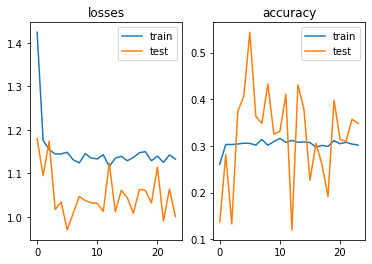

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       startEpoch, numEpoch, 
                       train_losses, valid_losses, train_acc, valid_acc)

In [34]:
# sample some test data and display the model's prediciton and the true label
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 30))

    with torch.no_grad():
        for i, (inputs, labels, num_data) in enumerate(dataloaders['test']):
            num_data = num_data.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, num_data)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'p: {classes[preds[j]]} , l: {classes[labels[j]]}')
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                inp = transformStd * inp + transformMean
                inp = np.clip(inp, 0, 1)
                imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

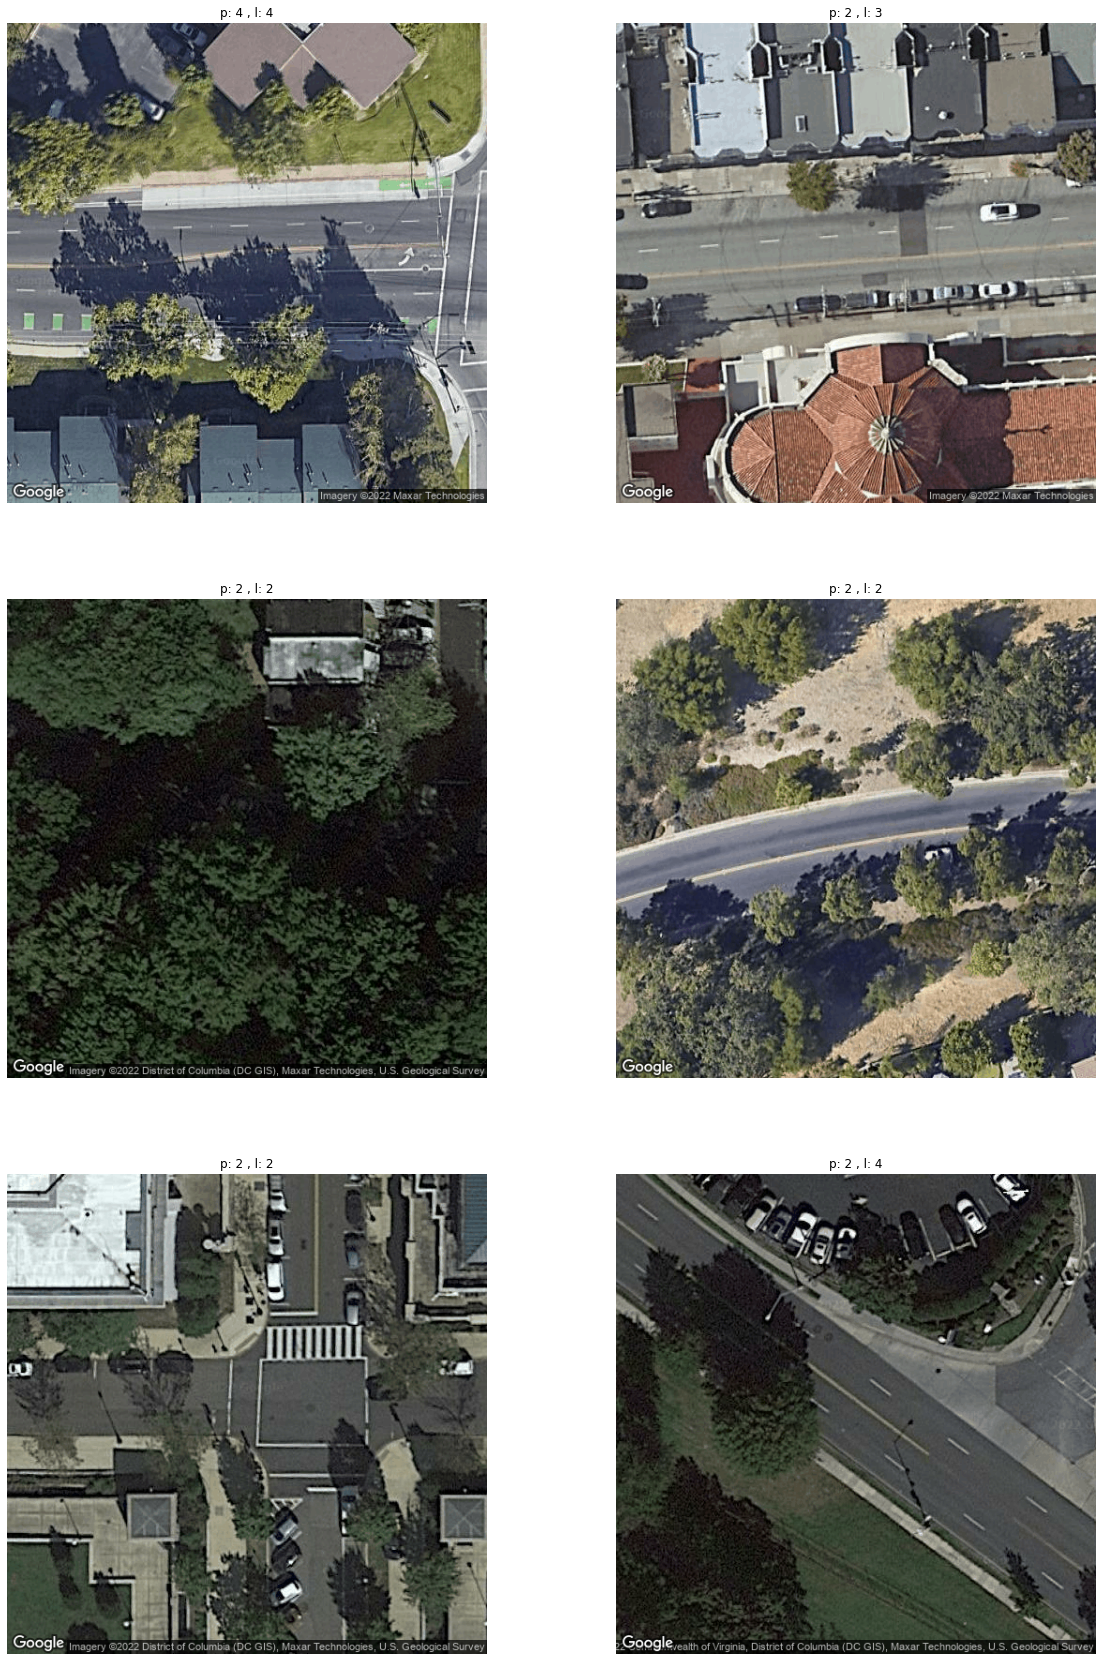

In [35]:
visualize_model(model_ft)

In [36]:
# display the accuracy of the model on test set 
# and break it down to accuracy for each type of lanes
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels, num_data in tqdm(dataloaders['test']):
        num_data = num_data.to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs, num_data)
        _, preds = torch.max(outputs.data, 1)
        c = (preds == labels)
        all_preds.extend(preds)
        all_labels.extend(labels)
        if c.size(dim=0) != 1:
            c = c.squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print()
for i in range(len(classes)):
    if class_total[i] == 0:
        print('0 total of %6s : %2d %% | %d' % (classes[i], class_correct[i], class_total[i]))
    else :
        print('Accuracy of %5s : %2d %% | %d' % (
        classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))
print('Overall test accuracy : %2d %% | %d' % (
        100 * sum(class_correct) / sum(class_total), sum(class_total)))

100%|██████████| 550/550 [01:01<00:00,  8.93it/s]


Accuracy of     1 : 50 % | 22
Accuracy of     2 : 97 % | 786
Accuracy of     3 :  0 % | 85
Accuracy of     4 : 39 % | 110
Accuracy of     5 :  0 % | 71
Accuracy of     6 :  0 % | 18
Accuracy of     7 :  0 % | 6
Accuracy of     8 :  0 % | 2
0 total of      9 :  0 % | 0
Overall test accuracy : 74 % | 1100
